# CQ Analysis for Wildfire Manuscript

In this notebook, we will go through analysis steps for downloading and analyzing our YSI EXO2 parameter data and USGS gage station data for the watersheds impacted by the Hermit's Peak Calf Canyon (HPCC) wildfire near Las Vegas, NM. 

## Table of Contents

1. [Loading the data and Necessary Libraries](#loading-the-data-and-necessary-libraries)
2. [Cleaning Data and Merging Concentration and Discharge (CQ) Data](#data-cleaning-merging)
3. [Event Delineation using Matlab HydRun Package](#hydrun)
4. [Calculation of CQ Slopes and Intercepts for Each Event](#cq_calcs)
5. [Classification of CQ Slopes into Categories for Each Event](#cq_classification)
6. [Calculating Event Features for Each Event](#event_features)
7. [Heatmap of Spearman Correlation of CQ Slopes and Event Features](#heat_map)
8. [Exceedance Probability Plots for Water Quality Parameters](#exceedance_probability)
9. [Summary Statistics](#summary_statistics)

## Loading the Data and Necessary Libraries 
<a class="anchor" id="loading-the-data-and-necessary-libraries"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import datetime as dt
import glob
import warnings
import os
import pickle
import sys
from datetime import timedelta
import statsmodels.api as sm

### Download the Concentration and Discharge Data for Analysis

In [2]:
# Function for importing data to dataframes
def PowerCurve(timeCol, valueCol, noRowMeta, folderPath, fileName):
    
    """
    Import the data from the YSI EXO2 Sondes.
    
    Parameters:
    timecol (str): The name of the column with the timeseries values.
    valueCol (str): The name of the column with the parameter values.
    noRowMeta (int): Number of rows before the column headings in the csv.
    folderPath (str): Path to the folder containing the csv files.
    fileName (str): Name of the csv including .csv.
    """

    # Combine the folder path and the file name to get the full file path
    filePath = os.path.join(folderPath, fileName)

    df = pd.read_csv(filePath, usecols=[timeCol, valueCol], skiprows=noRowMeta) # Skip the metadata rows of the Aquarius output files
    
    # Column where data is stored
    df[timeCol] = pd.to_datetime(df[timeCol])
    
    return df

In [3]:
## WTP parameters dataframes
# folder_path_M = 'C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Ch1 CQ Plots/062024 Aquarius Data Download/Hermit_Fire Gallinas at WTP'
folder_path_M = 'C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/P2_WQ_Data'
# mg/l
DO_WTP = PowerCurve('Timestamp (UTC+00:00)', 'Value', 14, folder_path_M, 'O2_(Dis).DO@Hermit_Fire.EntireRecord.csv')
# pH Units
pH_WTP = PowerCurve('Timestamp (UTC+00:00)', 'Value', 14, folder_path_M, 'pH.pH@Hermit_Fire.EntireRecord.csv')
# uS/cm
SpCond_WTP = PowerCurve('Timestamp (UTC+00:00)', 'Value', 14, folder_path_M, 'Sp_Cond.SpCond@Hermit_Fire.EntireRecord (1).csv')
# FNU
Turb_WTP = PowerCurve('Timestamp (UTC+00:00)', 'Value', 14, folder_path_M, 'Turbidity,_Form_Neph.Turbidity@Hermit_Fire.EntireRecord (2).csv')
# degC
Temp_WTP = PowerCurve('Timestamp (UTC+00:00)', 'Value', 14, folder_path_M, 'Water_Temp.WaterTemp@Hermit_Fire.EntireRecord.csv')

## Lourdes parameters dataframes
# folder_path_L = 'C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Ch1 CQ Plots/062024 Aquarius Data Download/Hermit_Fire4 Gallinas at Lourdes'
folder_path_L = 'C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/P3_WQ_Data'

# mg/l
DO_Lourdes = PowerCurve('Timestamp (UTC+00:00)', 'Value', 14, folder_path_L, 'O2_(Dis).DO@Hermit_Fire4.EntireRecord.csv')
# pH Units
pH_Lourdes = PowerCurve('Timestamp (UTC+00:00)', 'Value', 14, folder_path_L, 'pH.pH@Hermit_Fire4.EntireRecord.csv')
# uS/cm
SpCond_Lourdes = PowerCurve('Timestamp (UTC+00:00)', 'Value', 14, folder_path_L, 'Sp_Cond.SpCond@Hermit_Fire4.EntireRecord.csv')
# FNU
Turb_Lourdes = PowerCurve('Timestamp (UTC+00:00)', 'Value', 14, folder_path_L, 'Turbidity,_Form_Neph.Turbidity@Hermit_Fire4.EntireRecord.csv')
# degC
Temp_Lourdes = PowerCurve('Timestamp (UTC+00:00)', 'Value', 14, folder_path_L, 'Water_Temp.Temperature@Hermit_Fire4.EntireRecord.csv')

## Santa Rosa Upstream dataframes
# folder_path_SR = 'C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Ch1 CQ Plots/080724 Aquarius Data Download/'
folder_path_SR = 'C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/P5_WQ_Data'
# mg/l
DO_SRUp = PowerCurve('Timestamp (UTC+00:00)', 'Value', 14, folder_path_SR, 'O2_(Dis).DO@ACE_Santa_Rosa_Upstream.EntireRecord.csv')
# pH Units
pH_SRUp = PowerCurve('Timestamp (UTC+00:00)', 'Value', 14, folder_path_SR, 'pH.pH@ACE_Santa_Rosa_Upstream.EntireRecord.csv')
# uS/cm
SpCond_SRUp = PowerCurve('Timestamp (UTC+00:00)', 'Value', 14, folder_path_SR, 'Sp_Cond.SpCond@ACE_Santa_Rosa_Upstream.EntireRecord.csv')
# FNU
Turb_SRUp = PowerCurve('Timestamp (UTC+00:00)', 'Value', 14, folder_path_SR, 'Turbidity,_Form_Neph.Turbidity@ACE_Santa_Rosa_Upstream.EntireRecord.csv')
# degC
Temp_SRUp = PowerCurve('Timestamp (UTC+00:00)', 'Value', 14, folder_path_SR, 'Water_Temp.WaterTemp@ACE_Santa_Rosa_Upstream.EntireRecord.csv')

# Discharge dataframes
folder_path_USGS = 'C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/Q_Data'
# ft3/s
Discharge_WTP = PowerCurve('datetime', 'Disch', 25, folder_path_USGS, 'P2_Gallinas_Montezuma_Discharge.csv')
# ft3/s
Discharge_Lourdes = PowerCurve('datetime', 'Disch', 25, folder_path_USGS, 'P3_Gallinas_Lourdes_Discharge.csv')
# m3/s
Discharge_SRUp = PowerCurve('Timestamp (UTC+00:00)', 'Value', 14, folder_path_USGS, 'P5_Discharge.Discharge@ACE_Santa_Rosa_Upstream.EntireRecord.csv')

## Cleaning and Merging Data for CQ Analysis
<a class="anchor" id="data-cleaning-merging"></a>

### Unit Conversion of data
Convert discharge data from ft^3/s to m^3/s

In [4]:
## Convert Discharge for Montezuma, Lourdes, and Santa Rosa Up from ft3/s to m3/s

Discharge_WTP_copy = Discharge_WTP.copy()
Discharge_WTP['Disch'] = Discharge_WTP['Disch'] * 0.02831685


Discharge_Lourdes_copy = Discharge_Lourdes.copy()
Discharge_Lourdes = Discharge_Lourdes.iloc[:-1]
Discharge_Lourdes['Disch'] = Discharge_Lourdes['Disch'] * 0.02831685


# Discharge_SRUp_copy = Discharge_SRUp.copy()
# Discharge_SRUp['Value'] = Discharge_SRUp['Value'] * 0.02831685

### Function: Data Plotting for Visualization

In [5]:
def plot_pos_neg(df, x_col, y_col, title):
    """
    Scatter plot of a pandas dataframe with positive and negative points in different colors.
    
    Parameters:
    df (pandas.DataFrame): The dataframe containing the data.
    x_col (str): The column name for x-value data.
    y_col (str): The column name for y-value data.
    title (str): Title for the plot.
    """
    # Separate the positive and negative/zero values
    negative_values = df[df[y_col] <= 0]
    positive_values = df[df[y_col] > 0]

    # Plot new figure
    plt.figure() 
    # Plot the positive values
    plt.scatter(positive_values[x_col], positive_values[y_col], s=1, c='blue', label='Positive Values')
    # Plot the negative values
    plt.scatter(negative_values[x_col], negative_values[y_col], s=1, c='red', label='Negative Values')

    # Add labels and title
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title)
    plt.legend()
    plt.show()

### Plot the Data to Check for Negative Values
To take the log of the negative data, I need to remove points <= 0

Modify P5 Q data to only include data after UNM sensors deployed in other sites (April 2022-September 2023)

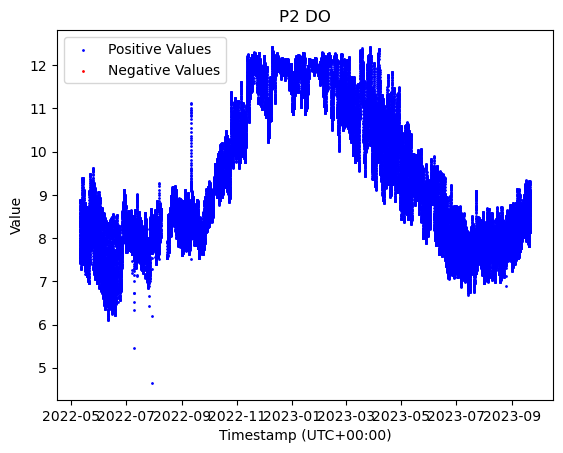

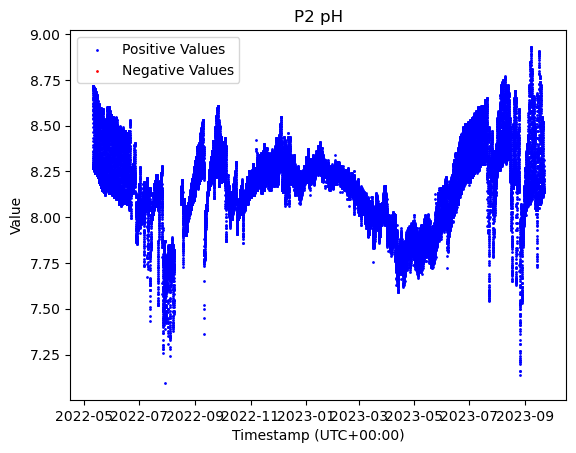

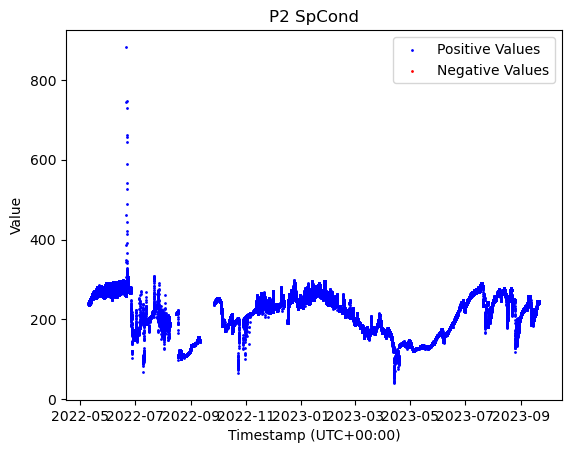

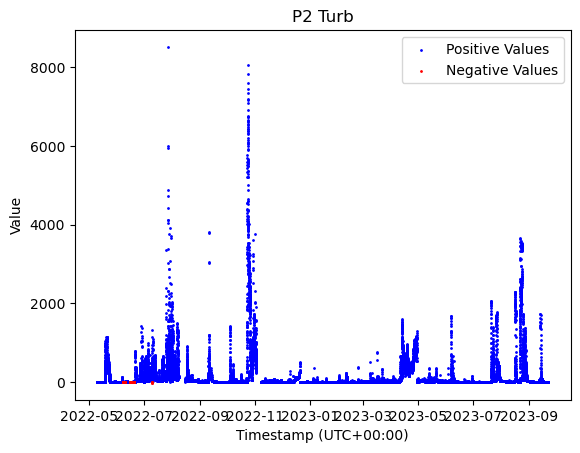

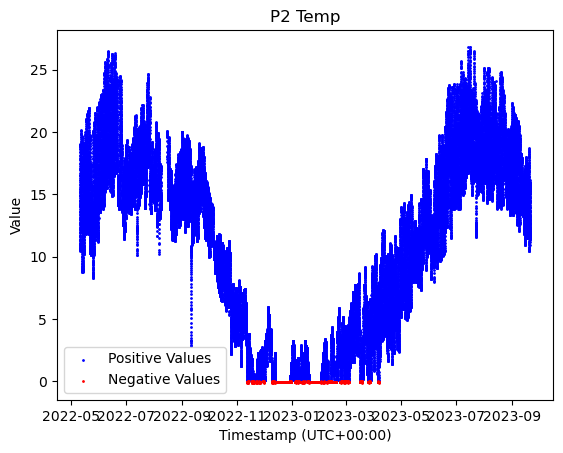

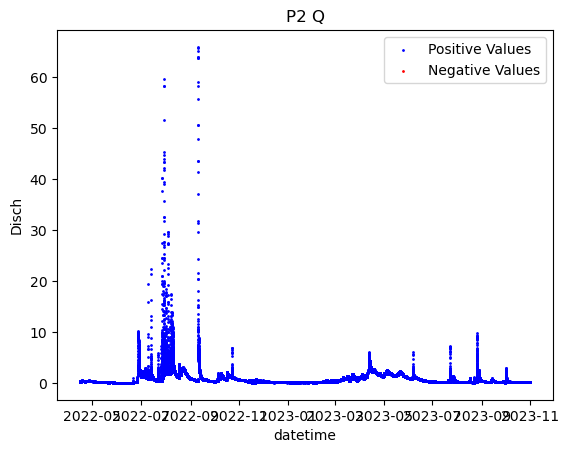

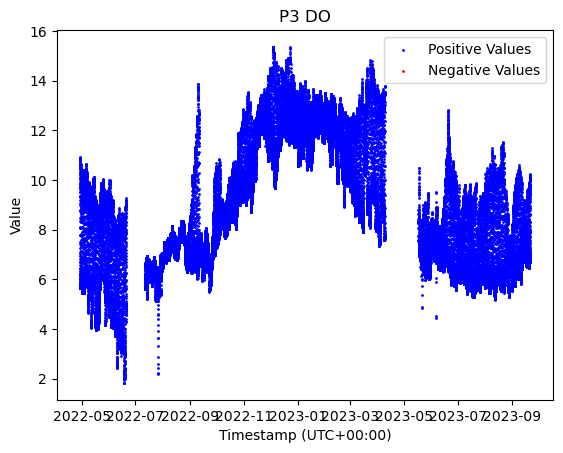

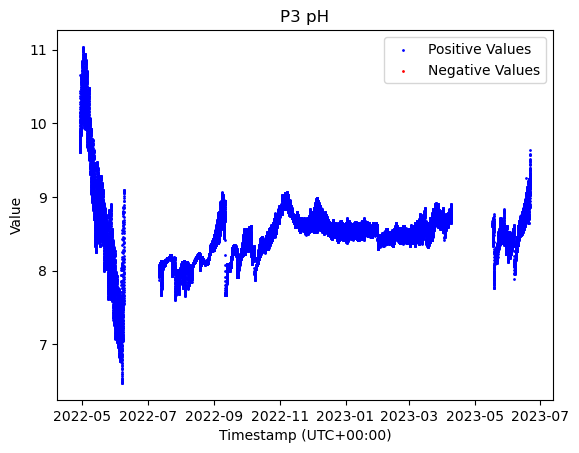

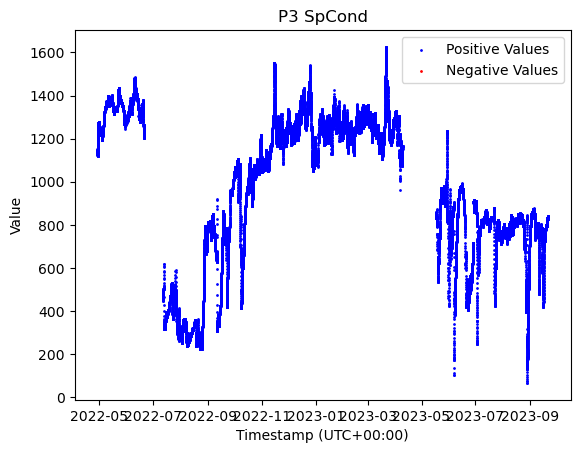

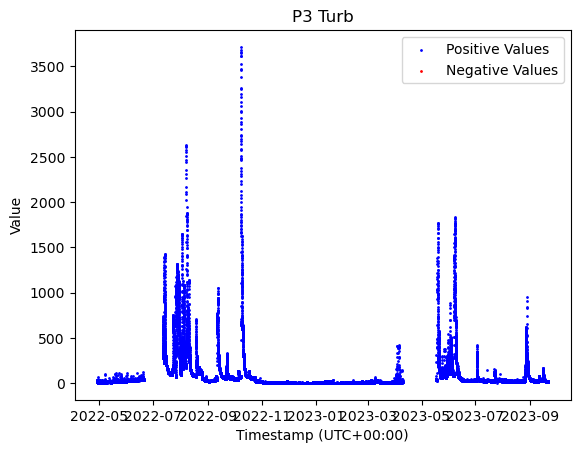

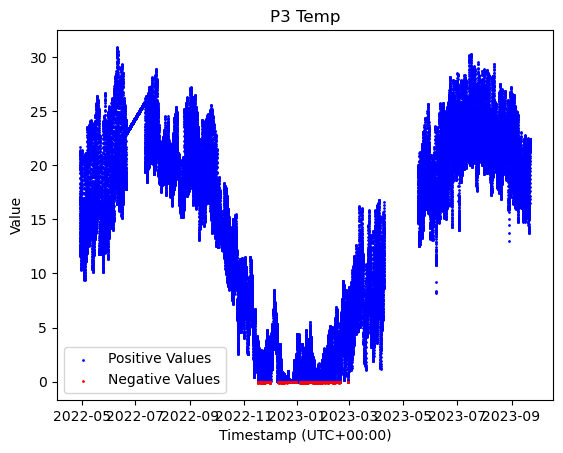

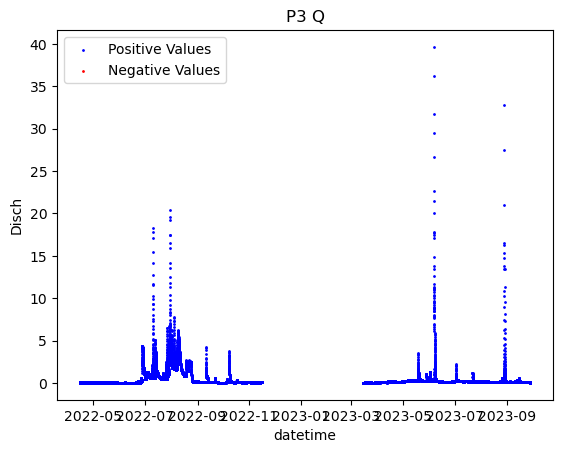

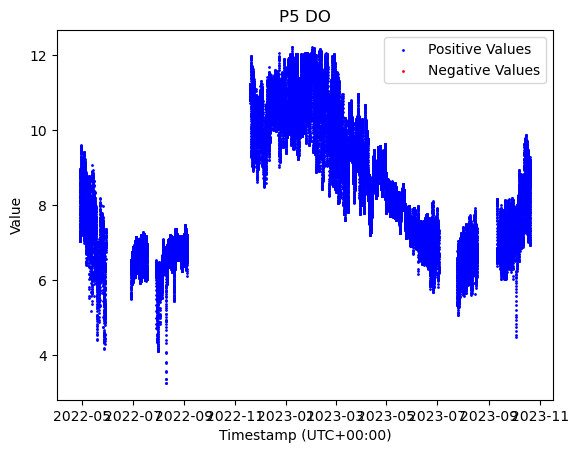

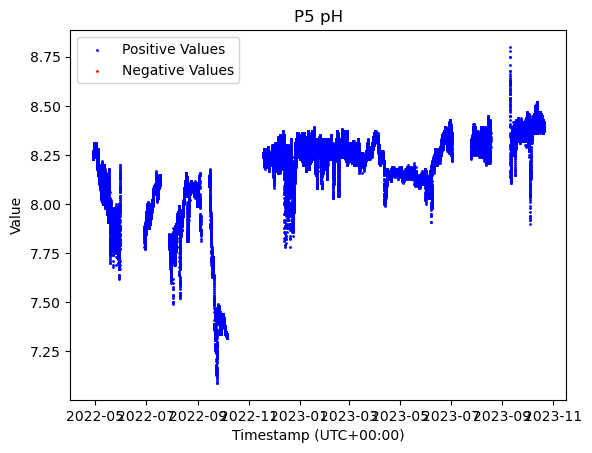

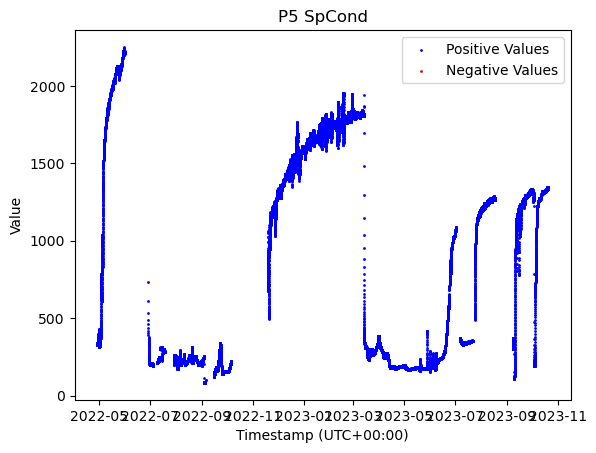

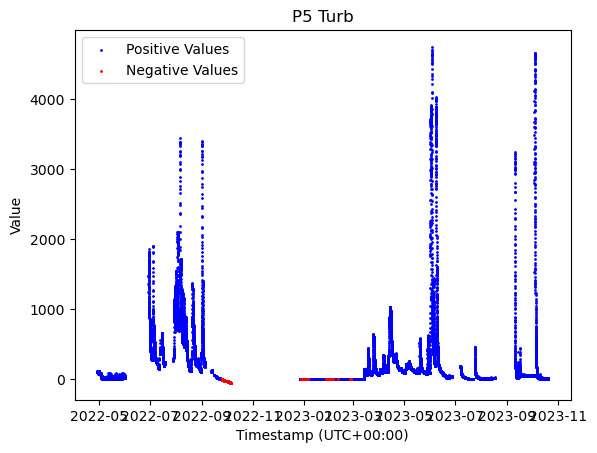

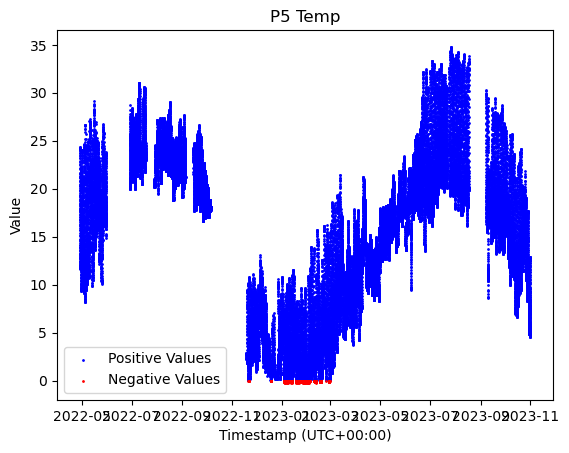

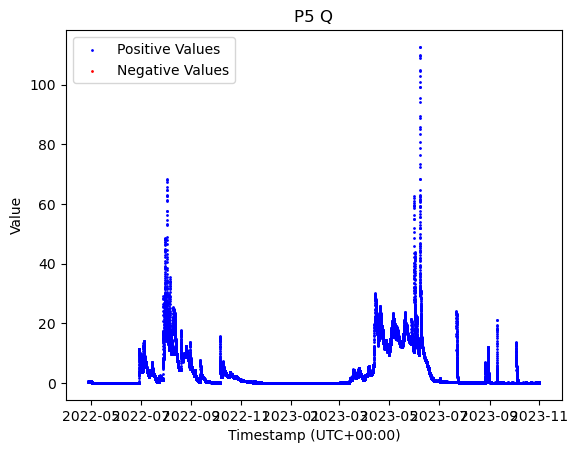

In [6]:
## P2

plot_pos_neg(DO_WTP, 'Timestamp (UTC+00:00)', 'Value', 'P2 DO')
plot_pos_neg(pH_WTP, 'Timestamp (UTC+00:00)', 'Value', 'P2 pH')
plot_pos_neg(SpCond_WTP, 'Timestamp (UTC+00:00)', 'Value', 'P2 SpCond')
plot_pos_neg(Turb_WTP, 'Timestamp (UTC+00:00)', 'Value', 'P2 Turb')
plot_pos_neg(Temp_WTP, 'Timestamp (UTC+00:00)', 'Value', 'P2 Temp')
plot_pos_neg(Discharge_WTP, 'datetime', 'Disch', 'P2 Q')

## P3
plot_pos_neg(DO_Lourdes, 'Timestamp (UTC+00:00)', 'Value', 'P3 DO')
plot_pos_neg(pH_Lourdes, 'Timestamp (UTC+00:00)', 'Value', 'P3 pH')
plot_pos_neg(SpCond_Lourdes, 'Timestamp (UTC+00:00)', 'Value', 'P3 SpCond')
plot_pos_neg(Turb_Lourdes, 'Timestamp (UTC+00:00)', 'Value', 'P3 Turb')
plot_pos_neg(Temp_Lourdes, 'Timestamp (UTC+00:00)', 'Value', 'P3 Temp')
plot_pos_neg(Discharge_Lourdes, 'datetime', 'Disch', 'P3 Q')

## P5        
cutoff_start_datetime = pd.to_datetime('2022-04-28 00:00:00') #Earliest date for filtering
cutoff_end_datetime = pd.to_datetime('2023-10-31 23:59:59') #Latest date for filtering

DO_SRUp_filt = DO_SRUp[(DO_SRUp['Timestamp (UTC+00:00)'] >= cutoff_start_datetime) & (DO_SRUp['Timestamp (UTC+00:00)'] <= cutoff_end_datetime)]
pH_SRUp_filt = pH_SRUp[(pH_SRUp['Timestamp (UTC+00:00)'] >= cutoff_start_datetime) & (pH_SRUp['Timestamp (UTC+00:00)'] <= cutoff_end_datetime)]
SpCond_SRUp_filt = SpCond_SRUp[(SpCond_SRUp['Timestamp (UTC+00:00)'] >= cutoff_start_datetime) & (SpCond_SRUp['Timestamp (UTC+00:00)'] <= cutoff_end_datetime)]
Turb_SRUp_filt = Turb_SRUp[(Turb_SRUp['Timestamp (UTC+00:00)'] >= cutoff_start_datetime) & (Turb_SRUp['Timestamp (UTC+00:00)'] <= cutoff_end_datetime)]
Temp_SRUp_filt = Temp_SRUp[(Temp_SRUp['Timestamp (UTC+00:00)'] >= cutoff_start_datetime) & (Temp_SRUp['Timestamp (UTC+00:00)'] <= cutoff_end_datetime)]
Discharge_SRUp_filt = Discharge_SRUp[(Discharge_SRUp['Timestamp (UTC+00:00)'] >= cutoff_start_datetime) & (Discharge_SRUp['Timestamp (UTC+00:00)'] <= cutoff_end_datetime)]
                    
    
plot_pos_neg(DO_SRUp_filt, 'Timestamp (UTC+00:00)', 'Value', 'P5 DO')
plot_pos_neg(pH_SRUp_filt, 'Timestamp (UTC+00:00)', 'Value', 'P5 pH')
plot_pos_neg(SpCond_SRUp_filt, 'Timestamp (UTC+00:00)', 'Value', 'P5 SpCond')
plot_pos_neg(Turb_SRUp_filt, 'Timestamp (UTC+00:00)', 'Value', 'P5 Turb')
plot_pos_neg(Temp_SRUp_filt, 'Timestamp (UTC+00:00)', 'Value', 'P5 Temp')
plot_pos_neg(Discharge_SRUp_filt, 'Timestamp (UTC+00:00)', 'Value', 'P5 Q')                                                                                                           

### Function: Find Row Index with Negative and Zero Values

In [7]:
def extract_neg_val(df, column):
    """
    Extract rows where the specified column has negative values.

    Parameters:
    df (pandas.DataFrame): The dataframe containing the data.
    column (str): The column name to check for negative values.

    Returns:
    pandas.DataFrame: A dataframe containing only the rows with negative values in the specified column.
    """
    negative_values = df[df[column] < 0]
    negative_values_indices = df[df[column] < 0].index
    
    return negative_values, negative_values_indices

def extract_zero_val(df, column):
    """
    Extract rows where the specified column has negative values.

    Parameters:
    df (pandas.DataFrame): The dataframe containing the data.
    column (str): The column name to check for zero values.

    Returns:
    pandas.DataFrame: A dataframe containing only the rows with negative values in the specified column.
    """
    negative_values = df[df[column] == 0]
    negative_values_indices = df[df[column] == 0].index
    
    return negative_values, negative_values_indices

### Function: Remove Negative Row Values

In [8]:
def remove_val_rows(df, value_indices):
    """
    Remove rows where the specified column has negative values by row number.

    Parameters:
    df (pandas.DataFrame): The dataframe containing the data.
    negative_value_indices (list): List of indices of rows that are to be removed from the dataframe.

    Returns:
    pandas.DataFrame: A dataframe with rows removed.
    """

    # Remove the rows with negative values
    df_cleaned = df.drop(value_indices)

    return df_cleaned

### Code for Removal of Negative Values
There are values <= to 0 for P2 and P5 for the turbidiy and tempeature, and temperature for P3. This will allow for use of CQ analysis, which takes the log of values.

In [9]:
## P2 Turbidity
Turb_WTP_neg, Turb_WTP_ind = extract_neg_val(Turb_WTP, 'Value') #Negative values indices
Turb_WTP_intermed = remove_val_rows(Turb_WTP, Turb_WTP_ind) #Remove negative values

Turb_WTP_zero, Turb_WTP_zero_ind = extract_zero_val(Turb_WTP_intermed, 'Value') #Zero value indices
Turb_WTP_clean = remove_val_rows(Turb_WTP_intermed, Turb_WTP_zero_ind) #Remove zero values

## P2 Tempeerature
Temp_WTP_neg, Temp_WTP_ind = extract_neg_val(Temp_WTP, 'Value') #Negative values indices
Temp_WTP_intermed = remove_val_rows(Temp_WTP, Temp_WTP_ind) #Remove zero values

Temp_WTP_zero, Temp_WTP_zero_ind = extract_zero_val(Temp_WTP_intermed, 'Value') #Zero value indices
Temp_WTP_clean = remove_val_rows(Temp_WTP_intermed, Temp_WTP_zero_ind) #Remove zero values

## P3 Tempearture
Temp_Lourdes_neg, Temp_Lourdes_ind = extract_neg_val(Temp_Lourdes, 'Value')
Temp_Lourdes_intermed = remove_val_rows(Temp_Lourdes, Temp_Lourdes_ind)

Temp_Lourdes_zero, Temp_Lourdes_zero_ind = extract_zero_val(Temp_Lourdes_intermed, 'Value')
Temp_Lourdes_clean = remove_val_rows(Temp_Lourdes_intermed, Temp_Lourdes_zero_ind)

## P5 Turbidity
Turb_SRUp_neg, Turb_SRUp_ind = extract_neg_val(Turb_SRUp_filt, 'Value')
Turb_SRUp_intermed = remove_val_rows(Turb_SRUp_filt, Turb_SRUp_ind)

Turb_SRUp_zero, Turb_SRUp_zero_ind = extract_zero_val(Turb_SRUp_intermed, 'Value')
Turb_SRUp_filt_clean = remove_val_rows(Turb_SRUp_intermed, Turb_SRUp_zero_ind)

## P5 Temperature
Temp_SRUp_neg, Temp_SRUp_ind = extract_neg_val(Temp_SRUp_filt, 'Value')
Temp_SRUp_intermed = remove_val_rows(Temp_SRUp_filt, Temp_SRUp_ind)

Temp_SRUp_zero, Temp_SRUp_zero_ind = extract_zero_val(Temp_SRUp_intermed, 'Value')
Temp_SRUp_filt_clean = remove_val_rows(Temp_SRUp_intermed, Temp_SRUp_zero_ind)

### Filter on the 15 minute mark
Some discharge data was collected at a 5 minute resolution for a portion of the time. To merge it with the concentration data, we filtered it to 15 minutes.

In [10]:
## Rename the 'datetime' column to 'Timestamp (UTC+00:00)' before filtering
Discharge_WTP.rename(columns={'datetime': 'Timestamp (UTC+00:00)'}, inplace=True)
Discharge_Lourdes.rename(columns={'datetime': 'Timestamp (UTC+00:00)'}, inplace=True)
Discharge_SRUp_filt.rename(columns={'Value': 'Disch'}, inplace=True)

C:\Users\ptunb\AppData\Local\Temp\ipykernel_33896\2445873959.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Discharge_SRUp_filt.rename(columns={'Value': 'Disch'}, inplace=True)


In [11]:
def filt_15_min_marks(df):
    """
    Filters the DataFrame to keep only the rows where the timestamp is on the 15-minute marks.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data

    Returns:
    pd.DataFrame: Filtered DataFrame with only 15-minute interval timestamps
    """
    # Convert the 'Timestamp (UTC+00:00)' column to datetime if not already in datetime format
    df['Timestamp (UTC+00:00)'] = pd.to_datetime(df['Timestamp (UTC+00:00)'])
    
    # Filter the DataFrame to keep only rows where the minutes are multiples of 15 and seconds are 0
    df_filtered = df[(df['Timestamp (UTC+00:00)'].dt.minute % 15 == 0) & (df['Timestamp (UTC+00:00)'].dt.second == 0)]
    
    return df_filtered

Discharge_WTP_filt = filt_15_min_marks(Discharge_WTP)
Discharge_Lourdes_filt = filt_15_min_marks(Discharge_Lourdes)
Discharge_SRUp_filt = filt_15_min_marks(Discharge_SRUp_filt)

C:\Users\ptunb\AppData\Local\Temp\ipykernel_33896\2227747562.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp (UTC+00:00)'] = pd.to_datetime(df['Timestamp (UTC+00:00)'])


### Function: Merging dataframes on the 'Timestamp' values

In [12]:
def merge_cQ(df1, df2, new_col_names=None):
    """
    Merge the dataframes on the heading title 'Timestamp (UTC+00:00)' using inner join and rename columns if specified.
    
    Parameters:
    df1 (pandas.DataFrame): First pandas dataframe for merging.
    df2 (pandas.DataFrame): Second pandas dataframe for merging.
    new_col_names (dict): Dictionary with old column names as keys and new column names as values.
                          Example: {'old_name1': 'new_name1', 'old_name2': 'new_name2'}
    """
    
    # Perform the merge
    merged_df = pd.merge(df1, df2, on='Timestamp (UTC+00:00)', how='inner')
    
    # Drop rows with NAs
    merged_df = merged_df.dropna()
    
    # Rename columns if new names are provided
    if new_col_names:
        merged_df = merged_df.rename(columns=new_col_names)
    
    return merged_df

In [13]:
## Rename the 'datetime' column to 'Timestamp (UTC+00:00)' before merging
Discharge_WTP.rename(columns={'datetime': 'Timestamp (UTC+00:00)'}, inplace=True)
Discharge_Lourdes.rename(columns={'datetime': 'Timestamp (UTC+00:00)'}, inplace=True)
Discharge_SRUp_filt.rename(columns={'Value': 'Disch'}, inplace=True)

# Rename the columns of the merged dataframe
new_col_names = {
    'Value_x': 'Param',
    'Value_y': 'Disch'
}
## P2
merge_DO_WTP = merge_cQ(DO_WTP, Discharge_WTP, new_col_names) #DO (mg/L)
merge_pH_WTP = merge_cQ(pH_WTP, Discharge_WTP, new_col_names) #pH
merge_SpCond_WTP = merge_cQ(SpCond_WTP, Discharge_WTP, new_col_names) #Sp Cond (uS/cm)
merge_Turb_WTP = merge_cQ(Turb_WTP_clean, Discharge_WTP, new_col_names) #Turbidity (FNU)
merge_Temp_WTP = merge_cQ(Temp_WTP_clean, Discharge_WTP, new_col_names) #Water Temp (degC)

## P3
merge_DO_Lourdes = merge_cQ(DO_Lourdes, Discharge_Lourdes, new_col_names) #DO (mg/L)
merge_pH_Lourdes = merge_cQ(pH_Lourdes, Discharge_Lourdes, new_col_names) #pH
merge_SpCond_Lourdes = merge_cQ(SpCond_Lourdes, Discharge_Lourdes, new_col_names) #Sp Cond (uS/cm)
merge_Turb_Lourdes = merge_cQ(Turb_Lourdes, Discharge_Lourdes, new_col_names) #Turbidity (FNU)
merge_Temp_Lourdes = merge_cQ(Temp_Lourdes_clean, Discharge_Lourdes, new_col_names) #Water Temp (degC)

## P5
merge_DO_SRUp = merge_cQ(DO_SRUp_filt, Discharge_SRUp_filt, new_col_names) #DO (mg/L)
merge_pH_SRUp = merge_cQ(pH_SRUp_filt, Discharge_SRUp_filt, new_col_names) #pH
merge_SpCond_SRUp = merge_cQ(SpCond_SRUp_filt, Discharge_SRUp_filt, new_col_names) #Sp Cond (uS/cm)
merge_Turb_SRUp = merge_cQ(Turb_SRUp_filt_clean, Discharge_SRUp_filt, new_col_names) #Turbidity (FNU)
merge_Temp_SRUp = merge_cQ(Temp_SRUp_filt_clean, Discharge_SRUp_filt, new_col_names) #Water Temp (degC)

## Event Delineation using Matlab HydRun Package
<a class="anchor" id="hydrun"></a>
The PKThreshold was determined to be the mean of the delineated baseflow value for each year. The filter = 0.995 and the ReRa = 0.25 for all runoff events.

The PKThreshold for each delineation year (m^3/s):
- P2 22 = 0.499
- P2 23 = 0.486
- P3 22 = 0.269
- P3 23 = 0.127
- P5 22 = 1.53
- P5 23 = 2.81

### Divide the dataframes into 2022 and 2023 and Export for Matlab

In [14]:
# Define the year to split by
split_year = 2023

## Split into two DataFrames based on the year
Discharge_WTP_22 = Discharge_WTP_filt[Discharge_WTP_filt['Timestamp (UTC+00:00)'].dt.year < split_year]
Discharge_WTP_23 = Discharge_WTP_filt[Discharge_WTP_filt['Timestamp (UTC+00:00)'].dt.year >= split_year]

Discharge_L_22 = Discharge_Lourdes_filt[Discharge_Lourdes_filt['Timestamp (UTC+00:00)'].dt.year < split_year]
Discharge_L_23 = Discharge_Lourdes_filt[Discharge_Lourdes_filt['Timestamp (UTC+00:00)'].dt.year >= split_year]

Discharge_SRUp_22 = Discharge_SRUp_filt[Discharge_SRUp_filt['Timestamp (UTC+00:00)'].dt.year < split_year]
Discharge_SRUp_23 = Discharge_SRUp_filt[Discharge_SRUp_filt['Timestamp (UTC+00:00)'].dt.year >= split_year]

## Export as CSV
# Discharge_WTP_22.to_csv('csv files/080724_Discharge_WTP_22.csv')
# Discharge_WTP_23.to_csv('csv files/080724_Discharge_WTP_23.csv')

# Discharge_L_22.to_csv('csv files/080724_Discharge_L_22.csv')
# Discharge_L_23.to_csv('csv files/080724_Discharge_L_23.csv')

# Discharge_SRUp_22.to_csv('csv files/080724_Discharge_SRUp_22.csv')
# Discharge_SRUp_23.to_csv('csv files/080724_Discharge_SRUp_23.csv')

### Import Delinated Events from HydRun
Imported CSV files include:
- Baseflow
- Stormflow - defined for each event
- Dimensions - the output CSV for theand Stormflow have all of the separate events combined, and so the number of rows are also included to separate the events into their own dataframes for further analysis.

In [15]:
## P2 (WTP) parameters dataframes
folder_path_Q = 'C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/Hydrun_Output_files'

# Discharge dataframes (m3/s)
bf_WTP_22 = PowerCurve('dateTimeValues_bf', 'Var2', 0, folder_path_Q, 'output_HydRun_baseflow_M_22_080724.csv')
bf_WTP_23 = PowerCurve('dateTimeValues_bf', 'Var2', 0, folder_path_Q, 'output_HydRun_baseflow_M_23_080724.csv')
bf_L_22 = PowerCurve('dateTimeValues_bf', 'Var2', 0, folder_path_Q, 'output_HydRun_baseflow_L_22_080724.csv')
bf_L_23 = PowerCurve('dateTimeValues_bf', 'Var2', 0, folder_path_Q, 'output_HydRun_baseflow_L_23_080724.csv')
bf_SR_22 = PowerCurve('dateTimeValues_bf', 'Var2', 0, folder_path_Q, 'output_HydRun_baseflow_SR_22_080724.csv')
bf_SR_23 = PowerCurve('dateTimeValues_bf', 'Var2', 0, folder_path_Q, 'output_HydRun_baseflow_SR_23_080724.csv')

### Function: Import Delineated Events from HydRun

In [16]:
# Function for importing data to dataframes
def ImportEvent(timeCol, valueCol, noRowMeta, fileName):
    
    """
    Import the data from the HydRun outputs that have been preprocessed in MATLAB.
    
    Parameters:
    timecol (str): The name of the column with the timeseries values.
    valueCol (str): The name of the column with the parameter values.
    noRowMeta (int): Number of rows before the column headings in the csv.
    fileName (str): Name of the csv including .csv.
    """
    
    valueCol = valueCol    
    timeCol = timeCol
    noRowMeta = noRowMeta
    df = pd.read_csv(fileName, usecols = [timeCol, valueCol], skiprows = noRowMeta) #Skip the metadata rows of the Aquarius output files
    
    #Column where data is stored
    df[timeCol] = pd.to_datetime(df[timeCol])
    df[timeCol] = df[timeCol].dt.round('15min') # Round converted dates to nearest 15 minutes after converting back from Julian Date in MATLAB
    
    return df

def ImportEventDim(Dim_Col, fileName):
    
    """
    Import the dimension data from the HydRun outputs that have been preprocessed 
    in MATLAB and which is used to split the event times.
    
    Parameters:
    Dim_Col (str): The name of the column with the dimension values.
    fileName (str): Name of the csv including .csv.
    """
    
    df_dim = pd.read_csv(fileName, usecols = [Dim_Col])
    
    return df_dim

### Function: Using HydRun Event Delineation Extract the Individual Event Data
This function imports the events, dimensions, and the previous merged dfs. It splits the dataframes and puts them in a list and then merges them on the 'Timestamp' with the previous CQ data. Finally it compared the merged data with the number of rows that should be in each dataframe, and if there is a difference in rows or the dataframe is empty due to a lack of available concentration data, the dataframe is returned to be evaluated for missing data.

In [17]:
def SplitEvents_mod(df_event, df_dimension, df_param):
    
    """
    Splits the rows of the HydRun simulation data imported by the function 'ImportEvent' 
    using the dimensions output and preprocessed in MATLAB. It is then merged with the 
    merged dataframe.

    Parameters:
    df_event (pandas.DataFrame): Pandas dataframe of data from the function 'ImportEvent'.
    df_dimensions (pandas.DataFrame): Pandas dataframe of data dimensions from function 'ImportEventDim'.
    df_param (pandas.DataFrame): Pandas dataframe of merged values.
    
    Returns:
    filtered_dfs (list of pandas.DataFrame): List of merged dataframes with no row count difference 
                                             and more than 4 rows.
    """
    
    # Define the row numbers where you want to split the DataFrame
    split_rows = df_dimension['Dimension_1_1']

    # Split the DataFrame into separate DataFrames
    dfs = []
    start_row = 0

    for end_row in split_rows:
        
        cumulative_index = start_row + end_row
        
        dfs.append(df_event.iloc[start_row:cumulative_index])
        
        start_row = end_row + start_row

    
    # List to store merged DataFrames
    merged_dfs = []
    
    # Merge parameter df with each DataFrame in dfs
    for i, df in enumerate(dfs):
        merged_df = pd.merge(left=df_param, left_on='Timestamp (UTC+00:00)',
                             right=df, right_on='dateTimeValues', how='inner')
        merged_dfs.append(merged_df)
        
    # Compare the number of rows in each of the merged DataFrames with the original DataFrames in dfs
    matching_indices = []
    non_matching_indices = []
    for i, (df, merged_df) in enumerate(zip(dfs, merged_dfs)):
        original_row_count = len(df)
        merged_row_count = len(merged_df)
        difference = abs(original_row_count - merged_row_count)
        
        if difference == 0:
            matching_indices.append(i)
        else:
            non_matching_indices.append(i)
    
    return merged_dfs, matching_indices, non_matching_indices

In [18]:
def SplitEvents_emptydf(df_event, df_dimension, df_param):
    
    """
    Splits the rows of the HydRun simulation data imported by the function 'ImportEvent' 
    using the dimensions output and preprocessed in MATLAB. It is then merged with the 
    merged dataframe.

    Parameters:
    df_event (pandas.DataFrame): Pandas dataframe of data from the function 'ImportEvent'.
    df_dimensions (pandas.DataFrame): Pandas dataframe of data dimensions from function 'ImportEventDim'.
    df_param (pandas.DataFrame): Pandas dataframe of merged values.
    
    Returns:
    filtered_dfs (list of pandas.DataFrame): List of merged dataframes with no row count difference 
                                             and more than 4 rows.
    """
    
    # Define the row numbers where you want to split the DataFrame
    split_rows = df_dimension['Dimension_1_1']

    # Split the DataFrame into separate DataFrames
    dfs = []
    start_row = 0

    for end_row in split_rows:
        
        cumulative_index = start_row + end_row
        
        dfs.append(df_event.iloc[start_row:cumulative_index])
        
        start_row = end_row + start_row
        
    # List to store merged DataFrames
    merged_dfs = []
    
    # Merge parameter df with each DataFrame in dfs
    for i, df in enumerate(dfs):
        merged_df = pd.merge(left=df_param, left_on='Timestamp (UTC+00:00)',
                             right=df, right_on='dateTimeValues', how='inner')
        merged_dfs.append(merged_df)
        
    # Compare the number of rows in each of the merged DataFrames with the original DataFrames in dfs
    matching_indices = []
    non_matching_indices = []
    for i, (df, merged_df) in enumerate(zip(dfs, merged_dfs)):
        if merged_df.empty:
            non_matching_indices.append(i)
        else:
            matching_indices.append(i)
    
    return merged_dfs, matching_indices, non_matching_indices

### Function: Code to Plot All Event Dataframes and Parameters to Evaluate Missing Data

In [19]:
import matplotlib.pyplot as plt

def plot_dataframes_list(df_lists, param_details):
    num_events = len(df_lists[0])  # Number of events per parameter
    num_params = len(df_lists)  # Number of parameters

    fig, axes = plt.subplots(num_events, num_params, figsize=(num_params * 5, num_events * 5), sharex=False)
    
    if num_events == 1:
        axes = [axes]  # Ensure axes is always 2D

    for i, param_name in enumerate(param_details.keys()):
        for j in range(num_events):
            ax = axes[j][i] if num_events > 1 else axes[i]
            
            df = df_lists[i][j] if j < len(df_lists[i]) else None
            
            if df is not None and not df.empty:
                color = param_details[param_name]['color']
                unit = param_details[param_name]['unit']
                
                # Plot the parameter value
                ax.scatter(df['Timestamp (UTC+00:00)'], df['Value'], label=f'{param_name} {unit}', color=color)
                
                # Plot the discharge on the secondary y-axis
                ax2 = ax.twinx()
                ax2.plot(df['Timestamp (UTC+00:00)'], df['Disch'], label='Discharge', color='gray', alpha=0.5)
                
                # Set x-axis limits based on the data range in the dataframe
                ax.set_xlim(df['Timestamp (UTC+00:00)'].min(), df['Timestamp (UTC+00:00)'].max())
                
                if j == 0:
                    ax.set_title(f'{param_name} vs Discharge')
                if j == num_events - 1:
                    ax.set_xlabel('Timestamp (UTC+00:00)')
                if i == 0:
                    ax.set_ylabel('Parameter')
                if i == num_params - 1:
                    ax2.set_ylabel('Discharge (cms)')
                
                ax.legend(loc='upper left')
                ax2.legend(loc='upper right')
            else:
                ax.axis('off')  # Turn off the axis if no data is available
    
    plt.tight_layout()
    plt.show()

### Import Data and Dimension CSV from Matlab

In [20]:
## P2 
Discharge_WTP_Event_22 = ImportEvent('dateTimeValues', 'Var2', 0, 'C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/Hydrun_Output_files/output_HydRun_events_M_22_080724.csv')
Dim_WTP_22 = ImportEventDim('Dimension_1_1','C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/Hydrun_Output_files/cell_dimensions_M_22_080724.csv')

Discharge_WTP_Event_23 = ImportEvent('dateTimeValues', 'Var2', 0, 'C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/Hydrun_Output_files/output_HydRun_events_M_23_080724.csv')
Dim_WTP_23 = ImportEventDim('Dimension_1_1','C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/Hydrun_Output_files/cell_dimensions_M_23_080724.csv')

## P3
Discharge_L_Event_22 = ImportEvent('dateTimeValues', 'Var2', 0, 'C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/Hydrun_Output_files/output_HydRun_events_L_22_080724.csv')
Dim_L_22 = ImportEventDim('Dimension_1_1','C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/Hydrun_Output_files/cell_dimensions_L_22_080724.csv')

Discharge_L_Event_23 = ImportEvent('dateTimeValues', 'Var2', 0, 'C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/Hydrun_Output_files/output_HydRun_events_L_23_080724.csv')
Dim_L_23 = ImportEventDim('Dimension_1_1','C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/Hydrun_Output_files/cell_dimensions_L_23_080724.csv')

## P5
Discharge_SR_Event_22 = ImportEvent('dateTimeValues', 'Var2', 0, 'C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/Hydrun_Output_files/output_HydRun_events_SR_22_080724.csv')
Dim_SR_22 = ImportEventDim('Dimension_1_1','C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/Hydrun_Output_files/cell_dimensions_SR_22_080724.csv')

Discharge_SR_Event_23 = ImportEvent('dateTimeValues', 'Var2', 0, 'C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/Hydrun_Output_files/output_HydRun_events_SR_23_080724.csv')
Dim_SR_23 = ImportEventDim('Dimension_1_1','C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/Hydrun_Output_files/cell_dimensions_SR_23_080724.csv')

### Import Event Data and Evaluate Missing Data

In [21]:
## P2 2022
DO_event_22_df_M, DO_match_ind, DO_nmatch_ind = SplitEvents_mod(Discharge_WTP_Event_22, Dim_WTP_22, merge_DO_WTP)
pH_event_22_df_M, pH_match_ind, pH_nmatch_ind = SplitEvents_mod(Discharge_WTP_Event_22, Dim_WTP_22, merge_pH_WTP)
SpCond_event_22_df_M, SpCond_match_ind, SpCond_nmatch_ind = SplitEvents_mod(Discharge_WTP_Event_22, Dim_WTP_22, merge_SpCond_WTP)
Turb_event_22_df_M, Turb_match_ind, Turb_nmatch_ind = SplitEvents_mod(Discharge_WTP_Event_22, Dim_WTP_22, merge_Turb_WTP)
Temp_event_22_df_M, Temp_match_ind, Temp_nmatch_ind = SplitEvents_mod(Discharge_WTP_Event_22, Dim_WTP_22, merge_Temp_WTP)

DO_event_22_df_M, DO_match_ind_emptydf, DO_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_WTP_Event_22, Dim_WTP_22, merge_DO_WTP)
pH_event_22_df_M, pH_match_ind_emptydf, pH_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_WTP_Event_22, Dim_WTP_22, merge_pH_WTP)
SpCond_event_22_df_M, SpCond_match_ind_emptydf, SpCond_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_WTP_Event_22, Dim_WTP_22, merge_SpCond_WTP)
Turb_event_22_df_M, Turb_match_ind_emptydf, Turb_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_WTP_Event_22, Dim_WTP_22, merge_Turb_WTP)
Temp_event_22_df_M, Temp_match_ind_emptydf, Temp_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_WTP_Event_22, Dim_WTP_22, merge_Temp_WTP)

# print(DO_nmatch_ind, pH_nmatch_ind, SpCond_nmatch_ind, Turb_nmatch_ind, Temp_nmatch_ind)
# print(DO_nmatch_ind_emptydf, pH_nmatch_ind_emptydf, SpCond_nmatch_ind_emptydf, Turb_nmatch_ind_emptydf, Temp_nmatch_ind_emptydf)

##P2 2023
DO_event_23_df_M, DO_match_ind, DO_nmatch_ind = SplitEvents_mod(Discharge_WTP_Event_23, Dim_WTP_23, merge_DO_WTP)
pH_event_23_df_M, pH_match_ind, pH_nmatch_ind = SplitEvents_mod(Discharge_WTP_Event_23, Dim_WTP_23, merge_pH_WTP)
SpCond_event_23_df_M, SpCond_match_ind, SpCond_nmatch_ind = SplitEvents_mod(Discharge_WTP_Event_23, Dim_WTP_23, merge_SpCond_WTP)
Turb_event_23_df_M, Turb_match_ind, Turb_nmatch_ind = SplitEvents_mod(Discharge_WTP_Event_23, Dim_WTP_23, merge_Turb_WTP)
Temp_event_23_df_M, Temp_match_ind, Temp_nmatch_ind = SplitEvents_mod(Discharge_WTP_Event_23, Dim_WTP_23, merge_Temp_WTP)

DO_event_23_df_M, DO_match_ind_emptydf, DO_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_WTP_Event_23, Dim_WTP_23, merge_DO_WTP)
pH_event_23_df_M, pH_match_ind_emptydf, pH_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_WTP_Event_23, Dim_WTP_23, merge_pH_WTP)
SpCond_event_23_df_M, SpCond_match_ind_emptydf, SpCond_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_WTP_Event_23, Dim_WTP_23, merge_SpCond_WTP)
Turb_event_23_df_M, Turb_match_ind_emptydf, Turb_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_WTP_Event_23, Dim_WTP_23, merge_Turb_WTP)
Temp_event_23_df_M, Temp_match_ind_emptydf, Temp_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_WTP_Event_23, Dim_WTP_23, merge_Temp_WTP)

# print(DO_nmatch_ind, pH_nmatch_ind, SpCond_nmatch_ind, Turb_nmatch_ind, Temp_nmatch_ind)
# print(DO_nmatch_ind_emptydf, pH_nmatch_ind_emptydf, SpCond_nmatch_ind_emptydf, Turb_nmatch_ind_emptydf, Temp_nmatch_ind_emptydf)

## P3 2022

DO_event_22_df_L, DO_match_ind, DO_nmatch_ind = SplitEvents_mod(Discharge_L_Event_22, Dim_L_22, merge_DO_Lourdes)
pH_event_22_df_L, pH_match_ind, pH_nmatch_ind = SplitEvents_mod(Discharge_L_Event_22, Dim_L_22, merge_pH_Lourdes)
SpCond_event_22_df_L, SpCond_match_ind, SpCond_nmatch_ind = SplitEvents_mod(Discharge_L_Event_22, Dim_L_22, merge_SpCond_Lourdes)
Turb_event_22_df_L, Turb_match_ind, Turb_nmatch_ind = SplitEvents_mod(Discharge_L_Event_22, Dim_L_22, merge_Turb_Lourdes)
Temp_event_22_df_L, Temp_match_ind, Temp_nmatch_ind = SplitEvents_mod(Discharge_L_Event_22, Dim_L_22, merge_Temp_Lourdes)

DO_event_22_df_L, DO_match_ind_emptydf, DO_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_L_Event_22, Dim_L_22, merge_DO_Lourdes)
pH_event_22_df_L, pH_match_ind_emptydf, pH_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_L_Event_22, Dim_L_22, merge_pH_Lourdes)
SpCond_event_22_df_L, SpCond_match_ind_emptydf, SpCond_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_L_Event_22, Dim_L_22, merge_SpCond_Lourdes)
Turb_event_22_df_L, Turb_match_ind_emptydf, Turb_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_L_Event_22, Dim_L_22, merge_Turb_Lourdes)
Temp_event_22_df_L, Temp_match_ind_emptydf, Temp_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_L_Event_22, Dim_L_22, merge_Temp_Lourdes)

# print(DO_nmatch_ind, pH_nmatch_ind, SpCond_nmatch_ind, Turb_nmatch_ind, Temp_nmatch_ind)
# print(DO_nmatch_ind_emptydf, pH_nmatch_ind_emptydf, SpCond_nmatch_ind_emptydf, Turb_nmatch_ind_emptydf, Temp_nmatch_ind_emptydf)

## P3 2023
DO_event_23_df_L, DO_match_ind, DO_nmatch_ind = SplitEvents_mod(Discharge_L_Event_23, Dim_L_23, merge_DO_Lourdes)
pH_event_23_df_L, pH_match_ind, pH_nmatch_ind = SplitEvents_mod(Discharge_L_Event_23, Dim_L_23, merge_pH_Lourdes)
SpCond_event_23_df_L, SpCond_match_ind, SpCond_nmatch_ind = SplitEvents_mod(Discharge_L_Event_23, Dim_L_23, merge_SpCond_Lourdes)
Turb_event_23_df_L, Turb_match_ind, Turb_nmatch_ind = SplitEvents_mod(Discharge_L_Event_23, Dim_L_23, merge_Turb_Lourdes)
Temp_event_23_df_L, Temp_match_ind, Temp_nmatch_ind = SplitEvents_mod(Discharge_L_Event_23, Dim_L_23, merge_Temp_Lourdes)

DO_event_23_df_L, DO_match_ind_emptydf, DO_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_L_Event_23, Dim_L_23, merge_DO_Lourdes)
pH_event_23_df_L, pH_match_ind_emptydf, pH_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_L_Event_23, Dim_L_23, merge_pH_Lourdes)
SpCond_event_23_df_L, SpCond_match_ind_emptydf, SpCond_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_L_Event_23, Dim_L_23, merge_SpCond_Lourdes)
Turb_event_23_df_L, Turb_match_ind_emptydf, Turb_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_L_Event_23, Dim_L_23, merge_Turb_Lourdes)
Temp_event_23_df_L, Temp_match_ind_emptydf, Temp_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_L_Event_23, Dim_L_23, merge_Temp_Lourdes)

# print(DO_nmatch_ind, pH_nmatch_ind, SpCond_nmatch_ind, Turb_nmatch_ind, Temp_nmatch_ind)
# print(DO_nmatch_ind_emptydf, pH_nmatch_ind_emptydf, SpCond_nmatch_ind_emptydf, Turb_nmatch_ind_emptydf, Temp_nmatch_ind_emptydf)

## P5 2022
DO_event_22_df_SR, DO_match_ind, DO_nmatch_ind = SplitEvents_mod(Discharge_SR_Event_22, Dim_SR_22, merge_DO_SRUp)
pH_event_22_df_SR, pH_match_ind, pH_nmatch_ind = SplitEvents_mod(Discharge_SR_Event_22, Dim_SR_22, merge_pH_SRUp)
SpCond_event_22_df_SR, SpCond_match_ind, SpCond_nmatch_ind = SplitEvents_mod(Discharge_SR_Event_22, Dim_SR_22, merge_SpCond_SRUp)
Turb_event_22_df_SR, Turb_match_ind, Turb_nmatch_ind = SplitEvents_mod(Discharge_SR_Event_22, Dim_SR_22, merge_Turb_SRUp)
Temp_event_22_df_SR, Temp_match_ind, Temp_nmatch_ind = SplitEvents_mod(Discharge_SR_Event_22, Dim_SR_22, merge_Temp_SRUp)

DO_event_22_df_SR, DO_match_ind_emptydf, DO_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_SR_Event_22, Dim_SR_22, merge_DO_SRUp)
pH_event_22_df_SR, pH_match_ind_emptydf, pH_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_SR_Event_22, Dim_SR_22, merge_pH_SRUp)
SpCond_event_22_df_SR, SpCond_match_ind_emptydf, SpCond_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_SR_Event_22, Dim_SR_22, merge_SpCond_SRUp)
Turb_event_22_df_SR, Turb_match_ind_emptydf, Turb_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_SR_Event_22, Dim_SR_22, merge_Turb_SRUp)
Temp_event_22_df_SR, Temp_match_ind_emptydf, Temp_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_SR_Event_22, Dim_SR_22, merge_Temp_SRUp)

# print(DO_nmatch_ind, pH_nmatch_ind, SpCond_nmatch_ind, Turb_nmatch_ind, Temp_nmatch_ind)
# print(DO_nmatch_ind_emptydf, pH_nmatch_ind_emptydf, SpCond_nmatch_ind_emptydf, Turb_nmatch_ind_emptydf, Temp_nmatch_ind_emptydf)

## P5 2023
DO_event_23_df_SR, DO_match_ind, DO_nmatch_ind = SplitEvents_mod(Discharge_SR_Event_23, Dim_SR_23, merge_DO_SRUp)
pH_event_23_df_SR, pH_match_ind, pH_nmatch_ind = SplitEvents_mod(Discharge_SR_Event_23, Dim_SR_23, merge_pH_SRUp)
SpCond_event_23_df_SR, SpCond_match_ind, SpCond_nmatch_ind = SplitEvents_mod(Discharge_SR_Event_22, Dim_SR_23, merge_SpCond_SRUp)
Turb_event_23_df_SR, Turb_match_ind, Turb_nmatch_ind = SplitEvents_mod(Discharge_SR_Event_23, Dim_SR_23, merge_Turb_SRUp)
Temp_event_23_df_SR, Temp_match_ind, Temp_nmatch_ind = SplitEvents_mod(Discharge_SR_Event_23, Dim_SR_23, merge_Temp_SRUp)

DO_event_23_df_SR, DO_match_ind_emptydf, DO_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_SR_Event_23, Dim_SR_23, merge_DO_SRUp)
pH_event_23_df_SR, pH_match_ind_emptydf, pH_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_SR_Event_23, Dim_SR_23, merge_pH_SRUp)
SpCond_event_23_df_SR, SpCond_match_ind_emptydf, SpCond_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_SR_Event_23, Dim_SR_23, merge_SpCond_SRUp)
Turb_event_23_df_SR, Turb_match_ind_emptydf, Turb_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_SR_Event_23, Dim_SR_23, merge_Turb_SRUp)
Temp_event_23_df_SR, Temp_match_ind_emptydf, Temp_nmatch_ind_emptydf = SplitEvents_emptydf(Discharge_SR_Event_23, Dim_SR_23, merge_Temp_SRUp)

# print(DO_nmatch_ind, pH_nmatch_ind, SpCond_nmatch_ind, Turb_nmatch_ind, Temp_nmatch_ind)
# print(DO_nmatch_ind_emptydf, pH_nmatch_ind_emptydf, SpCond_nmatch_ind_emptydf, Turb_nmatch_ind_emptydf, Temp_nmatch_ind_emptydf)

### Code to Exclude Empty Dataframes and those with Missing Data

In [23]:
## P2 2022
# 21, 22, 23 df empty, 7 due to missing turbidity data on falling limb, 26 due to missing specific conductivity and 
# large outlier in Turbidity, and 17 due to missing SpCond and Turbidity
idx_M_22 = [7,21,22,23,26,27]

DO_event_22_df_M = [item for index, item in enumerate(DO_event_22_df_M) if index not in idx_M_22]
pH_event_22_df_M = [item for index, item in enumerate(pH_event_22_df_M) if index not in idx_M_22]
SpCond_event_22_df_M = [item for index, item in enumerate(SpCond_event_22_df_M) if index not in idx_M_22]
Turb_event_22_df_M = [item for index, item in enumerate(Turb_event_22_df_M) if index not in idx_M_22]
Temp_event_22_df_M = [item for index, item in enumerate(Temp_event_22_df_M) if index not in idx_M_22]

## P2 2023
# 18 and 19 have empty dfs, 0 due obvious missing data in Temp
idx_M_23 = [0, 18,19]

# Create a new list by excluding items at the specified indices
DO_event_23_df_M = [item for index, item in enumerate(DO_event_23_df_M) if index not in idx_M_23]
pH_event_23_df_M = [item for index, item in enumerate(pH_event_23_df_M) if index not in idx_M_23]
SpCond_event_23_df_M = [item for index, item in enumerate(SpCond_event_23_df_M) if index not in idx_M_23]
Turb_event_23_df_M = [item for index, item in enumerate(Turb_event_23_df_M) if index not in idx_M_23]
Temp_event_23_df_M = [item for index, item in enumerate(Temp_event_23_df_M) if index not in idx_M_23]

## P3 2022
# 0-4 have empty dataframes, 5 has missing data
idx_L_22 = [0,1,2,3,4,5]

# Create a new list by excluding items at the specified indices
DO_event_22_df_L = [item for index, item in enumerate(DO_event_22_df_L) if index not in idx_L_22]
pH_event_22_df_L = [item for index, item in enumerate(pH_event_22_df_L) if index not in idx_L_22]
SpCond_event_22_df_L = [item for index, item in enumerate(SpCond_event_22_df_L) if index not in idx_L_22]
Turb_event_22_df_L = [item for index, item in enumerate(Turb_event_22_df_L) if index not in idx_L_22]
Temp_event_22_df_L = [item for index, item in enumerate(Temp_event_22_df_L) if index not in idx_L_22]

## P3 2023
# Note that there is data missing from dataframes 7-15 for pH, but was not excluded from further analysis

## P5 2022
#5, 20, 21, 22, 23 have empty dataframes, 3 has missing data
idx_SR_22 = [3,5,20,21,22,23]

# Create a new list by excluding items at the specified indices
DO_event_22_df_SR = [item for index, item in enumerate(DO_event_22_df_SR) if index not in idx_SR_22]
pH_event_22_df_SR = [item for index, item in enumerate(pH_event_22_df_SR) if index not in idx_SR_22]
SpCond_event_22_df_SR = [item for index, item in enumerate(SpCond_event_22_df_SR) if index not in idx_SR_22]
Turb_event_22_df_SR = [item for index, item in enumerate(Turb_event_22_df_SR) if index not in idx_SR_22]
Temp_event_22_df_SR = [item for index, item in enumerate(Temp_event_22_df_SR) if index not in idx_SR_22]

## P5 2023
# 16-19 are empty dataframes
idx_SR_23 = [16,17,18,19]

# Create a new list by excluding items at the specified indices
DO_event_23_df_SR = [item for index, item in enumerate(DO_event_23_df_SR) if index not in idx_SR_23]
pH_event_23_df_SR = [item for index, item in enumerate(pH_event_23_df_SR) if index not in idx_SR_23]
SpCond_event_23_df_SR = [item for index, item in enumerate(SpCond_event_23_df_SR) if index not in idx_SR_23]
Turb_event_23_df_SR = [item for index, item in enumerate(Turb_event_23_df_SR) if index not in idx_SR_23]
Temp_event_23_df_SR = [item for index, item in enumerate(Temp_event_23_df_SR) if index not in idx_SR_23]

# print(len(DO_event_22_df_M), len(DO_event_23_df_M), len(DO_event_22_df_L), len(DO_event_23_df_L), len(DO_event_22_df_SR), len(DO_event_23_df_SR))

## Calculate CQ Slope and Intercepts
<a class="anchor" id="cq_calcs"></a>

### Function: Calculate OLS Regression

In [25]:
def OLS_regression(x, y):
    # Calculate x and y using logarithmic transformations
    # x = np.log10(df['Value_y'] / df['Value_y'].mean())
    # y = np.log10(df['Value_x'])
    
    # Add a constant to the input data to include an intercept in the model
    x_with_const = sm.add_constant(x)
    
    # Fit the model
    model = sm.OLS(y, x_with_const).fit()
    
    # Get the standard errors
    stderr_intercept = model.bse[0]
    stderr_slope = model.bse[1]
    
    # Get the confidence intervals
    confint_intercept_025 = model.conf_int().iloc[0, 0]
    confint_intercept_975 = model.conf_int().iloc[0, 1]
    confint_slope_025 = model.conf_int().iloc[1, 0]
    confint_slope_975 = model.conf_int().iloc[1, 1]
    
    # Get the t-statistic and p-value for the slope
    t_stat_slope = model.tvalues[1]      # t-statistic for the slope
    p_value_slope = model.pvalues[1]     # p-value for the slope
    
    # Return the values
    return (stderr_intercept, stderr_slope
            , confint_intercept_025
            , confint_intercept_975
            , confint_slope_025
            , confint_slope_975
            , t_stat_slope
            , p_value_slope)

### Function: Calculate CQ Line Fit and Standard Errors

In [26]:
def cQ_log_event_norm_stderr(multiple_df):
    
    # Lists to store intercepts, slopes, and related statistics
    intercepts = []
    slopes = []
    int_stderr_arr = []
    slope_stderr_arr = []
    int_025CI_arr = []
    int_975CI_arr = []
    slope_025CI_arr = []
    slope_975CI_arr = []
    t_stat_slope_arr = []
    p_value_slope_arr = []
    significance_arr = []

    # Define the fitting function
    def my_line(Q, a, b):
        return a + b * Q

    # Iterate through each event DataFrame for fitting and plotting
    for i, df_data in enumerate(multiple_df):
        if not df_data.empty:
            df_filtered_event = df_data.copy()

            # Remove negative and zero values and apply log transformations
            df_filtered_event['Param_log'] = np.log10(df_filtered_event['Value'])
            discharge_mean_event = df_filtered_event['Disch'].mean()  # Normalize discharge per event
            df_filtered_event['Disch_log'] = np.log10(df_filtered_event['Disch'] / discharge_mean_event)
            
            c = df_filtered_event['Param_log']
            Q = df_filtered_event['Disch_log']

            # Perform OLS regression (assuming OLS_regression function is defined)
            (stderr_intercept_event, stderr_slope_event, 
             confint_intercept_025_event, confint_intercept_975_event, 
             confint_slope_025_event, confint_slope_975_event, 
             t_stat_slope, p_value_slope) = OLS_regression(Q, c)

            if len(c) > 0 and len(Q) > 0:
                try:
                    # Perform the curve fit
                    m, mcov = curve_fit(my_line, Q, c)
                    a_fit_event, b_fit_event = m
                    
                    # Append the fit results and statistics
                    intercepts.append(a_fit_event)
                    slopes.append(b_fit_event)
                    int_stderr_arr.append(stderr_intercept_event)
                    slope_stderr_arr.append(stderr_slope_event)
                    int_025CI_arr.append(confint_intercept_025_event)
                    int_975CI_arr.append(confint_intercept_975_event)
                    slope_025CI_arr.append(confint_slope_025_event)
                    slope_975CI_arr.append(confint_slope_975_event)
                    t_stat_slope_arr.append(t_stat_slope)
                    p_value_slope_arr.append(p_value_slope)

                except RuntimeError:
                    print(f"Curve fitting failed for DataFrame {i + 1}.")
            else:
                print(f"No valid data points for curve fitting in DataFrame {i + 1}.")
        else:
            print(f"DataFrame {i + 1} is empty.")

    # Return intercepts, slopes, and additional statistics as a tuple
    return (intercepts
            , slopes
            , int_stderr_arr
            , slope_stderr_arr
            , int_025CI_arr
            , int_975CI_arr
            , slope_025CI_arr
            , slope_975CI_arr
            , t_stat_slope_arr
            , p_value_slope_arr)

### Split full EXO Dataset into 2022 and 2023 Dataframes

In [27]:
# Define the year to split by
split_year = 2023

## P2
df_DO_2022_WTP = merge_DO_WTP[merge_DO_WTP['Timestamp (UTC+00:00)'].dt.year < split_year]
df_DO_2023_WTP = merge_DO_WTP[merge_DO_WTP['Timestamp (UTC+00:00)'].dt.year >= split_year]

df_pH_2022_WTP = merge_pH_WTP[merge_pH_WTP['Timestamp (UTC+00:00)'].dt.year < split_year]
df_pH_2023_WTP = merge_pH_WTP[merge_pH_WTP['Timestamp (UTC+00:00)'].dt.year >= split_year]

df_SpCond_2022_WTP = merge_SpCond_WTP[merge_SpCond_WTP['Timestamp (UTC+00:00)'].dt.year < split_year]
df_SpCond_2023_WTP = merge_SpCond_WTP[merge_SpCond_WTP['Timestamp (UTC+00:00)'].dt.year >= split_year]

df_Turb_2022_WTP = merge_Turb_WTP[merge_Turb_WTP['Timestamp (UTC+00:00)'].dt.year < split_year]
df_Turb_2023_WTP = merge_Turb_WTP[merge_Turb_WTP['Timestamp (UTC+00:00)'].dt.year >= split_year]

df_Temp_2022_WTP = merge_Temp_WTP[merge_Temp_WTP['Timestamp (UTC+00:00)'].dt.year < split_year]
df_Temp_2023_WTP = merge_Temp_WTP[merge_Temp_WTP['Timestamp (UTC+00:00)'].dt.year >= split_year]

## P3
df_DO_2022_L = merge_DO_Lourdes[merge_DO_Lourdes['Timestamp (UTC+00:00)'].dt.year < split_year]
df_DO_2023_L = merge_DO_Lourdes[merge_DO_Lourdes['Timestamp (UTC+00:00)'].dt.year >= split_year]

df_pH_2022_L = merge_pH_Lourdes[merge_pH_Lourdes['Timestamp (UTC+00:00)'].dt.year < split_year]
df_pH_2023_L = merge_pH_Lourdes[merge_pH_Lourdes['Timestamp (UTC+00:00)'].dt.year >= split_year]

df_SpCond_2022_L = merge_SpCond_Lourdes[merge_SpCond_Lourdes['Timestamp (UTC+00:00)'].dt.year < split_year]
df_SpCond_2023_L = merge_SpCond_Lourdes[merge_SpCond_Lourdes['Timestamp (UTC+00:00)'].dt.year >= split_year]

df_Turb_2022_L = merge_Turb_Lourdes[merge_Turb_Lourdes['Timestamp (UTC+00:00)'].dt.year < split_year]
df_Turb_2023_L = merge_Turb_Lourdes[merge_Turb_Lourdes['Timestamp (UTC+00:00)'].dt.year >= split_year]

df_Temp_2022_L = merge_Temp_Lourdes[merge_Temp_Lourdes['Timestamp (UTC+00:00)'].dt.year < split_year]
df_Temp_2023_L = merge_Temp_Lourdes[merge_Temp_Lourdes['Timestamp (UTC+00:00)'].dt.year >= split_year]

## P5
df_DO_2022_SR = merge_DO_SRUp[merge_DO_SRUp['Timestamp (UTC+00:00)'].dt.year < split_year]
df_DO_2023_SR = merge_DO_SRUp[merge_DO_SRUp['Timestamp (UTC+00:00)'].dt.year >= split_year]

df_pH_2022_SR = merge_pH_SRUp[merge_pH_SRUp['Timestamp (UTC+00:00)'].dt.year < split_year]
df_pH_2023_SR = merge_pH_SRUp[merge_pH_SRUp['Timestamp (UTC+00:00)'].dt.year >= split_year]

df_SpCond_2022_SR = merge_SpCond_SRUp[merge_SpCond_SRUp['Timestamp (UTC+00:00)'].dt.year < split_year]
df_SpCond_2023_SR = merge_SpCond_SRUp[merge_SpCond_SRUp['Timestamp (UTC+00:00)'].dt.year >= split_year]

df_Turb_2022_SR = merge_Turb_SRUp[merge_Turb_SRUp['Timestamp (UTC+00:00)'].dt.year < split_year]
df_Turb_2023_SR = merge_Turb_SRUp[merge_Turb_SRUp['Timestamp (UTC+00:00)'].dt.year >= split_year]

df_Temp_2022_SR = merge_Temp_SRUp[merge_Temp_SRUp['Timestamp (UTC+00:00)'].dt.year < split_year]
df_Temp_2023_SR = merge_Temp_SRUp[merge_Temp_SRUp['Timestamp (UTC+00:00)'].dt.year >= split_year]

### Calculate CQ OLS fit and Confidence Intervals for All Events

In [28]:
## P2
_, _, int_stderr_WTP_DO_22, slope_stderr_WTP_DO_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(DO_event_22_df_M)
_, _, int_stderr_WTP_DO_23, slope_stderr_WTP_DO_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(DO_event_23_df_M)
_, _, int_stderr_WTP_pH_22, slope_stderr_WTP_pH_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(pH_event_22_df_M)
_, _, int_stderr_WTP_pH_23, slope_stderr_WTP_pH_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(pH_event_23_df_M)
_, _, int_stderr_WTP_SpCond_22, slope_stderr_WTP_SpCond_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(SpCond_event_22_df_M)
_, _, int_stderr_WTP_SpCond_23, slope_stderr_WTP_SpCond_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(SpCond_event_23_df_M)
_, _, int_stderr_WTP_Turb_22, slope_stderr_WTP_Turb_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Turb_event_22_df_M)
_, _, int_stderr_WTP_Turb_23, slope_stderr_WTP_Turb_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Turb_event_23_df_M)
_, _, int_stderr_WTP_Temp_22, slope_stderr_WTP_Temp_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Temp_event_22_df_M)
_, _, int_stderr_WTP_Temp_23, slope_stderr_WTP_Temp_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Temp_event_23_df_M)

## P3
_, _, int_stderr_L_DO_22, slope_stderr_L_DO_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(DO_event_22_df_L)
_, _, int_stderr_L_DO_23, slope_stderr_L_DO_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(DO_event_23_df_L)
_, _, int_stderr_L_pH_22, slope_stderr_L_pH_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(pH_event_22_df_L)
_, _, int_stderr_L_pH_23, slope_stderr_L_pH_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(pH_event_23_df_L)
_, _, int_stderr_L_SpCond_22, slope_stderr_L_SpCond_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(SpCond_event_22_df_L)
_, _, int_stderr_L_SpCond_23, slope_stderr_L_SpCond_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(SpCond_event_23_df_L)
_, _, int_stderr_L_Turb_22, slope_stderr_L_Turb_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Turb_event_22_df_L)
_, _, int_stderr_L_Turb_23, slope_stderr_L_Turb_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Turb_event_23_df_L)
_, _, int_stderr_L_Temp_22, slope_stderr_L_Temp_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Temp_event_22_df_L)
_, _, int_stderr_L_Temp_23, slope_stderr_L_Temp_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Temp_event_23_df_L)

## P5
_, _, int_stderr_SR_DO_22, slope_stderr_SR_DO_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(DO_event_22_df_SR)
_, _, int_stderr_SR_DO_23, slope_stderr_SR_DO_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(DO_event_23_df_SR)
_, _, int_stderr_SR_pH_22, slope_stderr_SR_pH_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(pH_event_22_df_SR)
_, _, int_stderr_SR_pH_23, slope_stderr_SR_pH_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(pH_event_23_df_SR)
_, _, int_stderr_SR_SpCond_22, slope_stderr_SR_SpCond_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(SpCond_event_22_df_SR)
_, _, int_stderr_SR_SpCond_23, slope_stderr_SR_SpCond_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(SpCond_event_23_df_SR)
_, _, int_stderr_SR_Turb_22, slope_stderr_SR_Turb_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Turb_event_22_df_SR)
_, _, int_stderr_SR_Turb_23, slope_stderr_SR_Turb_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Turb_event_23_df_SR)
_, _, int_stderr_SR_Temp_22, slope_stderr_SR_Temp_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Temp_event_22_df_SR)
_, _, int_stderr_SR_Temp_23, slope_stderr_SR_Temp_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Temp_event_23_df_SR)

DataFrame 8 is empty.
DataFrame 9 is empty.
DataFrame 10 is empty.
DataFrame 11 is empty.
DataFrame 12 is empty.
DataFrame 13 is empty.
DataFrame 14 is empty.
DataFrame 15 is empty.
DataFrame 16 is empty.


### Function: Code to Check if the Slope or Intercept has Large Standard Error
Exclude if the std error of either the slope or intercept is > 0.5 or both the slope and intercept are > 0.25

In [29]:
def check_errors(int_errors, slope_errors):
    results = []
    for i, (int_err, slope_err) in enumerate(zip(int_errors, slope_errors)):
        if int_err > 0.50 or slope_err > 0.50 or (int_err > 0.25 and slope_err > 0.25):
            results.append(i)
    return results

### Check Standard Errors

In [30]:
# Montezuma

id_WTP_DO_22 = check_errors(int_stderr_WTP_DO_22, slope_stderr_WTP_DO_22)
id_WTP_DO_23 = check_errors(int_stderr_WTP_DO_23, slope_stderr_WTP_DO_23)
id_WTP_pH_22 = check_errors(int_stderr_WTP_pH_22, slope_stderr_WTP_pH_22)
id_WTP_pH_23 = check_errors(int_stderr_WTP_pH_23, slope_stderr_WTP_pH_23)
id_WTP_SpCond_22 = check_errors(int_stderr_WTP_SpCond_22, slope_stderr_WTP_SpCond_22)
id_WTP_SpCond_23 = check_errors(int_stderr_WTP_SpCond_23, slope_stderr_WTP_SpCond_23)
id_WTP_Turb_22 = check_errors(int_stderr_WTP_Turb_22, slope_stderr_WTP_Turb_22)
id_WTP_Turb_23 = check_errors(int_stderr_WTP_Turb_23, slope_stderr_WTP_Turb_23)
id_WTP_Temp_22 = check_errors(int_stderr_WTP_Temp_22, slope_stderr_WTP_Temp_22)
id_WTP_Temp_23 = check_errors(int_stderr_WTP_Temp_23, slope_stderr_WTP_Temp_23)

# Lourdes

id_L_DO_22 = check_errors(int_stderr_L_DO_22, slope_stderr_L_DO_22)
id_L_DO_23 = check_errors(int_stderr_L_DO_23, slope_stderr_L_DO_23)
id_L_pH_22 = check_errors(int_stderr_L_pH_22, slope_stderr_L_pH_22)
id_L_pH_23 = check_errors(int_stderr_L_pH_23, slope_stderr_L_pH_23)
id_L_SpCond_22 = check_errors(int_stderr_L_SpCond_22, slope_stderr_L_SpCond_22)
id_L_SpCond_23 = check_errors(int_stderr_L_SpCond_23, slope_stderr_L_SpCond_23)
id_L_Turb_22 = check_errors(int_stderr_L_Turb_22, slope_stderr_L_Turb_22)
id_L_Turb_23 = check_errors(int_stderr_L_Turb_23, slope_stderr_L_Turb_23)
id_L_Temp_22 = check_errors(int_stderr_L_Temp_22, slope_stderr_L_Temp_22)
id_L_Temp_23 = check_errors(int_stderr_L_Temp_23, slope_stderr_L_Temp_23)

# Santa Rosa

id_SR_DO_22 = check_errors(int_stderr_SR_DO_22, slope_stderr_SR_DO_22)
id_SR_DO_23 = check_errors(int_stderr_SR_DO_23, slope_stderr_SR_DO_23)
id_SR_pH_22 = check_errors(int_stderr_SR_pH_22, slope_stderr_SR_pH_22)
id_SR_pH_23 = check_errors(int_stderr_SR_pH_23, slope_stderr_SR_pH_23)
id_SR_SpCond_22 = check_errors(int_stderr_SR_SpCond_22, slope_stderr_SR_SpCond_22)
id_SR_SpCond_23 = check_errors(int_stderr_SR_SpCond_23, slope_stderr_SR_SpCond_23)
id_SR_Turb_22 = check_errors(int_stderr_SR_Turb_22, slope_stderr_SR_Turb_22)
id_SR_Turb_23 = check_errors(int_stderr_SR_Turb_23, slope_stderr_SR_Turb_23)
id_SR_Temp_22 = check_errors(int_stderr_SR_Temp_22, slope_stderr_SR_Temp_22)
id_SR_Temp_23 = check_errors(int_stderr_SR_Temp_23, slope_stderr_SR_Temp_23)

# Print the Indices with Poor Line Fit

print(id_WTP_DO_22, id_WTP_pH_22, id_WTP_SpCond_22, id_WTP_Turb_22, id_WTP_Temp_22)
print(id_WTP_DO_23, id_WTP_pH_23, id_WTP_SpCond_23, id_WTP_Turb_23, id_WTP_Temp_23)
print(id_L_DO_22, id_L_pH_22, id_L_SpCond_22, id_L_Turb_22, id_L_Temp_22)
print(id_L_DO_23, id_L_pH_23, id_L_SpCond_23, id_L_Turb_23, id_L_Temp_23)
print(id_SR_DO_22, id_SR_pH_22,  id_SR_SpCond_22, id_SR_Turb_22, id_SR_Temp_22)
print(id_SR_DO_23, id_SR_pH_23, id_SR_SpCond_23,  id_SR_Turb_23, id_SR_Temp_23)

[] [] [] [3, 13, 17, 22, 23, 26] [27]
[] [] [] [16] [2, 3]
[] [] [] [13] []
[] [] [] [] []
[] [] [] [8] []
[] [] [] [9] []


### Remove the Event Dataframes with Large Errors

In [36]:
## Combine all dataframes with large errors for each period
combine_M_22 = list(set(id_WTP_DO_22 + id_WTP_pH_22 + id_WTP_SpCond_22+ id_WTP_Turb_22 + id_WTP_Temp_22))
combine_M_23 = list(set(id_WTP_DO_23 + id_WTP_pH_23 + id_WTP_SpCond_23+ id_WTP_Turb_23 + id_WTP_Temp_23))
combined_L_22 = list(set(id_L_DO_22 + id_L_pH_22 + id_L_SpCond_22+ id_L_Turb_22 + id_L_Temp_22))
combined_SR_22 = list(set(id_SR_DO_22 + id_SR_pH_22 + id_SR_SpCond_22+ id_SR_Turb_22 + id_SR_Temp_22))
combined_SR_23 = list(set(id_SR_DO_23 + id_SR_pH_23 + id_SR_SpCond_23+ id_SR_Turb_23 + id_SR_Temp_23))

print(combine_M_22, combine_M_23, combined_L_22, combined_SR_22, combined_SR_23)

[3, 13, 17, 22, 23, 26, 27] [16, 2, 3] [13] [8] [9]


In [37]:
## P2 2022
Turb_event_22_df_M_filt = [df for i, df in enumerate(Turb_event_22_df_M) if i not in combine_M_22]
DO_event_22_df_M_filt = [df for i, df in enumerate(DO_event_22_df_M) if i not in combine_M_22]
pH_event_22_df_M_filt = [df for i, df in enumerate(pH_event_22_df_M) if i not in combine_M_22]
SpCond_event_22_df_M_filt = [df for i, df in enumerate(SpCond_event_22_df_M) if i not in combine_M_22]
Temp_event_22_df_M_filt = [df for i, df in enumerate(Temp_event_22_df_M) if i not in combine_M_22]
# Recalculate the statistical measures
_, _, int_stderr_WTP_DO_22, slope_stderr_WTP_DO_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(DO_event_22_df_M_filt)
_, _, int_stderr_WTP_pH_22, slope_stderr_WTP_pH_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(pH_event_22_df_M_filt)
_, _, int_stderr_WTP_SpCond_22, slope_stderr_WTP_SpCond_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(SpCond_event_22_df_M_filt)
_, _, int_stderr_WTP_Turb_22, slope_stderr_WTP_Turb_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Turb_event_22_df_M_filt)
_, _, int_stderr_WTP_Temp_22, slope_stderr_WTP_Temp_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Temp_event_22_df_M_filt)

## P2 2023
Turb_event_23_df_M_filt = [df for i, df in enumerate(Turb_event_23_df_M) if i not in combine_M_23]
DO_event_23_df_M_filt = [df for i, df in enumerate(DO_event_23_df_M) if i not in combine_M_23]
pH_event_23_df_M_filt = [df for i, df in enumerate(pH_event_23_df_M) if i not in combine_M_23]
SpCond_event_23_df_M_filt = [df for i, df in enumerate(SpCond_event_23_df_M) if i not in combine_M_23]
Temp_event_23_df_M_filt = [df for i, df in enumerate(Temp_event_23_df_M) if i not in combine_M_23]
# Recalculate the statistical measures
_, _, int_stderr_WTP_DO_23, slope_stderr_WTP_DO_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(DO_event_23_df_M_filt)
_, _, int_stderr_WTP_pH_23, slope_stderr_WTP_pH_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(pH_event_23_df_M_filt)
_, _, int_stderr_WTP_SpCond_23, slope_stderr_WTP_SpCond_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(SpCond_event_23_df_M_filt)
_, _, int_stderr_WTP_Turb_23, slope_stderr_WTP_Turb_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Turb_event_23_df_M_filt)
_, _, int_stderr_WTP_Temp_23, slope_stderr_WTP_Temp_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Temp_event_23_df_M_filt)

## P3 2022
Turb_event_22_df_L_filt2 = [df for i, df in enumerate(Turb_event_22_df_L) if i not in combined_L_22]
DO_event_22_df_L_filt2 = [df for i, df in enumerate(DO_event_22_df_L) if i not in combined_L_22]
pH_event_22_df_L_filt2 = [df for i, df in enumerate(pH_event_22_df_L) if i not in combined_L_22]
SpCond_event_22_df_L_filt2 = [df for i, df in enumerate(SpCond_event_22_df_L) if i not in combined_L_22]
Temp_event_22_df_L_filt2 = [df for i, df in enumerate(Temp_event_22_df_L) if i not in combined_L_22]
# Recalculate the statistical measures
_, _, int_stderr_L_DO_22, slope_stderr_L_DO_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(DO_event_22_df_L_filt2)
_, _, int_stderr_L_pH_22, slope_stderr_L_pH_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(pH_event_22_df_L_filt2)
_, _, int_stderr_L_SpCond_22, slope_stderr_L_SpCond_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(SpCond_event_22_df_L_filt2)
_, _, int_stderr_L_Turb_22, slope_stderr_L_Turb_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Turb_event_22_df_L_filt2)
_, _, int_stderr_L_Temp_22, slope_stderr_L_Temp_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Temp_event_22_df_L_filt2)

## P5 2022
Turb_event_22_df_SR_filt = [df for i, df in enumerate(Turb_event_22_df_SR) if i not in combined_SR_22]
DO_event_22_df_SR_filt = [df for i, df in enumerate(DO_event_22_df_SR) if i not in combined_SR_22]
pH_event_22_df_SR_filt = [df for i, df in enumerate(pH_event_22_df_SR) if i not in combined_SR_22]
SpCond_event_22_df_SR_filt = [df for i, df in enumerate(SpCond_event_22_df_SR) if i not in combined_SR_22]
Temp_event_22_df_SR_filt = [df for i, df in enumerate(Temp_event_22_df_SR) if i not in combined_SR_22]
# Recalculate the statistical measures
_, _, int_stderr_SR_DO_22, slope_stderr_SR_DO_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(DO_event_22_df_SR_filt)
_, _, int_stderr_SR_pH_22, slope_stderr_SR_pH_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(pH_event_22_df_SR_filt)
_, _, int_stderr_SR_SpCond_22, slope_stderr_SR_SpCond_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(SpCond_event_22_df_SR_filt)
_, _, int_stderr_SR_Turb_22, slope_stderr_SR_Turb_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Turb_event_22_df_SR_filt)
_, _, int_stderr_SR_Temp_22, slope_stderr_SR_Temp_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Temp_event_22_df_SR_filt)

## P5 2023
Turb_event_23_df_SR_filt2 = [df for i, df in enumerate(Turb_event_23_df_SR) if i not in combined_SR_23]
DO_event_23_df_SR_filt2 = [df for i, df in enumerate(DO_event_23_df_SR) if i not in combined_SR_23]
pH_event_23_df_SR_filt2 = [df for i, df in enumerate(pH_event_23_df_SR) if i not in combined_SR_23]
SpCond_event_23_df_SR_filt2 = [df for i, df in enumerate(SpCond_event_23_df_SR) if i not in combined_SR_23]
Temp_event_23_df_SR_filt2 = [df for i, df in enumerate(Temp_event_23_df_SR) if i not in combined_SR_23]
# Recalculate the statistical measures
_, _, int_stderr_SR_DO_23, slope_stderr_SR_DO_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(DO_event_23_df_SR_filt2)
_, _, int_stderr_SR_pH_23, slope_stderr_SR_pH_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(pH_event_23_df_SR_filt2)
_, _, int_stderr_SR_SpCond_23, slope_stderr_SR_SpCond_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(SpCond_event_23_df_SR_filt2)
_, _, int_stderr_SR_Turb_23, slope_stderr_SR_Turb_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Turb_event_23_df_SR_filt2)
_, _, int_stderr_SR_Temp_23, slope_stderr_SR_Temp_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Temp_event_23_df_SR_filt2)

#Check that the id no longer exists
id_WTP_Turb_22_filt = check_errors(int_stderr_WTP_Turb_22, slope_stderr_WTP_Turb_22)
id_WTP_Temp_22_filt = check_errors(int_stderr_WTP_Temp_22, slope_stderr_WTP_Temp_22)
id_WTP_Turb_23_filt = check_errors(int_stderr_WTP_Turb_23, slope_stderr_WTP_Turb_23)
id_WTP_Temp_23_filt = check_errors(int_stderr_WTP_Temp_23, slope_stderr_WTP_Temp_23)
id_L_Turb_22_filt = check_errors(int_stderr_L_Turb_22, slope_stderr_L_Turb_22)
id_SR_Turb_22_filt = check_errors(int_stderr_SR_Turb_22, slope_stderr_SR_Turb_22)
id_SR_Turb_23_filt = check_errors(int_stderr_SR_Turb_22, slope_stderr_SR_Turb_23)

print(id_WTP_Turb_22, id_WTP_Turb_22_filt)
print(id_WTP_Temp_22, id_WTP_Temp_22_filt)
print(id_WTP_Turb_23, id_WTP_Turb_23_filt)
print(id_WTP_Temp_23, id_WTP_Temp_23_filt)
print(id_L_Turb_22, id_L_Turb_22_filt)
print(id_SR_Turb_22, id_SR_Turb_22_filt)
print(id_SR_Turb_23, id_SR_Turb_23_filt)

[3, 13, 17, 22, 23, 26] []
[27] []
[16] []
[2, 3] []
[13] []
[8] []
[9] []


In [38]:
# Remove index 23 and 24 of the P3 2022 dataframe due to data issues 
#with calculating the SF3D parameter due to data collection taking place every 30 minutes rather than 15 minutes
miss_data_idx = [23, 24]

Turb_event_22_df_L_filt = [df for i, df in enumerate(Turb_event_22_df_L_filt2) if i not in miss_data_idx]
DO_event_22_df_L_filt = [df for i, df in enumerate(DO_event_22_df_L_filt2) if i not in miss_data_idx]
pH_event_22_df_L_filt = [df for i, df in enumerate(pH_event_22_df_L_filt2) if i not in miss_data_idx]
SpCond_event_22_df_L_filt = [df for i, df in enumerate(SpCond_event_22_df_L_filt2) if i not in miss_data_idx]
Temp_event_22_df_L_filt = [df for i, df in enumerate(Temp_event_22_df_L_filt2) if i not in miss_data_idx]

_, _, int_stderr_L_DO_22, slope_stderr_L_DO_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(DO_event_22_df_L_filt2)
_, _, int_stderr_L_pH_22, slope_stderr_L_pH_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(pH_event_22_df_L_filt2)
_, _, int_stderr_L_SpCond_22, slope_stderr_L_SpCond_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(SpCond_event_22_df_L_filt2)
_, _, int_stderr_L_Turb_22, slope_stderr_L_Turb_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Turb_event_22_df_L_filt2)
_, _, int_stderr_L_Temp_22, slope_stderr_L_Temp_22, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Temp_event_22_df_L_filt2)



# Remove index 16 of the P5 2023 dataframe due to the event happening after the cutoff of the other stations
miss_data_idx_SR = [16]

Turb_event_23_df_SR_filt = [df for i, df in enumerate(Turb_event_23_df_SR_filt2) if i not in miss_data_idx_SR]
DO_event_23_df_SR_filt = [df for i, df in enumerate(DO_event_23_df_SR_filt2) if i not in miss_data_idx_SR]
pH_event_23_df_SR_filt = [df for i, df in enumerate(pH_event_23_df_SR_filt2) if i not in miss_data_idx_SR]
SpCond_event_23_df_SR_filt = [df for i, df in enumerate(SpCond_event_23_df_SR_filt2) if i not in miss_data_idx_SR]
Temp_event_23_df_SR_filt = [df for i, df in enumerate(Temp_event_23_df_SR_filt2) if i not in miss_data_idx_SR]

_, _, int_stderr_SR_DO_23, slope_stderr_SR_DO_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(DO_event_23_df_SR_filt2)
_, _, int_stderr_SR_pH_23, slope_stderr_SR_pH_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(pH_event_23_df_SR_filt2)
_, _, int_stderr_SR_SpCond_23, slope_stderr_SR_SpCond_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(SpCond_event_23_df_SR_filt2)
_, _, int_stderr_SR_Turb_23, slope_stderr_SR_Turb_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Turb_event_23_df_SR_filt2)
_, _, int_stderr_SR_Temp_23, slope_stderr_SR_Temp_23, _, _, _, _, _, _ = cQ_log_event_norm_stderr(Temp_event_23_df_SR_filt2)

In [39]:
# 21 14 24 16 17 16
print(len(DO_event_22_df_M_filt),len(DO_event_23_df_M_filt),len(DO_event_22_df_L_filt),len(DO_event_23_df_L),len(DO_event_22_df_SR_filt),len(DO_event_23_df_SR_filt))

21 14 24 16 17 16


## Classification of CQ Slope 
<a class="anchor" id="cq_classification"></a>

### Combine the 2022 and 2023 Analysis and Used Combined Variables for Further Analysis

In [40]:
# Dataframe Lists of the list of each parameter per site
data_df_list_Mont_DO = DO_event_22_df_M_filt+DO_event_23_df_M_filt
data_df_list_Mont_pH = pH_event_22_df_M_filt+pH_event_23_df_M_filt
data_df_list_Mont_SpCond = SpCond_event_22_df_M_filt+SpCond_event_23_df_M_filt
data_df_list_Mont_Turb = Turb_event_22_df_M_filt+Turb_event_23_df_M_filt
data_df_list_Mont_Temp = Temp_event_22_df_M_filt+Temp_event_23_df_M_filt

# Dataframe Lists of the list of each parameter per site
data_df_list_Lour_DO = DO_event_22_df_L_filt+DO_event_23_df_L
data_df_list_Lour_pH = pH_event_22_df_L_filt+pH_event_23_df_L
data_df_list_Lour_SpCond = SpCond_event_22_df_L_filt+SpCond_event_23_df_L
data_df_list_Lour_Turb = Turb_event_22_df_L_filt+Turb_event_23_df_L
data_df_list_Lour_Temp = Temp_event_22_df_L_filt+Temp_event_23_df_L

# Dataframe Lists of the list of each parameter per site
data_df_list_SR_DO = DO_event_22_df_SR_filt+DO_event_23_df_SR_filt
data_df_list_SR_pH = pH_event_22_df_SR_filt+pH_event_23_df_SR_filt
data_df_list_SR_SpCond = SpCond_event_22_df_SR_filt+SpCond_event_23_df_SR_filt
data_df_list_SR_Turb = Turb_event_22_df_SR_filt+Turb_event_23_df_SR_filt
data_df_list_SR_Temp = Temp_event_22_df_SR_filt+Temp_event_23_df_SR_filt

# Creating an empty dataframe for each of the locations
df_Mont_all = pd.DataFrame()
df_Lour_all = pd.DataFrame()
df_SR_all = pd.DataFrame()

In [41]:
## Calculate the Standard Error of all parameters and sites

## P2
int_WTP_DO, slopes_WTP_DO, int_stderr_WTP_DO, slope_stderr_WTP_DO, int_025CI_WTP_DO, int_975CI_WTP_DO, slope_025CI_WTP_DO, slope_975CI_WTP_DO, t_stat_slope_WTP_DO, p_value_slope_WTP_DO = cQ_log_event_norm_stderr(data_df_list_Mont_DO)
int_WTP_pH, slopes_WTP_pH, int_stderr_WTP_pH, slope_stderr_WTP_pH, int_025CI_WTP_pH, int_975CI_WTP_pH, slope_025CI_WTP_pH, slope_975CI_WTP_pH, t_stat_slope_WTP_pH, p_value_slope_WTP_pH = cQ_log_event_norm_stderr(data_df_list_Mont_pH)
int_WTP_SpCond, slopes_WTP_SpCond, int_stderr_WTP_SpCond, slope_stderr_WTP_SpCond, int_025CI_WTP_SpCond, int_975CI_WTP_SpCond, slope_025CI_WTP_SpCond, slope_975CI_WTP_SpCond, t_stat_slope_WTP_SpCond, p_value_slope_WTP_SpCond = cQ_log_event_norm_stderr(data_df_list_Mont_SpCond)
int_WTP_Turb, slopes_WTP_Turb, int_stderr_WTP_Turb, slope_stderr_WTP_Turb, int_025CI_WTP_Turb, int_975CI_WTP_Turb, slope_025CI_WTP_Turb, slope_975CI_WTP_Turb, t_stat_slope_WTP_Turb, p_value_slope_WTP_Turb = cQ_log_event_norm_stderr(data_df_list_Mont_Turb)
int_WTP_Temp, slopes_WTP_Temp, int_stderr_WTP_Temp, slope_stderr_WTP_Temp, int_025CI_WTP_Temp, int_975CI_WTP_Temp, slope_025CI_WTP_Temp, slope_975CI_WTP_Temp, t_stat_slope_WTP_Temp, p_value_slope_WTP_Temp = cQ_log_event_norm_stderr(data_df_list_Mont_Temp)

## P3
int_L_DO, slopes_L_DO, int_stderr_L_DO, slope_stderr_L_DO, int_025CI_L_DO, int_975CI_L_DO, slope_025CI_L_DO, slope_975CI_L_DO, t_stat_slope_L_DO, p_value_slope_L_DO = cQ_log_event_norm_stderr(data_df_list_Lour_DO)
int_L_pH, slopes_L_pH, int_stderr_L_pH, slope_stderr_L_pH, int_025CI_L_pH, int_975CI_L_pH, slope_025CI_L_pH, slope_975CI_L_pH, t_stat_slope_L_pH, p_value_slope_L_pH = cQ_log_event_norm_stderr(data_df_list_Lour_pH)
int_L_SpCond, slopes_L_SpCond, int_stderr_L_SpCond, slope_stderr_L_SpCond, int_025CI_L_SpCond, int_975CI_L_SpCond, slope_025CI_L_SpCond, slope_975CI_L_SpCond, t_stat_slope_L_SpCond, p_value_slope_L_SpCond = cQ_log_event_norm_stderr(data_df_list_Lour_SpCond)
int_L_Turb, slopes_L_Turb, int_stderr_L_Turb, slope_stderr_L_Turb, int_025CI_L_Turb, int_975CI_L_Turb, slope_025CI_L_Turb, slope_975CI_L_Turb, t_stat_slope_L_Turb, p_value_slope_L_Turb = cQ_log_event_norm_stderr(data_df_list_Lour_Turb)
int_L_Temp, slopes_L_Temp, int_stderr_L_Temp, slope_stderr_L_Temp, int_025CI_L_Temp, int_975CI_L_Temp, slope_025CI_L_Temp, slope_975CI_L_Temp, t_stat_slope_L_Temp, p_value_slope_L_Temp = cQ_log_event_norm_stderr(data_df_list_Lour_Temp)

## P5
int_SR_DO, slopes_SR_DO, int_stderr_SR_DO, slope_stderr_SR_DO, int_025CI_SR_DO, int_975CI_SR_DO, slope_025CI_SR_DO, slope_975CI_SR_DO, t_stat_slope_SR_DO, p_value_slope_SR_DO = cQ_log_event_norm_stderr(data_df_list_SR_DO)
int_SR_pH, slopes_SR_pH, int_stderr_SR_pH, slope_stderr_SR_pH, int_025CI_SR_pH, int_975CI_SR_pH, slope_025CI_SR_pH, slope_975CI_SR_pH, t_stat_slope_SR_pH, p_value_slope_SR_pH = cQ_log_event_norm_stderr(data_df_list_SR_pH)
int_SR_SpCond, slopes_SR_SpCond, int_stderr_SR_SpCond, slope_stderr_SR_SpCond, int_025CI_SR_SpCond, int_975CI_SR_SpCond, slope_025CI_SR_SpCond, slope_975CI_SR_SpCond, t_stat_slope_SR_SpCond, p_value_slope_SR_SpCond = cQ_log_event_norm_stderr(data_df_list_SR_SpCond)
int_SR_Turb, slopes_SR_Turb, int_stderr_SR_Turb, slope_stderr_SR_Turb, int_025CI_SR_Turb, int_975CI_SR_Turb, slope_025CI_SR_Turb, slope_975CI_SR_Turb, t_stat_slope_SR_Turb, p_value_slope_SR_Turb = cQ_log_event_norm_stderr(data_df_list_SR_Turb)
int_SR_Temp, slopes_SR_Temp, int_stderr_SR_Temp, slope_stderr_SR_Temp, int_025CI_SR_Temp, int_975CI_SR_Temp, slope_025CI_SR_Temp, slope_975CI_SR_Temp, t_stat_slope_SR_Temp, p_value_slope_SR_Temp = cQ_log_event_norm_stderr(data_df_list_SR_Temp)

DataFrame 32 is empty.
DataFrame 33 is empty.
DataFrame 34 is empty.
DataFrame 35 is empty.
DataFrame 36 is empty.
DataFrame 37 is empty.
DataFrame 38 is empty.
DataFrame 39 is empty.
DataFrame 40 is empty.


In [42]:
## Append nan values to the pH dataframe so all rows are the same length
# Get the length of df_Lour_all
lour_length = len(data_df_list_Lour_DO)

# Manually append NaN values to the pH lists
slopes_L_pH = slopes_L_pH + [np.nan] * (lour_length - len(slopes_L_pH))
int_L_pH = int_L_pH + [np.nan] * (lour_length - len(int_L_pH))
slope_025CI_L_pH = slope_025CI_L_pH + [np.nan] * (lour_length - len(slope_025CI_L_pH))
slope_975CI_L_pH = slope_975CI_L_pH + [np.nan] * (lour_length - len(slope_975CI_L_pH))
int_025CI_L_pH = int_025CI_L_pH + [np.nan] * (lour_length - len(int_025CI_L_pH))
int_975CI_L_pH = int_975CI_L_pH + [np.nan] * (lour_length - len(int_975CI_L_pH))
t_stat_slope_L_pH = t_stat_slope_L_pH + [np.nan] * (lour_length - len(t_stat_slope_L_pH))
p_value_slope_L_pH = p_value_slope_L_pH + [np.nan] * (lour_length - len(p_value_slope_L_pH))


In [43]:
## Create one DF for each site with the error, confidence interval, and p-val to the larger dataframe

## P2
df_Mont_all['slope_DO'] = slopes_WTP_DO
df_Mont_all['intercept_DO'] = int_WTP_DO
df_Mont_all['slope_025CI_DO'] = slope_025CI_WTP_DO
df_Mont_all['slope_975CI_DO'] = slope_975CI_WTP_DO
df_Mont_all['p_value_slope_DO'] = p_value_slope_WTP_DO

df_Mont_all['slope_pH'] = slopes_WTP_pH
df_Mont_all['intercept_pH'] = int_WTP_pH
df_Mont_all['slope_025CI_pH'] = slope_025CI_WTP_pH
df_Mont_all['slope_975CI_pH'] = slope_975CI_WTP_pH
df_Mont_all['p_value_slope_pH'] = p_value_slope_WTP_pH

df_Mont_all['slope_SpCond'] = slopes_WTP_SpCond
df_Mont_all['intercept_SpCond'] = int_WTP_SpCond
df_Mont_all['slope_025CI_SpCond'] = slope_025CI_WTP_SpCond
df_Mont_all['slope_975CI_SpCond'] = slope_975CI_WTP_SpCond
df_Mont_all['p_value_slope_SpCond'] = p_value_slope_WTP_SpCond

df_Mont_all['slope_Turb'] = slopes_WTP_Turb
df_Mont_all['intercept_Turb'] = int_WTP_Turb
df_Mont_all['slope_025CI_Turb'] = slope_025CI_WTP_Turb
df_Mont_all['slope_975CI_Turb'] = slope_975CI_WTP_Turb
df_Mont_all['p_value_slope_Turb'] = p_value_slope_WTP_Turb

df_Mont_all['slope_Temp'] = slopes_WTP_Temp
df_Mont_all['intercept_Temp'] = int_WTP_Temp
df_Mont_all['slope_025CI_Temp'] = slope_025CI_WTP_Temp
df_Mont_all['slope_975CI_Temp'] = slope_975CI_WTP_Temp
df_Mont_all['p_value_slope_Temp'] = p_value_slope_WTP_Temp

## P3
df_Lour_all['slope_DO'] = slopes_L_DO
df_Lour_all['intercept_DO'] = int_L_DO
df_Lour_all['slope_025CI_DO'] = slope_025CI_L_DO
df_Lour_all['slope_975CI_DO'] = slope_975CI_L_DO
df_Lour_all['p_value_slope_DO'] = p_value_slope_L_DO

df_Lour_all['slope_pH'] = slopes_L_pH
df_Lour_all['intercept_pH'] = int_L_pH
df_Lour_all['slope_025CI_pH'] = slope_025CI_L_pH
df_Lour_all['slope_975CI_pH'] = slope_975CI_L_pH
df_Lour_all['p_value_slope_pH'] = p_value_slope_L_pH

df_Lour_all['slope_SpCond'] = slopes_L_SpCond
df_Lour_all['intercept_SpCond'] = int_L_SpCond
df_Lour_all['slope_025CI_SpCond'] = slope_025CI_L_SpCond
df_Lour_all['slope_975CI_SpCond'] = slope_975CI_L_SpCond
df_Lour_all['p_value_slope_SpCond'] = p_value_slope_L_SpCond

df_Lour_all['slope_Turb'] = slopes_L_Turb
df_Lour_all['intercept_Turb'] = int_L_Turb
df_Lour_all['slope_025CI_Turb'] = slope_025CI_L_Turb
df_Lour_all['slope_975CI_Turb'] = slope_975CI_L_Turb
df_Lour_all['p_value_slope_Turb'] = p_value_slope_L_Turb

df_Lour_all['slope_Temp'] = slopes_L_Temp
df_Lour_all['intercept_Temp'] = int_L_Temp
df_Lour_all['slope_025CI_Temp'] = slope_025CI_L_Temp
df_Lour_all['slope_975CI_Temp'] = slope_975CI_L_Temp
df_Lour_all['p_value_slope_Temp'] = p_value_slope_L_Temp

## P5
df_SR_all['slope_DO'] = slopes_SR_DO
df_SR_all['intercept_DO'] = int_SR_DO
df_SR_all['slope_025CI_DO'] = slope_025CI_SR_DO
df_SR_all['slope_975CI_DO'] = slope_975CI_SR_DO
df_SR_all['p_value_slope_DO'] = p_value_slope_SR_DO

df_SR_all['slope_pH'] = slopes_SR_pH
df_SR_all['intercept_pH'] = int_SR_pH
df_SR_all['slope_025CI_pH'] = slope_025CI_SR_pH
df_SR_all['slope_975CI_pH'] = slope_975CI_SR_pH
df_SR_all['p_value_slope_pH'] = p_value_slope_SR_pH

df_SR_all['slope_SpCond'] = slopes_SR_SpCond
df_SR_all['intercept_SpCond'] = int_SR_SpCond
df_SR_all['slope_025CI_SpCond'] = slope_025CI_SR_SpCond
df_SR_all['slope_975CI_SpCond'] = slope_975CI_SR_SpCond
df_SR_all['p_value_slope_SpCond'] = p_value_slope_SR_SpCond

df_SR_all['slope_Turb'] = slopes_SR_Turb
df_SR_all['intercept_Turb'] = int_SR_Turb
df_SR_all['slope_025CI_Turb'] = slope_025CI_SR_Turb
df_SR_all['slope_975CI_Turb'] = slope_975CI_SR_Turb
df_SR_all['p_value_slope_Turb'] = p_value_slope_SR_Turb

df_SR_all['slope_Temp'] = slopes_SR_Temp
df_SR_all['intercept_Temp'] = int_SR_Temp
df_SR_all['slope_025CI_Temp'] = slope_025CI_SR_Temp
df_SR_all['slope_975CI_Temp'] = slope_975CI_SR_Temp
df_SR_all['p_value_slope_Temp'] = p_value_slope_SR_Temp

### Function: Calculate the CVc/CVq for the datasets

In [44]:
import pandas as pd

def calc_CVc_CVq(df_list):
    # Initialize an empty list to store the CV values and ratio for each dataframe
    cv_data = []

    # Loop through each dataframe in the list
    for df in df_list:
        # Calculate the coefficient of variation (CV = std / mean) for 'Value' and 'Disch' columns
        cv_value = df['Value'].std() / df['Value'].mean()
        cv_disch = df['Disch'].std() / df['Disch'].mean()
        
        # Calculate the ratio of CV_Value to CV_Disch
        cv_ratio = cv_value / cv_disch if cv_disch != 0 else None  # Avoid division by zero

        # Append the CV values and ratio as a dictionary to the list
        cv_data.append({'CV_Value': cv_value, 'CV_Disch': cv_disch, 'CV_Ratio': cv_ratio})

    # Convert the list of dictionaries into a DataFrame
    result_df = pd.DataFrame(cv_data)

    return result_df

### Calculate the CVc/CVq Values for Each Event and Append to the Existing Dataframe

In [45]:
# Coefficient of Variation Montezuma
Mont_DO_coeffvar = calc_CVc_CVq(data_df_list_Mont_DO)
Mont_pH_coeffvar = calc_CVc_CVq(data_df_list_Mont_pH)
Mont_SpCond_coeffvar = calc_CVc_CVq(data_df_list_Mont_SpCond)
Mont_Turb_coeffvar = calc_CVc_CVq(data_df_list_Mont_Turb)
Mont_Temp_coeffvar = calc_CVc_CVq(data_df_list_Mont_Temp)

# Coefficient of Variation Lourdes
Lour_DO_coeffvar = calc_CVc_CVq(data_df_list_Lour_DO)
Lour_pH_coeffvar = calc_CVc_CVq(data_df_list_Lour_pH)
Lour_SpCond_coeffvar = calc_CVc_CVq(data_df_list_Lour_SpCond)
Lour_Turb_coeffvar = calc_CVc_CVq(data_df_list_Lour_Turb)
Lour_Temp_coeffvar = calc_CVc_CVq(data_df_list_Lour_Temp)

# Coefficient of Variation Montezuma
SR_DO_coeffvar = calc_CVc_CVq(data_df_list_SR_DO)
SR_pH_coeffvar = calc_CVc_CVq(data_df_list_SR_pH)
SR_SpCond_coeffvar = calc_CVc_CVq(data_df_list_SR_SpCond)
SR_Turb_coeffvar = calc_CVc_CVq(data_df_list_SR_Turb)
SR_Temp_coeffvar = calc_CVc_CVq(data_df_list_SR_Temp)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # Montezuma site
    df_Mont_all['CV_Ratio_DO'] = Mont_DO_coeffvar['CV_Ratio'].values
    df_Mont_all['CV_Ratio_pH'] = Mont_pH_coeffvar['CV_Ratio'].values
    df_Mont_all['CV_Ratio_SpCond'] = Mont_SpCond_coeffvar['CV_Ratio'].values
    df_Mont_all['CV_Ratio_Turb'] = Mont_Turb_coeffvar['CV_Ratio'].values
    df_Mont_all['CV_Ratio_Temp'] = Mont_Temp_coeffvar['CV_Ratio'].values

    # Lourdes site
    df_Lour_all['CV_Ratio_DO'] = Lour_DO_coeffvar['CV_Ratio'].values
    df_Lour_all['CV_Ratio_pH'] = Lour_pH_coeffvar['CV_Ratio'].values
    df_Lour_all['CV_Ratio_SpCond'] = Lour_SpCond_coeffvar['CV_Ratio'].values
    df_Lour_all['CV_Ratio_Turb'] = Lour_Turb_coeffvar['CV_Ratio'].values
    df_Lour_all['CV_Ratio_Temp'] = Lour_Temp_coeffvar['CV_Ratio'].values

    # Santa Rosa site
    df_SR_all['CV_Ratio_DO'] = SR_DO_coeffvar['CV_Ratio'].values
    df_SR_all['CV_Ratio_pH'] = SR_pH_coeffvar['CV_Ratio'].values
    df_SR_all['CV_Ratio_SpCond'] = SR_SpCond_coeffvar['CV_Ratio'].values
    df_SR_all['CV_Ratio_Turb'] = SR_Turb_coeffvar['CV_Ratio'].values
    df_SR_all['CV_Ratio_Temp'] = SR_Temp_coeffvar['CV_Ratio'].values

### Function: Categorize Events Using Slope and the CV Ratio

In [46]:
def categorize_intervals(df, param):
    """
    Classify intervals based on p-values, CV ratios, and slope direction.
    
    If 'pval' > 0.05 and 'CVRatio' < 0.5, then classify as 'chem'.
    If 'pval' < 0.05 and 'CVRatio' < 0.5, and slope > 0, classify as 'pos'.
    If 'pval' < 0.05 and 'CVRatio' < 0.5, and slope < 0, classify as 'neg'.
    If 'CVRatio' > 0.5 and slope > 0, classify as 'pos'.
    If 'CVRatio' > 0.5 and slope < 0, classify as 'neg'.
    
    Parameters:
    df : pandas.DataFrame
        The dataframe containing the slope, p-values, and CV ratios.
    param : str
        The parameter name (e.g., 'DO', 'pH', 'SpCond', 'Turb', 'Temp').
    
    Returns:
    df : pandas.DataFrame
        Updated dataframe with a new column for the slope category.
    """
    try:
        # Define the column names based on the parameter
        slope_col = f'slope_{param}'
        pval_col = f'p_value_slope_{param}'
        CVRatio_col = f'CV_Ratio_{param}'
        new_col = f'{param}_slope_categ'
        
        # Apply the categorization based on conditions
        def categorize(row):
            pval = row[pval_col]
            CVRatio = row[CVRatio_col]
            slope = row[slope_col]
            
            if pval > 0.05 and CVRatio < 0.5:
                return 'chem'
            elif pval < 0.05 and CVRatio < 0.5:
                return 'pos' if slope > 0 else 'neg'
            elif CVRatio > 0.5:
                return 'pos' if slope > 0 else 'neg'
            else:
                return 'NaN'  # Fallback category if uncertain
        
        # Add the new category column to the dataframe
        df[new_col] = df.apply(categorize, axis=1)
        
    except KeyError as e:
        print(f"KeyError: {e}. Please ensure the dataframe contains the required columns for parameter '{param}'.")

    return df

In [47]:
## Categorize Each Event

# Example usage with the parameters DO, pH, SpCond, Turb, Temp
parameters = ['DO', 'pH', 'SpCond', 'Turb', 'Temp']

for param in parameters:
    df_Mont_all = categorize_intervals(df_Mont_all, param)
    
for param in parameters:
    df_Lour_all = categorize_intervals(df_Lour_all, param)
    
for param in parameters:
    df_SR_all = categorize_intervals(df_SR_all, param)

## Calculate Event Features
<a class="anchor" id="event_features"></a>

### Import Other Delineated Event Values from Hydrun for Further Calculations

In [48]:
## Dishcharge dataframes (m^3/s)
folder_path_Q = 'C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/Hydrun_Output_files'

Q_WTP_base_22 = PowerCurve('dateTimeValues_bf', 'Var2', 0, folder_path_Q, 'output_HydRun_baseflow_M_22_080724.csv')
Q_WTP_base_23 = PowerCurve('dateTimeValues_bf', 'Var2', 0, folder_path_Q, 'output_HydRun_baseflow_M_23_080724.csv')
Q_WTP_storm_22 = PowerCurve('dateTimeValues_sf', 'Var2', 0, folder_path_Q, 'output_HydRun_stormflow_M_22_080724.csv')
Q_WTP_storm_23 = PowerCurve('dateTimeValues_sf', 'Var2', 0, folder_path_Q, 'output_HydRun_stormflow_M_23_080724.csv')

Q_L_base_22 = PowerCurve('dateTimeValues_bf', 'Var2', 0, folder_path_Q, 'output_HydRun_baseflow_L_22_080724.csv')
Q_L_base_23 = PowerCurve('dateTimeValues_bf', 'Var2', 0, folder_path_Q, 'output_HydRun_baseflow_L_23_080724.csv')
Q_L_storm_22 = PowerCurve('dateTimeValues_sf', 'Var2', 0, folder_path_Q, 'output_HydRun_stormflow_L_22_080724.csv')
Q_L_storm_23 = PowerCurve('dateTimeValues_sf', 'Var2', 0, folder_path_Q, 'output_HydRun_stormflow_L_23_080724.csv')

Q_SR_base_22 = PowerCurve('dateTimeValues_bf', 'Var2', 0, folder_path_Q, 'output_HydRun_baseflow_SR_22_080724.csv')
Q_SR_base_23 = PowerCurve('dateTimeValues_bf', 'Var2', 0, folder_path_Q, 'output_HydRun_baseflow_SR_23_080724.csv')
Q_SR_storm_22 = PowerCurve('dateTimeValues_sf', 'Var2', 0, folder_path_Q, 'output_HydRun_stormflow_SR_22_080724.csv')
Q_SR_storm_23 = PowerCurve('dateTimeValues_sf', 'Var2', 0, folder_path_Q, 'output_HydRun_stormflow_SR_23_080724.csv')

### Merge Stormflow and Baseflow for All Events

In [49]:
## P2
# Ensure in Datetime Format
Discharge_WTP_22['Timestamp (UTC+00:00)'] = pd.to_datetime(Discharge_WTP_22['Timestamp (UTC+00:00)'])
Q_WTP_base_22['dateTimeValues_bf'] = pd.to_datetime(Q_WTP_base_22['dateTimeValues_bf'])
Q_WTP_storm_22['dateTimeValues_sf'] = pd.to_datetime(Q_WTP_storm_22['dateTimeValues_sf'])
Discharge_WTP_23['Timestamp (UTC+00:00)'] = pd.to_datetime(Discharge_WTP_23['Timestamp (UTC+00:00)'])
Q_WTP_base_23['dateTimeValues_bf'] = pd.to_datetime(Q_WTP_base_23['dateTimeValues_bf'])
Q_WTP_storm_23['dateTimeValues_sf'] = pd.to_datetime(Q_WTP_storm_23['dateTimeValues_sf'])

# Rounding datetime to the nearest 15 minutes
Q_WTP_base_22['dateTimeValues_bf'] = Q_WTP_base_22['dateTimeValues_bf'].dt.round('15T') 
Q_WTP_storm_22['dateTimeValues_sf'] = Q_WTP_storm_22['dateTimeValues_sf'].dt.round('15T')
Q_WTP_base_23['dateTimeValues_bf'] = Q_WTP_base_23['dateTimeValues_bf'].dt.round('15T')
Q_WTP_storm_23['dateTimeValues_sf'] = Q_WTP_storm_23['dateTimeValues_sf'].dt.round('15T')

# Merging the dataframes
WTP_22_merged_df = Discharge_WTP_22.merge(Q_WTP_base_22, how='left', left_on='Timestamp (UTC+00:00)', right_on='dateTimeValues_bf')
WTP_22_merged_df = WTP_22_merged_df.merge(Q_WTP_storm_22, how='left', left_on='Timestamp (UTC+00:00)', right_on='dateTimeValues_sf')
WTP_23_merged_df = Discharge_WTP_23.merge(Q_WTP_base_23, how='left', left_on='Timestamp (UTC+00:00)', right_on='dateTimeValues_bf')
WTP_23_merged_df = WTP_23_merged_df.merge(Q_WTP_storm_23, how='left', left_on='Timestamp (UTC+00:00)', right_on='dateTimeValues_sf')

# # Dropping the extra datetime columns and renaming columns
WTP_22_merged_df.drop(columns=['dateTimeValues_bf', 'dateTimeValues_sf'], inplace=True)
WTP_22_merged_df.rename(columns={'Var2_x': 'Value_baseflow', 'Var2_y': 'Value_stormflow'}, inplace=True)
WTP_23_merged_df.drop(columns=['dateTimeValues_bf', 'dateTimeValues_sf'], inplace=True)
WTP_23_merged_df.rename(columns={'Var2_x': 'Value_baseflow', 'Var2_y': 'Value_stormflow'}, inplace=True)

Q_WTP_22_delin = WTP_22_merged_df.copy()
Q_WTP_23_delin = WTP_23_merged_df.copy()

## P3
## Merge the Montezuma discharge dataframe with the delineated baseflow and stormflow
Discharge_L_22['Timestamp (UTC+00:00)'] = pd.to_datetime(Discharge_L_22['Timestamp (UTC+00:00)'])
Q_L_base_22['dateTimeValues_bf'] = pd.to_datetime(Q_L_base_22['dateTimeValues_bf'])
Q_L_storm_22['dateTimeValues_sf'] = pd.to_datetime(Q_L_storm_22['dateTimeValues_sf'])
Discharge_L_23['Timestamp (UTC+00:00)'] = pd.to_datetime(Discharge_L_23['Timestamp (UTC+00:00)'])
Q_L_base_23['dateTimeValues_bf'] = pd.to_datetime(Q_L_base_23['dateTimeValues_bf'])
Q_L_storm_23['dateTimeValues_sf'] = pd.to_datetime(Q_L_storm_23['dateTimeValues_sf'])

# Rounding datetime columns to the nearest 15 minutes
Q_L_base_22['dateTimeValues_bf'] = Q_L_base_22['dateTimeValues_bf'].dt.round('15T')
Q_L_storm_22['dateTimeValues_sf'] = Q_L_storm_22['dateTimeValues_sf'].dt.round('15T')
Q_L_base_23['dateTimeValues_bf'] = Q_L_base_23['dateTimeValues_bf'].dt.round('15T')
Q_L_storm_23['dateTimeValues_sf'] = Q_L_storm_23['dateTimeValues_sf'].dt.round('15T')

# Merging the dataframes
L_22_merged_df = Discharge_L_22.merge(Q_L_base_22, how='left', left_on='Timestamp (UTC+00:00)', right_on='dateTimeValues_bf')
L_22_merged_df = L_22_merged_df.merge(Q_L_storm_22, how='left', left_on='Timestamp (UTC+00:00)', right_on='dateTimeValues_sf')
L_23_merged_df = Discharge_L_23.merge(Q_L_base_23, how='left', left_on='Timestamp (UTC+00:00)', right_on='dateTimeValues_bf')
L_23_merged_df = L_23_merged_df.merge(Q_L_storm_23, how='left', left_on='Timestamp (UTC+00:00)', right_on='dateTimeValues_sf')
# Dropping the extra datetime columns and renaming columns
L_22_merged_df.drop(columns=['dateTimeValues_bf', 'dateTimeValues_sf'], inplace=True)
L_22_merged_df.rename(columns={'Var2_x': 'Value_baseflow', 'Var2_y': 'Value_stormflow'}, inplace=True)
L_23_merged_df.drop(columns=['dateTimeValues_bf', 'dateTimeValues_sf'], inplace=True)
L_23_merged_df.rename(columns={'Var2_x': 'Value_baseflow', 'Var2_y': 'Value_stormflow'}, inplace=True)

Q_L_22_delin = L_22_merged_df.copy()
Q_L_23_delin = L_23_merged_df.copy()

## P5
## Merge the Montezuma discharge dataframe with the delineated baseflow and stormflow
Discharge_SRUp_22['Timestamp (UTC+00:00)'] = pd.to_datetime(Discharge_SRUp_22['Timestamp (UTC+00:00)'])
Q_SR_base_22['dateTimeValues_bf'] = pd.to_datetime(Q_SR_base_22['dateTimeValues_bf'])
Q_SR_storm_22['dateTimeValues_sf'] = pd.to_datetime(Q_SR_storm_22['dateTimeValues_sf'])
Discharge_SRUp_23['Timestamp (UTC+00:00)'] = pd.to_datetime(Discharge_SRUp_23['Timestamp (UTC+00:00)'])
Q_SR_base_23['dateTimeValues_bf'] = pd.to_datetime(Q_SR_base_23['dateTimeValues_bf'])
Q_SR_storm_23['dateTimeValues_sf'] = pd.to_datetime(Q_SR_storm_23['dateTimeValues_sf'])

# Rounding datetime columns to the nearest 15 minutes
Q_SR_base_22['dateTimeValues_bf'] = Q_SR_base_22['dateTimeValues_bf'].dt.round('15T')
Q_SR_storm_22['dateTimeValues_sf'] = Q_SR_storm_22['dateTimeValues_sf'].dt.round('15T')
Q_SR_base_23['dateTimeValues_bf'] = Q_SR_base_23['dateTimeValues_bf'].dt.round('15T')
Q_SR_storm_23['dateTimeValues_sf'] = Q_SR_storm_23['dateTimeValues_sf'].dt.round('15T')

# Merging the dataframes
SR_22_merged_df = Discharge_SRUp_22.merge(Q_SR_base_22, how='left', left_on='Timestamp (UTC+00:00)', right_on='dateTimeValues_bf')
SR_22_merged_df = SR_22_merged_df.merge(Q_SR_storm_22, how='left', left_on='Timestamp (UTC+00:00)', right_on='dateTimeValues_sf')
SR_23_merged_df = Discharge_SRUp_23.merge(Q_SR_base_23, how='left', left_on='Timestamp (UTC+00:00)', right_on='dateTimeValues_bf')
SR_23_merged_df = SR_23_merged_df.merge(Q_SR_storm_23, how='left', left_on='Timestamp (UTC+00:00)', right_on='dateTimeValues_sf')
# Dropping the extra datetime columns and renaming columns
SR_22_merged_df.drop(columns=['dateTimeValues_bf', 'dateTimeValues_sf'], inplace=True)
SR_22_merged_df.rename(columns={'Var2_x': 'Value_baseflow', 'Var2_y': 'Value_stormflow'}, inplace=True)
SR_23_merged_df.drop(columns=['dateTimeValues_bf', 'dateTimeValues_sf'], inplace=True)
SR_23_merged_df.rename(columns={'Var2_x': 'Value_baseflow', 'Var2_y': 'Value_stormflow'}, inplace=True)

Q_SR_22_delin = SR_22_merged_df.copy()
Q_SR_23_delin = SR_23_merged_df.copy()

C:\Users\ptunb\AppData\Local\Temp\ipykernel_33896\2864479386.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Discharge_WTP_22['Timestamp (UTC+00:00)'] = pd.to_datetime(Discharge_WTP_22['Timestamp (UTC+00:00)'])
C:\Users\ptunb\AppData\Local\Temp\ipykernel_33896\2864479386.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Discharge_WTP_23['Timestamp (UTC+00:00)'] = pd.to_datetime(Discharge_WTP_23['Timestamp (UTC+00:00)'])
C:\Users\ptunb\AppData\Local\Temp\ipykernel_33896\2864479386.py:33: SettingWithCop

In [50]:
Q_WTP_delin = pd.concat([Q_WTP_22_delin,Q_WTP_23_delin], ignore_index=True)
Q_L_delin = pd.concat([Q_L_22_delin,Q_L_23_delin], ignore_index=True)
Q_SR_delin = pd.concat([Q_SR_22_delin,Q_SR_23_delin], ignore_index=True)

In [51]:
# Remove last 9 dataframes (assumed to be empty)
data_df_list_Lour_pH_filt = data_df_list_Lour_pH[:-9]

### Function: Merge the Baseflow and Stormflow Values to the Pandas Dataframe List

In [53]:
def append_bf_sf(dataframes, baseflow_stormflow_df):
    merged_dataframes = []
    
    for df in dataframes:
        # Merge the dataframes on the 'Timestamp (UTC+00:00)' column
        merged_df = pd.merge(df, baseflow_stormflow_df[['Timestamp (UTC+00:00)', 'Disch','Value_baseflow', 'Value_stormflow']],
                             on='Timestamp (UTC+00:00)', how='left')
        merged_dataframes.append(merged_df)
    
    return merged_dataframes

In [54]:
## P2
DO_event_df_M_bsf = append_bf_sf(data_df_list_Mont_DO, Q_WTP_delin)
pH_event_df_M_bsf = append_bf_sf(data_df_list_Mont_pH, Q_WTP_delin)
SpCond_event_df_M_bsf = append_bf_sf(data_df_list_Mont_SpCond, Q_WTP_delin)
Turb_event_df_M_bsf = append_bf_sf(data_df_list_Mont_Turb, Q_WTP_delin)
Temp_event_df_M_bsf = append_bf_sf(data_df_list_Mont_Temp, Q_WTP_delin)

## P3
DO_event_df_L_bsf = append_bf_sf(data_df_list_Lour_DO, Q_L_delin)
pH_event_df_L_bsf = append_bf_sf(data_df_list_Lour_pH_filt, Q_L_delin)
SpCond_event_df_L_bsf = append_bf_sf(data_df_list_Lour_SpCond, Q_L_delin)
Turb_event_df_L_bsf = append_bf_sf(data_df_list_Lour_Turb, Q_L_delin)
Temp_event_df_L_bsf = append_bf_sf(data_df_list_Lour_Temp, Q_L_delin)

## P5
DO_event_df_SR_bsf = append_bf_sf(data_df_list_SR_DO, Q_SR_delin)
pH_event_df_SR_bsf = append_bf_sf(data_df_list_SR_pH, Q_SR_delin)
SpCond_event_df_SR_bsf = append_bf_sf(data_df_list_SR_SpCond, Q_SR_delin)
Turb_event_df_SR_bsf = append_bf_sf(data_df_list_SR_Turb, Q_SR_delin)
Temp_event_df_SR_bsf = append_bf_sf(data_df_list_SR_Temp, Q_SR_delin)

print(len(DO_event_df_M_bsf),len(pH_event_df_L_bsf),len(DO_event_df_SR_bsf))

35 31 33


### Function: Create an New Dataframe for Each Event Value and Location

In [55]:
import pandas as pd

def create_event_dataframes(df):
    # List of water quality parameters
    parameters = ['DO', 'pH', 'SpCond', 'Turb', 'Temp']
    
    # Dictionary to store the created dataframes
    event_dataframes = {}

    for param in parameters:
        # Selecting the relevant columns for the parameter
        selected_columns = [f'slope_{param}', f'intercept_{param}', f'{param}_slope_categ']
        
        # Creating the new dataframe
        event_dataframes[f'{param}_event_ind'] = df[selected_columns].copy()
    
    return event_dataframes

In [56]:
## P2
Mont_event_dataframes = create_event_dataframes(df_Mont_all)
# Save as individual dataframes
DO_event_M_ind = Mont_event_dataframes['DO_event_ind']
pH_event_M_ind = Mont_event_dataframes['pH_event_ind']
SpCond_event_M_ind = Mont_event_dataframes['SpCond_event_ind']
Turb_event_M_ind = Mont_event_dataframes['Turb_event_ind']
Temp_event_M_ind = Mont_event_dataframes['Temp_event_ind']

## P3
Lour_event_dataframes = create_event_dataframes(df_Lour_all)
# Save as individual dataframes
DO_event_L_ind = Lour_event_dataframes['DO_event_ind']
pH_event_L_ind = Lour_event_dataframes['pH_event_ind']
SpCond_event_L_ind = Lour_event_dataframes['SpCond_event_ind']
Turb_event_L_ind = Lour_event_dataframes['Turb_event_ind']
Temp_event_L_ind = Lour_event_dataframes['Temp_event_ind']

## P5
SR_event_dataframes = create_event_dataframes(df_SR_all)
# Save as individual dataframes
Temp_event_SR_ind = SR_event_dataframes['DO_event_ind']
pH_event_SR_ind = SR_event_dataframes['pH_event_ind']
SpCond_event_SR_ind = SR_event_dataframes['SpCond_event_ind']
Turb_event_SR_ind = SR_event_dataframes['Turb_event_ind']
Temp_event_SR_ind = SR_event_dataframes['Temp_event_ind']

### Function: Import the PRISM Daily Mean Temperature Data
Data was imported via an R code and the areal mean value of the PRISM dataset, clipped to the shapefile of the delineated watershed above the Gallinas Near Montezuma site.

In [57]:
#PRISM files
daily_tmean_PRISM_M = pd.read_csv('C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/PRISM/Daily_Tavg_Mont_20220428_20230922.csv', usecols = ['Date', 'TotalSum'])
daily_tmean_PRISM_L = pd.read_csv('C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/PRISM/Daily_Tavg_Lour_20220408_20230922.csv', usecols = ['Date', 'TotalSum'])
daily_tmean_PRISM_SR = pd.read_csv('C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/PRISM/Daily_Tavg_SRUp_20220408_20230922.csv', usecols = ['Date', 'TotalSum'])
#Column where data is stored
daily_tmean_PRISM_M['Date'] = pd.to_datetime(daily_tmean_PRISM_M['Date'])
daily_tmean_PRISM_L['Date'] = pd.to_datetime(daily_tmean_PRISM_L['Date'])
daily_tmean_PRISM_SR['Date'] = pd.to_datetime(daily_tmean_PRISM_SR['Date'])

### Function to Append the PRISM Data to the Event Dataframes

In [58]:
def append_val_to_df(df1, df2_list):
    merged_dfs = []  # List to collect merged DataFrames
    for df2 in df2_list:
        # Merge the DataFrames based on the date column
        merged_df = pd.merge(df2, df1, how='left', left_on=df2['Timestamp (UTC+00:00)'].dt.date, right_on=df1['Date'].dt.date, suffixes=('', '_PRISM'))
        
        # Drop the 'Date' column from the merged DataFrame if you don't need it
        merged_df.drop(columns=['key_0'], inplace=True)
        
        # Append the merged DataFrame to the list
        merged_dfs.append(merged_df)
        
    # Now merged_dfs contains the list of merged DataFrames
    return merged_dfs

In [59]:
## P2 Append PRISM Values
PRISM_df_event_DO_WTP = append_val_to_df(daily_tmean_PRISM_M, data_df_list_Mont_DO)
PRISM_df_event_pH_WTP = append_val_to_df(daily_tmean_PRISM_M, data_df_list_Mont_pH)
PRISM_df_event_SpCond_WTP = append_val_to_df(daily_tmean_PRISM_M, data_df_list_Mont_SpCond)
PRISM_df_event_Turb_WTP = append_val_to_df(daily_tmean_PRISM_M, data_df_list_Mont_Turb)
PRISM_df_event_Temp_WTP = append_val_to_df(daily_tmean_PRISM_M, data_df_list_Mont_Temp)

## P3
PRISM_df_event_DO_L = append_val_to_df(daily_tmean_PRISM_L, data_df_list_Lour_DO)
PRISM_df_event_pH_L = append_val_to_df(daily_tmean_PRISM_L, data_df_list_Lour_pH_filt)
PRISM_df_event_SpCond_L = append_val_to_df(daily_tmean_PRISM_L, data_df_list_Lour_SpCond)
PRISM_df_event_Turb_L = append_val_to_df(daily_tmean_PRISM_L, data_df_list_Lour_Turb)
PRISM_df_event_Temp_L = append_val_to_df(daily_tmean_PRISM_L, data_df_list_Lour_Temp)

## P5
PRISM_df_event_DO_SR = append_val_to_df(daily_tmean_PRISM_SR, data_df_list_SR_DO)
PRISM_df_event_pH_SR = append_val_to_df(daily_tmean_PRISM_SR, data_df_list_SR_pH)
PRISM_df_event_SpCond_SR = append_val_to_df(daily_tmean_PRISM_SR, data_df_list_SR_SpCond)
PRISM_df_event_Turb_SR = append_val_to_df(daily_tmean_PRISM_SR, data_df_list_SR_Turb)
PRISM_df_event_Temp_SR = append_val_to_df(daily_tmean_PRISM_SR, data_df_list_SR_Temp)

# print(PRISM_df_event_Temp_SR)

### Function: Calculate Average Value of a Column in a List of Pandas Dataframes

In [60]:
def calc_avg_value(df_list, col_name):
    avg_values = []

    for df in df_list:
        avg_value = df[col_name].mean()
        avg_values.append(avg_value)

    return avg_values

In [61]:
## P2 
PRISM_DO_WTP_avg = calc_avg_value(PRISM_df_event_DO_WTP, 'TotalSum')
PRISM_pH_WTP_avg = calc_avg_value(PRISM_df_event_pH_WTP, 'TotalSum')
PRISM_SpCond_WTP_avg = calc_avg_value(PRISM_df_event_SpCond_WTP, 'TotalSum')
PRISM_Turb_WTP_avg = calc_avg_value(PRISM_df_event_Turb_WTP, 'TotalSum')
PRISM_Temp_WTP_avg = calc_avg_value(PRISM_df_event_Temp_WTP, 'TotalSum')

## P3 
PRISM_DO_L_avg = calc_avg_value(PRISM_df_event_DO_L, 'TotalSum')
PRISM_pH_L_avg = calc_avg_value(PRISM_df_event_pH_L, 'TotalSum')
PRISM_SpCond_L_avg = calc_avg_value(PRISM_df_event_SpCond_L, 'TotalSum')
PRISM_Turb_L_avg = calc_avg_value(PRISM_df_event_Turb_L, 'TotalSum')
PRISM_Temp_L_avg = calc_avg_value(PRISM_df_event_Temp_L, 'TotalSum')

## P5 
PRISM_DO_SR_avg = calc_avg_value(PRISM_df_event_DO_SR, 'TotalSum')
PRISM_pH_SR_avg = calc_avg_value(PRISM_df_event_pH_SR, 'TotalSum')
PRISM_SpCond_SR_avg = calc_avg_value(PRISM_df_event_SpCond_SR, 'TotalSum')
PRISM_Turb_SR_avg = calc_avg_value(PRISM_df_event_Turb_SR, 'TotalSum')
PRISM_Temp_SR_avg = calc_avg_value(PRISM_df_event_Temp_SR, 'TotalSum')

### Function to find the Total Volume of a Discharge Event

In [62]:
import numpy as np
import pandas as pd

def calculate_final_cumulative_volumes(dataframes, column_name):
    final_cumulative_volumes = []  # List to store final cumulative volume values
    
    for df in dataframes:
        df_copy = df.copy()
        
        # Calculate time differences in seconds
        time_diff = (df_copy['Timestamp (UTC+00:00)'].diff() / np.timedelta64(1, 's')).fillna(0)
        
        # Calculate cumulative volume using the trapezoidal rule for the specified column
        cumulative_volume = np.cumsum(0.5 * (df_copy[column_name].values[:-1] + df_copy[column_name].values[1:]) * time_diff.values[1:])
        
        # Get the final cumulative volume value
        final_cumulative_volume = cumulative_volume[-1] if len(cumulative_volume) > 0 else 0.0
        
        # Append the final cumulative volume value to the list
        final_cumulative_volumes.append(final_cumulative_volume)
    
    return final_cumulative_volumes

In [63]:
## P2
DO_event_df_M_QCum = calculate_final_cumulative_volumes(data_df_list_Mont_DO, 'Disch')
pH_event_df_M_QCum = calculate_final_cumulative_volumes(data_df_list_Mont_pH, 'Disch')
SpCond_event_df_M_QCum = calculate_final_cumulative_volumes(data_df_list_Mont_SpCond, 'Disch')
Turb_event_df_M_QCum = calculate_final_cumulative_volumes(data_df_list_Mont_Turb, 'Disch')
Temp_event_df_M_QCum = calculate_final_cumulative_volumes(data_df_list_Mont_Temp, 'Disch')

## P3 
DO_event_df_L_QCum = calculate_final_cumulative_volumes(data_df_list_Lour_DO, 'Disch')
pH_event_df_L_QCum = calculate_final_cumulative_volumes(data_df_list_Lour_pH_filt, 'Disch')
SpCond_event_df_L_QCum = calculate_final_cumulative_volumes(data_df_list_Lour_SpCond, 'Disch')
Turb_event_df_L_QCum = calculate_final_cumulative_volumes(data_df_list_Lour_Turb, 'Disch')
Temp_event_df_L_QCum = calculate_final_cumulative_volumes(data_df_list_Lour_Temp, 'Disch')

## P5
DO_event_df_SR_QCum = calculate_final_cumulative_volumes(data_df_list_SR_DO, 'Disch')
pH_event_df_SR_QCum = calculate_final_cumulative_volumes(data_df_list_SR_pH, 'Disch')
SpCond_event_df_SR_QCum = calculate_final_cumulative_volumes(data_df_list_SR_SpCond, 'Disch')
Turb_event_df_SR_QCum = calculate_final_cumulative_volumes(data_df_list_SR_Turb, 'Disch')
Temp_event_df_SR_QCum = calculate_final_cumulative_volumes(data_df_list_SR_Temp, 'Disch')

# print(Temp_event_df_SR_QCum)
# print(DO_event_df_SR_QCum)

### Function to Determine the Duration of Each Runoff Event

In [64]:
def duration_DecDays(dfEvents, timeCol):
    """
    Computes the duration of each dataframe in decimal days.

    Parameters:
    dfEvents (list of pandas.DataFrame): A list of pandas DataFrames.
    timeCol (str): The name of the timestamp column.
    
    Returns:
    List of durations in decimal days for each dataframe.
    """
    durations = []
    for df in dfEvents:
        min_time = df[timeCol].min()
        max_time = df[timeCol].max()
        duration = (max_time - min_time).total_seconds() / (24 * 3600)
        durations.append(duration)
    return durations

In [65]:
## P2
DO_event_df_M_Tdelta = duration_DecDays(data_df_list_Mont_DO, 'Timestamp (UTC+00:00)')
pH_event_df_M_Tdelta = duration_DecDays(data_df_list_Mont_pH, 'Timestamp (UTC+00:00)')
SpCond_event_df_M_Tdelta = duration_DecDays(data_df_list_Mont_SpCond, 'Timestamp (UTC+00:00)')
Turb_event_df_M_Tdelta = duration_DecDays(data_df_list_Mont_Turb, 'Timestamp (UTC+00:00)')
Temp_event_df_M_Tdelta = duration_DecDays(data_df_list_Mont_Temp, 'Timestamp (UTC+00:00)')

## P3
DO_event_df_L_Tdelta = duration_DecDays(data_df_list_Lour_DO, 'Timestamp (UTC+00:00)')
pH_event_df_L_Tdelta = duration_DecDays(data_df_list_Lour_pH_filt, 'Timestamp (UTC+00:00)')
SpCond_event_df_L_Tdelta = duration_DecDays(data_df_list_Lour_SpCond, 'Timestamp (UTC+00:00)')
Turb_event_df_L_Tdelta = duration_DecDays(data_df_list_Lour_Turb, 'Timestamp (UTC+00:00)')
Temp_event_df_L_Tdelta = duration_DecDays(data_df_list_Lour_Temp, 'Timestamp (UTC+00:00)')

## P5
DO_event_df_SR_Tdelta = duration_DecDays(data_df_list_SR_DO, 'Timestamp (UTC+00:00)')
pH_event_df_SR_Tdelta = duration_DecDays(data_df_list_SR_pH, 'Timestamp (UTC+00:00)')
SpCond_event_df_SR_Tdelta = duration_DecDays(data_df_list_SR_SpCond, 'Timestamp (UTC+00:00)')
Turb_event_df_SR_Tdelta = duration_DecDays(data_df_list_SR_Turb, 'Timestamp (UTC+00:00)')
Temp_event_df_SR_Tdelta = duration_DecDays(data_df_list_SR_Temp, 'Timestamp (UTC+00:00)')

### Function: Create a Timeseries Period for 3-Days Prior to Each Event (15-min interval)

In [66]:
# def generate_time_3D_prior(df_list):
#     """
#     Generates new dataframes with 15-minute intervals for the 7 days prior to the first date
#     in the 'Timestamp (UTC+00:00)' column of each dataframe in the input list.
    
#     Parameters:
#     df_list (list of pandas.DataFrame): List of dataframes each containing a 'Timestamp (UTC+00:00)' column.
    
#     Returns:
#     list of pandas.DataFrame: List of new dataframes with the generated time intervals.
#     """
#     result_dfs = []

#     for df in df_list:
#         # Convert 'Timestamp (UTC+00:00)' to datetime
#         df['Timestamp (UTC+00:00)'] = pd.to_datetime(df['Timestamp (UTC+00:00)'])
        
#         # Get the first date
#         first_date = df['Timestamp (UTC+00:00)'].iloc[0]
        
#         # Create a new dataframe with 15-minute intervals for the 24 hours prior to the first date
#         # starting 15 minutes before the first date
#         start_time = first_date - timedelta(minutes=15)
#         time_range = pd.date_range(end=start_time, periods=288, freq='15T')
#         new_df = pd.DataFrame(time_range, columns=['Timestamp (UTC+00:00)'])
        
#         # Append to the result list
#         result_dfs.append(new_df)
    
#     return result_dfs

from datetime import timedelta
import pandas as pd

def generate_time_3D_prior(df_list):
    """
    Generates new dataframes with 15-minute intervals for the 3 days prior to the first date
    in the 'Timestamp (UTC+00:00)' column of each dataframe in the input list.
    Skips any empty dataframes.
    
    Parameters:
    df_list (list of pandas.DataFrame): List of dataframes each containing a 'Timestamp (UTC+00:00)' column.
    
    Returns:
    list of pandas.DataFrame: List of new dataframes with the generated time intervals.
    """
    result_dfs = []

    for i, df in enumerate(df_list):
        if df.empty or 'Timestamp (UTC+00:00)' not in df.columns:
            print(f"⏭️ Skipping empty or invalid dataframe at index {i}")
            continue

        # Ensure datetime format
        df['Timestamp (UTC+00:00)'] = pd.to_datetime(df['Timestamp (UTC+00:00)'], errors='coerce')

        # Drop rows with NaT timestamps
        valid_times = df['Timestamp (UTC+00:00)'].dropna()
        if valid_times.empty:
            print(f"⏭️ Skipping dataframe with all NaT timestamps at index {i}")
            continue

        first_date = valid_times.iloc[0]
        start_time = first_date - timedelta(minutes=15)
        time_range = pd.date_range(end=start_time, periods=288, freq='15T')
        new_df = pd.DataFrame(time_range, columns=['Timestamp (UTC+00:00)'])

        result_dfs.append(new_df)

    return result_dfs


In [67]:
## P2
# Generate 3-day prior dataframe
df_event_DO_WTP_3DPrior = generate_time_3D_prior(data_df_list_Mont_DO)
df_event_pH_WTP_3DPrior = generate_time_3D_prior(data_df_list_Mont_pH)
df_event_SpCond_WTP_3DPrior = generate_time_3D_prior(data_df_list_Mont_SpCond)
df_event_Turb_WTP_3DPrior = generate_time_3D_prior(data_df_list_Mont_Turb)
df_event_Temp_WTP_3DPrior = generate_time_3D_prior(data_df_list_Mont_Temp)

# Merge the baseflow and stormflow values from HydRun to the delineated events
df_event_DO_WTP_3DPrior_bsf = append_bf_sf(df_event_DO_WTP_3DPrior, Q_WTP_delin)
df_event_pH_WTP_3DPrior_bsf = append_bf_sf(df_event_pH_WTP_3DPrior, Q_WTP_delin)
df_event_SpCond_WTP_3DPrior_bsf = append_bf_sf(df_event_SpCond_WTP_3DPrior, Q_WTP_delin)
df_event_Turb_WTP_3DPrior_bsf = append_bf_sf(df_event_Turb_WTP_3DPrior, Q_WTP_delin)
df_event_Temp_WTP_3DPrior_bsf = append_bf_sf(df_event_Temp_WTP_3DPrior, Q_WTP_delin)

df_event_DO_WTP_3DPrior_bsf_CumSF = calculate_final_cumulative_volumes(df_event_DO_WTP_3DPrior_bsf, 'Value_stormflow')
df_event_pH_WTP_3DPrior_bsf_CumSF = calculate_final_cumulative_volumes(df_event_pH_WTP_3DPrior_bsf, 'Value_stormflow')
df_event_SpCond_WTP_3DPrior_bsf_CumSF = calculate_final_cumulative_volumes(df_event_SpCond_WTP_3DPrior_bsf, 'Value_stormflow')
df_event_Turb_WTP_3DPrior_bsf_CumSF = calculate_final_cumulative_volumes(df_event_Turb_WTP_3DPrior_bsf, 'Value_stormflow')
df_event_Temp_WTP_3DPrior_bsf_CumSF = calculate_final_cumulative_volumes(df_event_Temp_WTP_3DPrior_bsf, 'Value_stormflow')

## P3
# Generate 3-day prior dataframe
df_event_DO_L_3DPrior = generate_time_3D_prior(data_df_list_Lour_DO)
df_event_pH_L_3DPrior = generate_time_3D_prior(data_df_list_Lour_pH_filt)
df_event_SpCond_L_3DPrior = generate_time_3D_prior(data_df_list_Lour_SpCond)
df_event_Turb_L_3DPrior = generate_time_3D_prior(data_df_list_Lour_Turb)
df_event_Temp_L_3DPrior = generate_time_3D_prior(data_df_list_Lour_Temp)

# Merge the baseflow and stormflow values from HydRun to the delineated events
df_event_DO_L_3DPrior_bsf = append_bf_sf(df_event_DO_L_3DPrior, Q_L_delin)
df_event_pH_L_3DPrior_bsf = append_bf_sf(df_event_pH_L_3DPrior, Q_L_delin)
df_event_SpCond_L_3DPrior_bsf = append_bf_sf(df_event_SpCond_L_3DPrior, Q_L_delin)
df_event_Turb_L_3DPrior_bsf = append_bf_sf(df_event_Turb_L_3DPrior, Q_L_delin)
df_event_Temp_L_3DPrior_bsf = append_bf_sf(df_event_Temp_L_3DPrior, Q_L_delin)

df_event_DO_L_3DPrior_bsf_CumSF = calculate_final_cumulative_volumes(df_event_DO_L_3DPrior_bsf, 'Value_stormflow')
df_event_pH_L_3DPrior_bsf_CumSF = calculate_final_cumulative_volumes(df_event_pH_L_3DPrior_bsf, 'Value_stormflow')
df_event_SpCond_L_3DPrior_bsf_CumSF = calculate_final_cumulative_volumes(df_event_SpCond_L_3DPrior_bsf, 'Value_stormflow')
df_event_Turb_L_3DPrior_bsf_CumSF = calculate_final_cumulative_volumes(df_event_Turb_L_3DPrior_bsf, 'Value_stormflow')
df_event_Temp_L_3DPrior_bsf_CumSF = calculate_final_cumulative_volumes(df_event_Temp_L_3DPrior_bsf, 'Value_stormflow')

## P5
# Generate 3-day prior dataframe
df_event_DO_SR_3DPrior = generate_time_3D_prior(data_df_list_SR_DO)
df_event_pH_SR_3DPrior = generate_time_3D_prior(data_df_list_SR_pH)
df_event_SpCond_SR_3DPrior = generate_time_3D_prior(data_df_list_SR_SpCond)
df_event_Turb_SR_3DPrior = generate_time_3D_prior(data_df_list_SR_Turb)
df_event_Temp_SR_3DPrior = generate_time_3D_prior(data_df_list_SR_Temp)

# Merge the baseflow and stormflow values from HydRun to the delineated events
df_event_DO_SR_3DPrior_bsf = append_bf_sf(df_event_DO_SR_3DPrior, Q_SR_delin)
df_event_pH_SR_3DPrior_bsf = append_bf_sf(df_event_pH_SR_3DPrior, Q_SR_delin)
df_event_SpCond_SR_3DPrior_bsf = append_bf_sf(df_event_SpCond_SR_3DPrior, Q_SR_delin)
df_event_Turb_SR_3DPrior_bsf = append_bf_sf(df_event_Turb_SR_3DPrior, Q_SR_delin)
df_event_Temp_SR_3DPrior_bsf = append_bf_sf(df_event_Temp_SR_3DPrior, Q_SR_delin)

df_event_DO_SR_3DPrior_bsf_CumSF = calculate_final_cumulative_volumes(df_event_DO_SR_3DPrior_bsf, 'Value_stormflow')
df_event_pH_SR_3DPrior_bsf_CumSF = calculate_final_cumulative_volumes(df_event_pH_SR_3DPrior_bsf, 'Value_stormflow')
df_event_SpCond_SR_3DPrior_bsf_CumSF = calculate_final_cumulative_volumes(df_event_SpCond_SR_3DPrior_bsf, 'Value_stormflow')
df_event_Turb_SR_3DPrior_bsf_CumSF = calculate_final_cumulative_volumes(df_event_Turb_SR_3DPrior_bsf, 'Value_stormflow')
df_event_Temp_SR_3DPrior_bsf_CumSF = calculate_final_cumulative_volumes(df_event_Temp_SR_3DPrior_bsf, 'Value_stormflow')

### Load EVI Values for Burned Area

In [68]:
# Load the CSV file, selecting only the 'datetime' and 'EVI' columns
file_path_Mont = 'C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/EVI_Rasters/Mont_Output/modis_data.csv'
file_path_Lour = 'C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/EVI_Rasters/Lour_Output/modis_data.csv'
file_path_SRUp = 'C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Tunby - PhD Research Progress/Ch1 CQ Analysis/1_Manuscript_CQ/1_Manuscript_Files/EVI_Rasters/SRUp_Output/modis_data.csv'

Modis_EVI_Mont = pd.read_csv(file_path_Mont, usecols=['datetime', 'EVI'])
Modis_EVI_Lour = pd.read_csv(file_path_Lour, usecols=['datetime', 'EVI'])
Modis_EVI_SRUp = pd.read_csv(file_path_SRUp, usecols=['datetime', 'EVI'])

### Function: Offset the timestamp by hours

In [69]:
import pandas as pd
import copy

def subtract_hours_from_timestamps(df_list, hours=10):
    """
    Subtract a specified number of hours from the 'Timestamp (UTC+00:00)' column 
    in each dataframe within the list.

    Parameters:
    df_list (list of pd.DataFrame): List of dataframes to modify.
    hours (int): Number of hours to subtract from each timestamp. Default is 10.

    Returns:
    list of pd.DataFrame: List of dataframes with adjusted timestamps.
    """
    adjusted_df_list = []
    for df in df_list:
        df_copy = copy.deepcopy(df)  # Create a deep copy of the dataframe
        df_copy['Timestamp (UTC+00:00)'] = pd.to_datetime(df_copy['Timestamp (UTC+00:00)']) - pd.Timedelta(hours=hours)
        adjusted_df_list.append(df_copy)
    return adjusted_df_list

In [70]:
# Offset the Lourdes events by 10 hours to account for travel time
DO_event_df_L_filt_min_10h = subtract_hours_from_timestamps(data_df_list_Lour_DO, hours=10)
pH_event_df_L_filt_min_10h = subtract_hours_from_timestamps(data_df_list_Lour_pH_filt, hours=10)
SpCond_event_df_L_filt_min_10h = subtract_hours_from_timestamps(data_df_list_Lour_SpCond, hours=10)
Turb_event_df_L_filt_min_10h = subtract_hours_from_timestamps(data_df_list_Lour_Turb, hours=10)
Temp_event_df_L_filt_min_10h = subtract_hours_from_timestamps(data_df_list_Lour_Temp, hours=10)

# Offset the Santa Rosa events by 35 hours to account for travel time
DO_event_df_SR_filt_min_35h = subtract_hours_from_timestamps(data_df_list_SR_DO, hours=35)
pH_event_df_SR_filt_min_35h = subtract_hours_from_timestamps(data_df_list_SR_pH, hours=35)
SpCond_event_df_SR_filt_min_35h = subtract_hours_from_timestamps(data_df_list_SR_SpCond, hours=35)
Turb_event_df_SR_filt_min_35h = subtract_hours_from_timestamps(data_df_list_SR_Turb, hours=35)
Temp_event_df_SR_filt_min_35h = subtract_hours_from_timestamps(data_df_list_SR_Temp, hours=35)

### Function: Find The Closest EVI Value for the Middle of Each Event

In [71]:
def find_closest_evi(start_date, evi_df):
    # Convert the 'datetime' column to datetime if it's not already
    evi_df['datetime'] = pd.to_datetime(evi_df['datetime'])
    
    # Calculate the difference between the start date and the EVI dates
    evi_df['date_diff'] = (evi_df['datetime'] - start_date).abs()
    
    # Find the row with the minimum date difference
    closest_evi = evi_df.loc[evi_df['date_diff'].idxmin()]
    
    return closest_evi['EVI']  # Adjust column name if needed

In [72]:
## MONT
closest_evi_vals_M_DO = []
for df in data_df_list_Mont_DO:  # Use the correct list of dataframes
    mid_index = len(df) // 2
    mid_timestamp = pd.Timestamp(df.loc[mid_index, 'Timestamp (UTC+00:00)'])
    closest_evi_vals_M_DO.append(find_closest_evi(mid_timestamp, Modis_EVI_Mont))

closest_evi_vals_M_pH = []
for df in data_df_list_Mont_pH:  # Use the correct list of dataframes
    mid_index = len(df) // 2
    mid_timestamp = pd.Timestamp(df.loc[mid_index, 'Timestamp (UTC+00:00)'])
    closest_evi_vals_M_pH.append(find_closest_evi(mid_timestamp, Modis_EVI_Mont))
    
closest_evi_vals_M_SpCond = []
for df in data_df_list_Mont_SpCond:  # Use the correct list of dataframes
    mid_index = len(df) // 2
    mid_timestamp = pd.Timestamp(df.loc[mid_index, 'Timestamp (UTC+00:00)'])
    closest_evi_vals_M_SpCond.append(find_closest_evi(mid_timestamp, Modis_EVI_Mont))
    
closest_evi_vals_M_Turb = []
for df in data_df_list_Mont_Turb:  # Use the correct list of dataframes
    mid_index = len(df) // 2
    mid_timestamp = pd.Timestamp(df.loc[mid_index, 'Timestamp (UTC+00:00)'])
    closest_evi_vals_M_Turb.append(find_closest_evi(mid_timestamp, Modis_EVI_Mont))
    
closest_evi_vals_M_Temp = []
for df in data_df_list_Mont_Temp:  # Use the correct list of dataframes
    mid_index = len(df) // 2
    mid_timestamp = pd.Timestamp(df.loc[mid_index, 'Timestamp (UTC+00:00)'])
    closest_evi_vals_M_Temp.append(find_closest_evi(mid_timestamp, Modis_EVI_Mont))

## Lour
closest_evi_vals_L_DO = []
for df in DO_event_df_L_filt_min_10h:  # Use the correct list of dataframes
    mid_index = len(df) // 2
    mid_timestamp = pd.Timestamp(df.loc[mid_index, 'Timestamp (UTC+00:00)'])
    closest_evi_vals_L_DO.append(find_closest_evi(mid_timestamp, Modis_EVI_Lour))

closest_evi_vals_L_pH = []
for df in pH_event_df_L_filt_min_10h:  # Use the correct list of dataframes
    mid_index = len(df) // 2
    mid_timestamp = pd.Timestamp(df.loc[mid_index, 'Timestamp (UTC+00:00)'])
    closest_evi_vals_L_pH.append(find_closest_evi(mid_timestamp, Modis_EVI_Lour))
    
closest_evi_vals_L_SpCond = []
for df in SpCond_event_df_L_filt_min_10h:  # Use the correct list of dataframes
    mid_index = len(df) // 2
    mid_timestamp = pd.Timestamp(df.loc[mid_index, 'Timestamp (UTC+00:00)'])
    closest_evi_vals_L_SpCond.append(find_closest_evi(mid_timestamp, Modis_EVI_Lour))
    
closest_evi_vals_L_Turb = []
for df in Turb_event_df_L_filt_min_10h:  # Use the correct list of dataframes
    mid_index = len(df) // 2
    mid_timestamp = pd.Timestamp(df.loc[mid_index, 'Timestamp (UTC+00:00)'])
    closest_evi_vals_L_Turb.append(find_closest_evi(mid_timestamp, Modis_EVI_Lour))
    
closest_evi_vals_L_Temp = []
for df in Temp_event_df_L_filt_min_10h:  # Use the correct list of dataframes
    mid_index = len(df) // 2
    mid_timestamp = pd.Timestamp(df.loc[mid_index, 'Timestamp (UTC+00:00)'])
    closest_evi_vals_L_Temp.append(find_closest_evi(mid_timestamp, Modis_EVI_Lour))

## SR
closest_evi_vals_SR_DO = []
for df in DO_event_df_SR_filt_min_35h:  # Use the correct list of dataframes
    mid_index = len(df) // 2
    mid_timestamp = pd.Timestamp(df.loc[mid_index, 'Timestamp (UTC+00:00)'])
    closest_evi_vals_SR_DO.append(find_closest_evi(mid_timestamp, Modis_EVI_SRUp))

closest_evi_vals_SR_pH = []
for df in pH_event_df_SR_filt_min_35h:  # Use the correct list of dataframes
    mid_index = len(df) // 2
    mid_timestamp = pd.Timestamp(df.loc[mid_index, 'Timestamp (UTC+00:00)'])
    closest_evi_vals_SR_pH.append(find_closest_evi(mid_timestamp, Modis_EVI_SRUp))
    
closest_evi_vals_SR_SpCond = []
for df in SpCond_event_df_SR_filt_min_35h:  # Use the correct list of dataframes
    mid_index = len(df) // 2
    mid_timestamp = pd.Timestamp(df.loc[mid_index, 'Timestamp (UTC+00:00)'])
    closest_evi_vals_SR_SpCond.append(find_closest_evi(mid_timestamp, Modis_EVI_SRUp))
    
closest_evi_vals_SR_Turb = []
for df in Turb_event_df_SR_filt_min_35h:  # Use the correct list of dataframes
    mid_index = len(df) // 2
    mid_timestamp = pd.Timestamp(df.loc[mid_index, 'Timestamp (UTC+00:00)'])
    closest_evi_vals_SR_Turb.append(find_closest_evi(mid_timestamp, Modis_EVI_SRUp))
    
closest_evi_vals_SR_Temp = []
for df in Temp_event_df_SR_filt_min_35h:  # Use the correct list of dataframes
    mid_index = len(df) // 2
    mid_timestamp = pd.Timestamp(df.loc[mid_index, 'Timestamp (UTC+00:00)'])
    closest_evi_vals_SR_Temp.append(find_closest_evi(mid_timestamp, Modis_EVI_SRUp))


### Days Since HPCC Fire Declaration

### Function: Calculate the Decimal Day for the Middle of Each Datetime

In [73]:
def df_merge_day_frac(df_list):
    # Define your function to calculate day fraction
        def calc_day_frac(df):
            if not df.empty:
                mid_index = len(df) // 2
                mid_timestamp = pd.Timestamp(df.loc[mid_index, 'Timestamp (UTC+00:00)'])
                day_of_year = mid_timestamp.dayofyear
                fraction_of_day = (mid_timestamp.hour + mid_timestamp.minute / 60 + mid_timestamp.second / 3600) / 24
                day_with_fraction = day_of_year + fraction_of_day
                return mid_timestamp, day_with_fraction
            else:
                return None
        
    # List to store results
        day_frac_list = []
        date_list = []
    # Loop through dataframes
        for df in df_list:
            date_dmy, day_frac = calc_day_frac(df)
            if day_frac is not None:
                day_frac_list.append(day_frac)
                date_list.append(date_dmy)
                # Convert day_fract_list to DataFrame
        day_frac_df = pd.DataFrame({'day_fract': day_frac_list})
        date_df = pd.DataFrame({'date': date_list})
        # Concatenate the DataFrames
        merge_df = pd.concat([date_df, day_frac_df], axis=1)
        
        return merge_df

### Function: Adjust Day Fraction to Find Days Since the HPCC Fire Declaration

In [74]:
#Create a new column with a running day_fract value for multiyear comparison and subtract the number of days from full containment of the hermit's peak fire
# on April 6 2022 (day 96 of the year)  (233 day of the year) it is the number of days since the start of the fire. 
# The 2023 has the addition of 269 days to account for the offset to the start and addition of a year.

def adjust_day_fract(df):
    """
    Adjusts the 'day_fract' column based on the year in the 'date' column.
    If the year is 2022, subtract 96.
    If the year is 2023, add 269.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'date' and 'day_fract' columns.
        
    Returns:
        list: List of adjusted 'day_fract' values.
    """
    df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' is in datetime format
    df['adjusted_day_fract'] = df.apply(lambda row: row['day_fract'] - 96 if row['date'].year == 2022 else row['day_fract'] + 269, axis=1)
    return df['adjusted_day_fract'].tolist()


In [76]:
## P2
DO_event_df_M_dayfract = df_merge_day_frac(data_df_list_Mont_DO)
pH_event_df_M_dayfract = df_merge_day_frac(data_df_list_Mont_pH)
SpCond_event_df_M_dayfract = df_merge_day_frac(data_df_list_Mont_SpCond)
Turb_event_df_M_dayfract = df_merge_day_frac(data_df_list_Mont_Turb)
Temp_event_df_M_dayfract = df_merge_day_frac(data_df_list_Mont_Temp)

DO_event_df_M_dayfract_adj = adjust_day_fract(DO_event_df_M_dayfract)
pH_event_df_M_dayfract_adj = adjust_day_fract(pH_event_df_M_dayfract)
SpCond_event_df_M_dayfract_adj = adjust_day_fract(SpCond_event_df_M_dayfract)
Turb_event_df_M_dayfract_adj = adjust_day_fract(DO_event_df_M_dayfract)
Temp_event_df_M_dayfract_adj = adjust_day_fract(Turb_event_df_M_dayfract)

## P3
DO_event_df_L_dayfract = df_merge_day_frac(data_df_list_Lour_DO)
pH_event_df_L_dayfract = df_merge_day_frac(data_df_list_Lour_pH_filt)
SpCond_event_df_L_dayfract = df_merge_day_frac(data_df_list_Lour_SpCond)
Turb_event_df_L_dayfract = df_merge_day_frac(data_df_list_Lour_Turb)
Temp_event_df_L_dayfract = df_merge_day_frac(data_df_list_Lour_Temp)

DO_event_df_L_dayfract_adj = adjust_day_fract(DO_event_df_L_dayfract)
pH_event_df_L_dayfract_adj = adjust_day_fract(pH_event_df_L_dayfract)
SpCond_event_df_L_dayfract_adj = adjust_day_fract(SpCond_event_df_L_dayfract)
Turb_event_df_L_dayfract_adj = adjust_day_fract(DO_event_df_L_dayfract)
Temp_event_df_L_dayfract_adj = adjust_day_fract(Turb_event_df_L_dayfract)

## P5
DO_event_df_SR_dayfract = df_merge_day_frac(data_df_list_SR_DO)
pH_event_df_SR_dayfract = df_merge_day_frac(data_df_list_SR_pH)
SpCond_event_df_SR_dayfract = df_merge_day_frac(data_df_list_SR_SpCond)
Turb_event_df_SR_dayfract = df_merge_day_frac(data_df_list_SR_Turb)
Temp_event_df_SR_dayfract = df_merge_day_frac(data_df_list_SR_Temp)

DO_event_df_SR_dayfract_adj = adjust_day_fract(DO_event_df_SR_dayfract)
pH_event_df_SR_dayfract_adj = adjust_day_fract(pH_event_df_SR_dayfract)
SpCond_event_df_SR_dayfract_adj = adjust_day_fract(SpCond_event_df_SR_dayfract)
Turb_event_df_SR_dayfract_adj = adjust_day_fract(DO_event_df_SR_dayfract)
Temp_event_df_SR_dayfract_adj = adjust_day_fract(Turb_event_df_SR_dayfract)

### Create dataframes for all sites and parameters for correlation analysis

In [77]:
## P2
# DO
DO_event_M_ind = pd.DataFrame({
    "Tevent_avg": PRISM_DO_WTP_avg,
    "Qtot": DO_event_df_M_QCum,
    "Tdelta": DO_event_df_M_Tdelta,
    "SF3d": df_event_DO_WTP_3DPrior_bsf_CumSF,
    "EVI": closest_evi_vals_M_DO,
    "day_fract_new": DO_event_df_M_dayfract_adj
})

# pH
pH_event_M_ind = pd.DataFrame({
    "Tevent_avg": PRISM_pH_WTP_avg,
    "Qtot": pH_event_df_M_QCum,
    "Tdelta": pH_event_df_M_Tdelta,
    "SF3d": df_event_pH_WTP_3DPrior_bsf_CumSF,
    "EVI": closest_evi_vals_M_pH,
    "day_fract_new": pH_event_df_M_dayfract_adj
})

# SpCond
SpCond_event_M_ind = pd.DataFrame({
    "Tevent_avg": PRISM_SpCond_WTP_avg,
    "Qtot": SpCond_event_df_M_QCum,
    "Tdelta": SpCond_event_df_M_Tdelta,
    "SF3d": df_event_SpCond_WTP_3DPrior_bsf_CumSF,
    "EVI": closest_evi_vals_M_SpCond,
    "day_fract_new": SpCond_event_df_M_dayfract_adj
})

# Turb
Turb_event_M_ind = pd.DataFrame({
    "Tevent_avg": PRISM_Turb_WTP_avg,
    "Qtot": Turb_event_df_M_QCum,
    "Tdelta": Turb_event_df_M_Tdelta,
    "SF3d": df_event_Turb_WTP_3DPrior_bsf_CumSF,
    "EVI": closest_evi_vals_M_Turb,
    "day_fract_new": Turb_event_df_M_dayfract_adj
})

# Temp
Temp_event_M_ind = pd.DataFrame({
    "Tevent_avg": PRISM_Temp_WTP_avg,
    "Qtot": Temp_event_df_M_QCum,
    "Tdelta": Temp_event_df_M_Tdelta,
    "SF3d": df_event_Temp_WTP_3DPrior_bsf_CumSF,
    "EVI": closest_evi_vals_M_Temp,
    "day_fract_new": Temp_event_df_M_dayfract_adj
})

## P3
# DO
DO_event_L_ind = pd.DataFrame({
    "Tevent_avg": PRISM_DO_L_avg,
    "Qtot": DO_event_df_L_QCum,
    "Tdelta": DO_event_df_L_Tdelta,
    "SF3d": df_event_DO_L_3DPrior_bsf_CumSF,
    "EVI": closest_evi_vals_L_DO,
    "day_fract_new": DO_event_df_L_dayfract_adj
})

# pH
pH_event_L_ind = pd.DataFrame({
    "Tevent_avg": PRISM_pH_L_avg,
    "Qtot": pH_event_df_L_QCum,
    "Tdelta": pH_event_df_L_Tdelta,
    "SF3d": df_event_pH_L_3DPrior_bsf_CumSF,
    "EVI": closest_evi_vals_L_pH,
    "day_fract_new": pH_event_df_L_dayfract_adj
})

# SpCond
SpCond_event_L_ind = pd.DataFrame({
    "Tevent_avg": PRISM_SpCond_L_avg,
    "Qtot": SpCond_event_df_L_QCum,
    "Tdelta": SpCond_event_df_L_Tdelta,
    "SF3d": df_event_SpCond_L_3DPrior_bsf_CumSF,
    "EVI": closest_evi_vals_L_SpCond,
    "day_fract_new": SpCond_event_df_L_dayfract_adj
})

# Turb
Turb_event_L_ind = pd.DataFrame({
    "Tevent_avg": PRISM_Turb_L_avg,
    "Qtot": Turb_event_df_L_QCum,
    "Tdelta": Turb_event_df_L_Tdelta,
    "SF3d": df_event_Turb_L_3DPrior_bsf_CumSF,
    "EVI": closest_evi_vals_L_Turb,
    "day_fract_new": Turb_event_df_L_dayfract_adj
})

# Temp
Temp_event_L_ind = pd.DataFrame({
    "Tevent_avg": PRISM_Temp_L_avg,
    "Qtot": Temp_event_df_L_QCum,
    "Tdelta": Temp_event_df_L_Tdelta,
    "SF3d": df_event_Temp_L_3DPrior_bsf_CumSF,
    "EVI": closest_evi_vals_L_Temp,
    "day_fract_new": Temp_event_df_L_dayfract_adj
})

## P5
# DO
DO_event_SR_ind = pd.DataFrame({
    "Tevent_avg": PRISM_DO_SR_avg,
    "Qtot": DO_event_df_SR_QCum,
    "Tdelta": DO_event_df_SR_Tdelta,
    "SF3d": df_event_DO_SR_3DPrior_bsf_CumSF,
    "EVI": closest_evi_vals_SR_DO,
    "day_fract_new": DO_event_df_SR_dayfract_adj
})

# pH
pH_event_SR_ind = pd.DataFrame({
    "Tevent_avg": PRISM_pH_SR_avg,
    "Qtot": pH_event_df_SR_QCum,
    "Tdelta": pH_event_df_SR_Tdelta,
    "SF3d": df_event_pH_SR_3DPrior_bsf_CumSF,
    "EVI": closest_evi_vals_SR_pH,
    "day_fract_new": pH_event_df_SR_dayfract_adj
})

# SpCond
SpCond_event_SR_ind = pd.DataFrame({
    "Tevent_avg": PRISM_SpCond_SR_avg,
    "Qtot": SpCond_event_df_SR_QCum,
    "Tdelta": SpCond_event_df_SR_Tdelta,
    "SF3d": df_event_SpCond_SR_3DPrior_bsf_CumSF,
    "EVI": closest_evi_vals_SR_SpCond,
    "day_fract_new": SpCond_event_df_SR_dayfract_adj
})

# Turb
Turb_event_SR_ind = pd.DataFrame({
    "Tevent_avg": PRISM_Turb_SR_avg,
    "Qtot": Turb_event_df_SR_QCum,
    "Tdelta": Turb_event_df_SR_Tdelta,
    "SF3d": df_event_Turb_SR_3DPrior_bsf_CumSF,
    "EVI": closest_evi_vals_SR_Turb,
    "day_fract_new": Turb_event_df_SR_dayfract_adj
})

# Temp
Temp_event_SR_ind = pd.DataFrame({
    "Tevent_avg": PRISM_Temp_SR_avg,
    "Qtot": Temp_event_df_SR_QCum,
    "Tdelta": Temp_event_df_SR_Tdelta,
    "SF3d": df_event_Temp_SR_3DPrior_bsf_CumSF,
    "EVI": closest_evi_vals_SR_Temp,
    "day_fract_new": Temp_event_df_SR_dayfract_adj
})

### Append slope and intercept values

In [78]:
## P2
# Dictionary of event dataframes per parameter
event_df_dict = {
    'DO': DO_event_M_ind,
    'pH': pH_event_M_ind,
    'SpCond': SpCond_event_M_ind,
    'Turb': Turb_event_M_ind,
    'Temp': Temp_event_M_ind
}

# For each parameter, add and rename slope and intercept columns
for param, df in event_df_dict.items():
    slope_col = f'slope_{param}'
    intercept_col = f'intercept_{param}'

    if slope_col in df_Mont_all.columns and intercept_col in df_Mont_all.columns:
        df['slope'] = df_Mont_all[slope_col].values
        df['inter'] = df_Mont_all[intercept_col].values
    else:
        print(f"⚠️ Warning: Missing '{slope_col}' or '{intercept_col}' in df_Mont_all for {param}.")
        
## P3
# Dictionary of event dataframes per parameter
event_df_dict = {
    'DO': DO_event_L_ind,
    'pH': pH_event_L_ind,
    'SpCond': SpCond_event_L_ind,
    'Turb': Turb_event_L_ind,
    'Temp': Temp_event_L_ind
}

for param, df in event_df_dict.items():
    slope_col = f'slope_{param}'
    intercept_col = f'intercept_{param}'

    if slope_col in df_Lour_all.columns and intercept_col in df_Lour_all.columns:
        # If param is pH and lengths don't match, drop NaNs in relevant columns
        if param == 'pH':
            df_Lour_cleaned = df_Lour_all[[slope_col, intercept_col]].dropna()
            df['slope'] = df_Lour_cleaned[slope_col].values
            df['inter'] = df_Lour_cleaned[intercept_col].values
        else:
            df['slope'] = df_Lour_all[slope_col].values
            df['inter'] = df_Lour_all[intercept_col].values
    else:
        print(f"⚠️ Warning: Missing '{slope_col}' or '{intercept_col}' in df_Lour_all for {param}.")

        
## P5
# Dictionary of event dataframes per parameter
event_df_dict = {
    'DO': DO_event_SR_ind,
    'pH': pH_event_SR_ind,
    'SpCond': SpCond_event_SR_ind,
    'Turb': Turb_event_SR_ind,
    'Temp': Temp_event_SR_ind
}

# For each parameter, add and rename slope and intercept columns
for param, df in event_df_dict.items():
    slope_col = f'slope_{param}'
    intercept_col = f'intercept_{param}'

    if slope_col in df_SR_all.columns and intercept_col in df_SR_all.columns:
        df['slope'] = df_SR_all[slope_col].values
        df['inter'] = df_SR_all[intercept_col].values
    else:
        print(f"⚠️ Warning: Missing '{slope_col}' or '{intercept_col}' in df_SR_all for {param}.")


## Heatmap of Spearman Correlation of CQ Slopes and Event Feature
<a class="anchor" id="heat_map"></a>

### Spearman Correlation Calculation

In [80]:
import pandas as pd
from scipy import stats

def calc_spearman_corr(df, col1, col2):
    """
    Calculate the Spearman rank correlation between two columns in a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    col1 (str): The name of the first column.
    col2 (str): The name of the second column.

    Returns:
    float: Spearman rank correlation coefficient.
    float: p-value of the Spearman rank correlation.
    """
    res = stats.spearmanr(df[col1], df[col2])
    return res.correlation, res.pvalue

### Montezuma Heatmap of All Events

In [81]:
#Filtered dataframe values

# Create a dictionary to store the results
results = {}

# List of DataFrame names and their corresponding dataframes
dataframes = {
    "DO": DO_event_M_ind,
    "pH": pH_event_M_ind,
    "SpCond": SpCond_event_M_ind,
    "Turb": Turb_event_M_ind,
    "Water Temp": Temp_event_M_ind,
}

# Iterate over each dataframe and calculate correlation and p-value
for name, df in dataframes.items():

    corr_slope_Tevent, pval_slope_Tevent = calc_spearman_corr(df, 'Tevent_avg', 'slope')
    corr_inter_Tevent, pval_inter_Tevent = calc_spearman_corr(df, 'Tevent_avg', 'inter')
    corr_slope_Qtot, pval_slope_Qtot = calc_spearman_corr(df, 'Qtot', 'slope')
    corr_inter_Qtot, pval_inter_Qtot = calc_spearman_corr(df, 'Qtot', 'inter')
    corr_slope_Tdelta, pval_slope_Tdelta = calc_spearman_corr(df, 'Tdelta', 'slope')
    corr_inter_Tdelta, pval_inter_Tdelta = calc_spearman_corr(df, 'Tdelta', 'inter')
    corr_slope_SF3d, pval_slope_SF3d = calc_spearman_corr(df, 'SF3d', 'slope')
    corr_inter_SF3d, pval_inter_SF3d = calc_spearman_corr(df, 'SF3d', 'inter')
    corr_slope_EVI, pval_slope_EVI = calc_spearman_corr(df, 'EVI', 'slope')
    corr_inter_EVI, pval_inter_EVI = calc_spearman_corr(df, 'EVI', 'inter')
    corr_slope_dayfrac, pval_slope_dayfrac = calc_spearman_corr(df, 'day_fract_new', 'slope')
    corr_inter_dayfrac, pval_inter_dayfrac = calc_spearman_corr(df, 'day_fract_new', 'inter')
    results[name] = {
        'corr_slope_Tevent': corr_slope_Tevent,
        'pval_slope_Tevent': pval_slope_Tevent,
        'corr_inter_Tevent': corr_inter_Tevent,
        'pval_inter_Tevent': pval_inter_Tevent,
        'corr_slope_Qtot': corr_slope_Qtot,
        'pval_slope_Qtot': pval_slope_Qtot,
        'corr_inter_Qtot': corr_inter_Qtot,
        'pval_inter_Qtot': pval_inter_Qtot,
        'corr_slope_Tdelta': corr_slope_Tdelta,
        'pval_slope_Tdelta': pval_slope_Tdelta,
        'corr_inter_Tdelta': corr_inter_Tdelta,
        'pval_inter_Tdelta': pval_inter_Tdelta,
        'corr_slope_SF3d': corr_slope_SF3d,
        'pval_slope_SF3d': pval_slope_SF3d,
        'corr_inter_SF3d': corr_inter_SF3d,
        'pval_inter_SF3d': pval_inter_SF3d,
        'corr_slope_EVI': corr_slope_EVI,
        'pval_slope_EVI': pval_slope_EVI,
        'corr_inter_EVI': corr_inter_EVI,
        'pval_inter_EVI': pval_inter_EVI,
        'corr_slope_dayfrac': corr_slope_dayfrac,
        'pval_slope_dayfrac': pval_slope_dayfrac,
        'corr_inter_dayfrac': corr_inter_dayfrac,
        'pval_inter_dayfrac': pval_inter_dayfrac
    }


# Convert the dictionary to a DataFrame
summary_corr = pd.DataFrame(results)

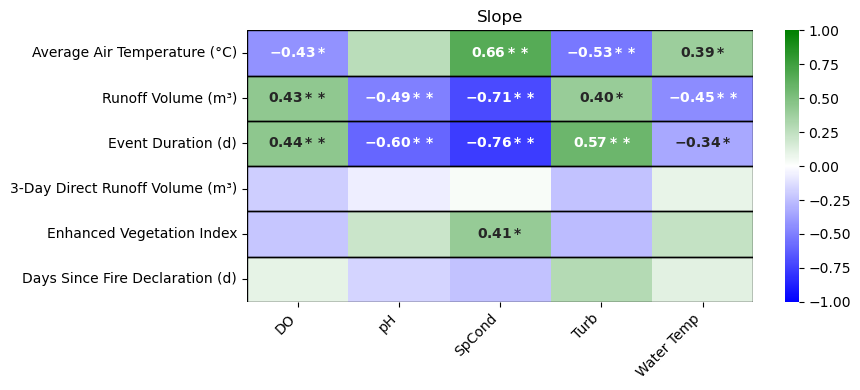

In [82]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle

# Assuming summary_corr and summary_pval dataframes are already defined
summary_corr_df = summary_corr.loc[['corr_slope_Tevent', 'corr_slope_Qtot', 'corr_slope_Tdelta', 'corr_slope_SF3d', 'corr_slope_EVI', 'corr_slope_dayfrac']]
summary_pval_df = summary_corr.loc[['pval_slope_Tevent', 'pval_slope_Qtot', 'pval_slope_Tdelta', 'pval_slope_SF3d', 'pval_slope_EVI', 'pval_slope_dayfrac']]

# Function to show only significant values with '*' or '**'
def significant_values(value, p_value):
    if p_value < 0.01:
        return f'$\mathbf{{{value:.2f}**}}$'  # Two asterisks for p < 0.01
    elif p_value < 0.05:
        return f'$\mathbf{{{value:.2f}*}}$'   # One asterisk for p < 0.05
    else:
        return ''  # Leave non-significant values blank

# Create an annotation DataFrame with only significant values
annotation_df = summary_corr_df.copy().astype(str)
for row in summary_corr_df.index:
    pval_row = 'pval_' + row.split('_')[1] + '_' + row.split('_')[2]  # Adjusting the split logic
    for col in summary_corr_df.columns:
        value = summary_corr_df.at[row, col]
        p_value = summary_pval_df.at[pval_row, col]
        annotation_df.at[row, col] = significant_values(value, p_value)

# Custom colormap from blue to green
colors = [(0, 'blue'), (0.5, 'white'), (1, 'green')]
cmap = LinearSegmentedColormap.from_list("Custom", colors)

# No need to transpose the data, plot directly
heatmap_data = summary_corr_df
annotation_data = annotation_df

# Create a heatmap using Seaborn with only significant correlations annotated
plt.figure(figsize=(9, 4))
ax = sns.heatmap(heatmap_data, annot=annotation_data.values, fmt='', cmap=cmap, cbar=True, vmin=-1, vmax=1, annot_kws={"size": 10})

# Set the y-axis labels as the previous x-axis labels
ax.set_yticklabels(['Average Air Temperature (°C)', 'Runoff Volume (m³)', 'Event Duration (d)', '3-Day Direct Runoff Volume (m³)', 'Enhanced Vegetation Index', 'Days Since Fire Declaration (d)'])


# Set the x-axis labels as the previous y-axis labels (i.e., row names)
ax.set_xticklabels(heatmap_data.columns, rotation=45, ha="right")  # Rotating x-axis labels by 45 degrees

# Remove the x-axis labels
# ax.set_xticklabels([])  # This will hide the x-axis labels

# Remove the default x-axis label
# ax.set_ylabel("Variables")

# Set the title
plt.title("Slope")

# Draw rectangles around each row of boxes (1 row, 5 columns)
for i in range(heatmap_data.shape[0]):
    # Adjust the rectangle dimensions and positioning
    rect = Rectangle((0, i), heatmap_data.shape[1], 1, fill=False, edgecolor='black', lw=1)
    ax.add_patch(rect)
    
# Adjust the layout to ensure labels are not cut off
plt.tight_layout()

# Saving the Figure as an .eps file
# plt.savefig('/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Ch1 CQ Analysis/Manuscript_CQ/3_Final Figures for Manuscript/Final_Figure_Illustrator/071525_hm_slope_Mont_all.eps', format='eps')

# Show the plot
plt.show()


### Lourdes Heatmap of All Events

In [83]:
#Filtered dataframe values

# Create a dictionary to store the results
results = {}

# List of DataFrame names and their corresponding dataframes
dataframes = {
    'DO': DO_event_L_ind,
    'pH': pH_event_L_ind,
    'SpCond': SpCond_event_L_ind,
    'Turb': Turb_event_L_ind,
    'Temp': Temp_event_L_ind
}

# Iterate over each dataframe and calculate correlation and p-value
for name, df in dataframes.items():

    corr_slope_Tevent, pval_slope_Tevent = calc_spearman_corr(df, 'Tevent_avg', 'slope')
    corr_inter_Tevent, pval_inter_Tevent = calc_spearman_corr(df, 'Tevent_avg', 'inter')
    corr_slope_Qtot, pval_slope_Qtot = calc_spearman_corr(df, 'Qtot', 'slope')
    corr_inter_Qtot, pval_inter_Qtot = calc_spearman_corr(df, 'Qtot', 'inter')
    corr_slope_Tdelta, pval_slope_Tdelta = calc_spearman_corr(df, 'Tdelta', 'slope')
    corr_inter_Tdelta, pval_inter_Tdelta = calc_spearman_corr(df, 'Tdelta', 'inter')
    corr_slope_SF3d, pval_slope_SF3d = calc_spearman_corr(df, 'SF3d', 'slope')
    corr_inter_SF3d, pval_inter_SF3d = calc_spearman_corr(df, 'SF3d', 'inter')
    corr_slope_EVI, pval_slope_EVI = calc_spearman_corr(df, 'EVI', 'slope')
    corr_inter_EVI, pval_inter_EVI = calc_spearman_corr(df, 'EVI', 'inter')
    corr_slope_dayfrac, pval_slope_dayfrac = calc_spearman_corr(df, 'day_fract_new', 'slope')
    corr_inter_dayfrac, pval_inter_dayfrac = calc_spearman_corr(df, 'day_fract_new', 'inter')
    results[name] = {
        'corr_slope_Tevent': corr_slope_Tevent,
        'pval_slope_Tevent': pval_slope_Tevent,
        'corr_inter_Tevent': corr_inter_Tevent,
        'pval_inter_Tevent': pval_inter_Tevent,
        'corr_slope_Qtot': corr_slope_Qtot,
        'pval_slope_Qtot': pval_slope_Qtot,
        'corr_inter_Qtot': corr_inter_Qtot,
        'pval_inter_Qtot': pval_inter_Qtot,
        'corr_slope_Tdelta': corr_slope_Tdelta,
        'pval_slope_Tdelta': pval_slope_Tdelta,
        'corr_inter_Tdelta': corr_inter_Tdelta,
        'pval_inter_Tdelta': pval_inter_Tdelta,
        'corr_slope_SF3d': corr_slope_SF3d,
        'pval_slope_SF3d': pval_slope_SF3d,
        'corr_inter_SF3d': corr_inter_SF3d,
        'pval_inter_SF3d': pval_inter_SF3d,
        'corr_slope_EVI': corr_slope_EVI,
        'pval_slope_EVI': pval_slope_EVI,
        'corr_inter_EVI': corr_inter_EVI,
        'pval_inter_EVI': pval_inter_EVI,
        'corr_slope_dayfrac': corr_slope_dayfrac,
        'pval_slope_dayfrac': pval_slope_dayfrac,
        'corr_inter_dayfrac': corr_inter_dayfrac,
        'pval_inter_dayfrac': pval_inter_dayfrac
    }


# Convert the dictionary to a DataFrame
summary_corr = pd.DataFrame(results)

print(summary_corr)

                          DO        pH        SpCond      Turb      Temp
corr_slope_Tevent  -0.082364  0.379032  3.478424e-01 -0.467355  0.206191
pval_slope_Tevent   0.613378  0.035481  2.785095e-02  0.002362  0.201784
corr_inter_Tevent  -0.508818 -0.475403 -3.868668e-01  0.220263  0.648405
pval_inter_Tevent   0.000800  0.006875  1.366157e-02  0.172024  0.000006
corr_slope_Qtot    -0.126829 -0.046774 -4.165103e-02 -0.070356  0.162852
pval_slope_Qtot     0.435473  0.802694  7.985827e-01  0.666179  0.315365
corr_inter_Qtot    -0.030394 -0.462097 -7.664165e-01  0.627955  0.050281
pval_inter_Qtot     0.852307  0.008868  8.176422e-09  0.000014  0.757992
corr_slope_Tdelta   0.229874 -0.134893 -6.755489e-03  0.122162 -0.216739
pval_slope_Tdelta   0.153597  0.469371  9.670001e-01  0.452690  0.179162
corr_inter_Tdelta   0.313473  0.190543  5.029086e-02 -0.022143 -0.198349
pval_inter_Tdelta   0.048876  0.304539  7.579480e-01  0.892121  0.219852
corr_slope_SF3d    -0.319137 -0.048790 -1.478424e-0

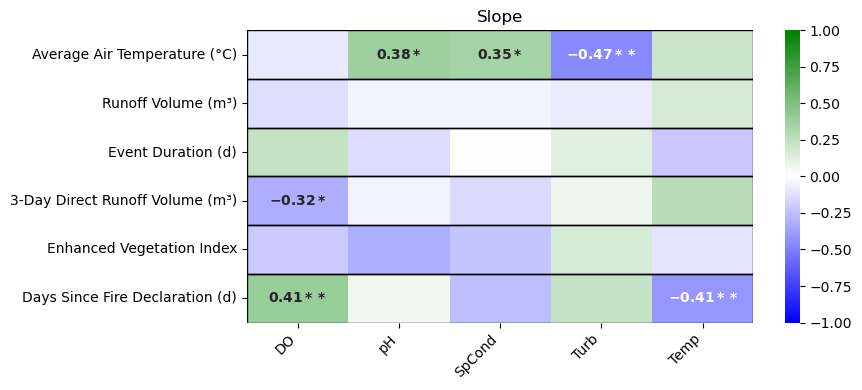

In [84]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle

# Assuming summary_corr and summary_pval dataframes are already defined
summary_corr_df = summary_corr.loc[['corr_slope_Tevent', 'corr_slope_Qtot', 'corr_slope_Tdelta', 'corr_slope_SF3d', 'corr_slope_EVI', 'corr_slope_dayfrac']]
summary_pval_df = summary_corr.loc[['pval_slope_Tevent', 'pval_slope_Qtot', 'pval_slope_Tdelta', 'pval_slope_SF3d', 'pval_slope_EVI', 'pval_slope_dayfrac']]

# Function to show only significant values with '*' or '**'
def significant_values(value, p_value):
    if p_value < 0.01:
        return f'$\mathbf{{{value:.2f}**}}$'  # Two asterisks for p < 0.01
    elif p_value < 0.05:
        return f'$\mathbf{{{value:.2f}*}}$'   # One asterisk for p < 0.05
    else:
        return ''  # Leave non-significant values blank

# Create an annotation DataFrame with only significant values
annotation_df = summary_corr_df.copy().astype(str)
for row in summary_corr_df.index:
    pval_row = 'pval_' + row.split('_')[1] + '_' + row.split('_')[2]  # Adjusting the split logic
    for col in summary_corr_df.columns:
        value = summary_corr_df.at[row, col]
        p_value = summary_pval_df.at[pval_row, col]
        annotation_df.at[row, col] = significant_values(value, p_value)

# Custom colormap from blue to green
colors = [(0, 'blue'), (0.5, 'white'), (1, 'green')]
cmap = LinearSegmentedColormap.from_list("Custom", colors)

# No need to transpose the data, plot directly
heatmap_data = summary_corr_df
annotation_data = annotation_df

# Create a heatmap using Seaborn with only significant correlations annotated
plt.figure(figsize=(9, 4))
ax = sns.heatmap(heatmap_data, annot=annotation_data.values, fmt='', cmap=cmap, cbar=True, vmin=-1, vmax=1, annot_kws={"size": 10})

# Set the y-axis labels as the previous x-axis labels
ax.set_yticklabels(['Average Air Temperature (°C)', 'Runoff Volume (m³)', 'Event Duration (d)', '3-Day Direct Runoff Volume (m³)', 'Enhanced Vegetation Index', 'Days Since Fire Declaration (d)'])


# Set the x-axis labels as the previous y-axis labels (i.e., row names)
ax.set_xticklabels(heatmap_data.columns, rotation=45, ha="right")  # Rotating x-axis labels by 45 degrees

# Remove the x-axis labels
# ax.set_xticklabels([])  # This will hide the x-axis labels

# Remove the default x-axis label
# ax.set_ylabel("Variables")

# Set the title
plt.title("Slope")

# Draw rectangles around each row of boxes (1 row, 5 columns)
for i in range(heatmap_data.shape[0]):
    # Adjust the rectangle dimensions and positioning
    rect = Rectangle((0, i), heatmap_data.shape[1], 1, fill=False, edgecolor='black', lw=1)
    ax.add_patch(rect)
    
# Adjust the layout to ensure labels are not cut off
plt.tight_layout()

# Saving the Figure as an .eps file
# plt.savefig('/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Ch1 CQ Analysis/Manuscript_CQ/3_Final Figures for Manuscript/Final_Figure_Illustrator/071525_hm_slope_Lour_all.eps', format='eps')

# Show the plot
plt.show()


### Santa Rosa Heatmap of All Events

In [87]:
#Filtered dataframe values

# Create a dictionary to store the results
results = {}

# List of DataFrame names and their corresponding dataframes
dataframes = {
    'DO': DO_event_SR_ind,
    'pH': pH_event_SR_ind,
    'SpCond': SpCond_event_SR_ind,
    'Turb': Turb_event_SR_ind,
    'Temp': Temp_event_SR_ind
}

# Iterate over each dataframe and calculate correlation and p-value
for name, df in dataframes.items():

    corr_slope_Tevent, pval_slope_Tevent = calc_spearman_corr(df, 'Tevent_avg', 'slope')
    corr_inter_Tevent, pval_inter_Tevent = calc_spearman_corr(df, 'Tevent_avg', 'inter')
    corr_slope_Qtot, pval_slope_Qtot = calc_spearman_corr(df, 'Qtot', 'slope')
    corr_inter_Qtot, pval_inter_Qtot = calc_spearman_corr(df, 'Qtot', 'inter')
    corr_slope_Tdelta, pval_slope_Tdelta = calc_spearman_corr(df, 'Tdelta', 'slope')
    corr_inter_Tdelta, pval_inter_Tdelta = calc_spearman_corr(df, 'Tdelta', 'inter')
    corr_slope_SF3d, pval_slope_SF3d = calc_spearman_corr(df, 'SF3d', 'slope')
    corr_inter_SF3d, pval_inter_SF3d = calc_spearman_corr(df, 'SF3d', 'inter')
    corr_slope_EVI, pval_slope_EVI = calc_spearman_corr(df, 'EVI', 'slope')
    corr_inter_EVI, pval_inter_EVI = calc_spearman_corr(df, 'EVI', 'inter')
    corr_slope_dayfrac, pval_slope_dayfrac = calc_spearman_corr(df, 'day_fract_new', 'slope')
    corr_inter_dayfrac, pval_inter_dayfrac = calc_spearman_corr(df, 'day_fract_new', 'inter')
    results[name] = {
        'corr_slope_Tevent': corr_slope_Tevent,
        'pval_slope_Tevent': pval_slope_Tevent,
        'corr_inter_Tevent': corr_inter_Tevent,
        'pval_inter_Tevent': pval_inter_Tevent,
        'corr_slope_Qtot': corr_slope_Qtot,
        'pval_slope_Qtot': pval_slope_Qtot,
        'corr_inter_Qtot': corr_inter_Qtot,
        'pval_inter_Qtot': pval_inter_Qtot,
        'corr_slope_Tdelta': corr_slope_Tdelta,
        'pval_slope_Tdelta': pval_slope_Tdelta,
        'corr_inter_Tdelta': corr_inter_Tdelta,
        'pval_inter_Tdelta': pval_inter_Tdelta,
        'corr_slope_SF3d': corr_slope_SF3d,
        'pval_slope_SF3d': pval_slope_SF3d,
        'corr_inter_SF3d': corr_inter_SF3d,
        'pval_inter_SF3d': pval_inter_SF3d,
        'corr_slope_EVI': corr_slope_EVI,
        'pval_slope_EVI': pval_slope_EVI,
        'corr_inter_EVI': corr_inter_EVI,
        'pval_inter_EVI': pval_inter_EVI,
        'corr_slope_dayfrac': corr_slope_dayfrac,
        'pval_slope_dayfrac': pval_slope_dayfrac,
        'corr_inter_dayfrac': corr_inter_dayfrac,
        'pval_inter_dayfrac': pval_inter_dayfrac
    }


# Convert the dictionary to a DataFrame
summary_corr = pd.DataFrame(results)

# print(summary_corr)

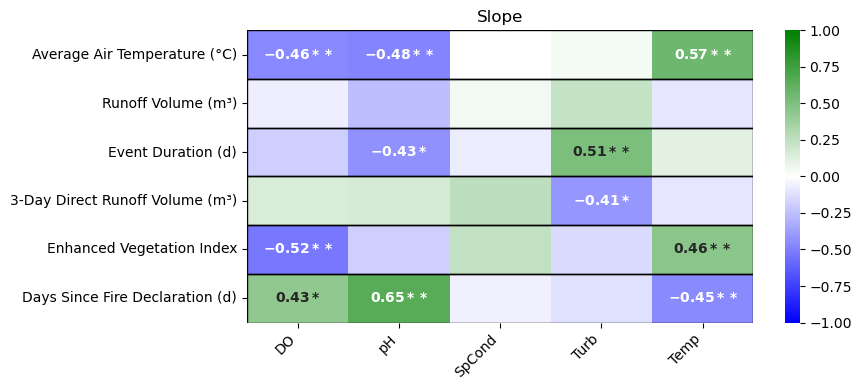

In [86]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle

# Assuming summary_corr and summary_pval dataframes are already defined
summary_corr_df = summary_corr.loc[['corr_slope_Tevent', 'corr_slope_Qtot', 'corr_slope_Tdelta', 'corr_slope_SF3d', 'corr_slope_EVI', 'corr_slope_dayfrac']]
summary_pval_df = summary_corr.loc[['pval_slope_Tevent', 'pval_slope_Qtot', 'pval_slope_Tdelta', 'pval_slope_SF3d', 'pval_slope_EVI', 'pval_slope_dayfrac']]

# Function to show only significant values with '*' or '**'
def significant_values(value, p_value):
    if p_value < 0.01:
        return f'$\mathbf{{{value:.2f}**}}$'  # Two asterisks for p < 0.01
    elif p_value < 0.05:
        return f'$\mathbf{{{value:.2f}*}}$'   # One asterisk for p < 0.05
    else:
        return ''  # Leave non-significant values blank

# Create an annotation DataFrame with only significant values
annotation_df = summary_corr_df.copy().astype(str)
for row in summary_corr_df.index:
    pval_row = 'pval_' + row.split('_')[1] + '_' + row.split('_')[2]  # Adjusting the split logic
    for col in summary_corr_df.columns:
        value = summary_corr_df.at[row, col]
        p_value = summary_pval_df.at[pval_row, col]
        annotation_df.at[row, col] = significant_values(value, p_value)

# Custom colormap from blue to green
colors = [(0, 'blue'), (0.5, 'white'), (1, 'green')]
cmap = LinearSegmentedColormap.from_list("Custom", colors)

# No need to transpose the data, plot directly
heatmap_data = summary_corr_df
annotation_data = annotation_df

# Create a heatmap using Seaborn with only significant correlations annotated
plt.figure(figsize=(9, 4))
ax = sns.heatmap(heatmap_data, annot=annotation_data.values, fmt='', cmap=cmap, cbar=True, vmin=-1, vmax=1, annot_kws={"size": 10})

# Set the y-axis labels as the previous x-axis labels
ax.set_yticklabels(['Average Air Temperature (°C)', 'Runoff Volume (m³)', 'Event Duration (d)', '3-Day Direct Runoff Volume (m³)', 'Enhanced Vegetation Index', 'Days Since Fire Declaration (d)'])


# Set the x-axis labels as the previous y-axis labels (i.e., row names)
ax.set_xticklabels(heatmap_data.columns, rotation=45, ha="right")  # Rotating x-axis labels by 45 degrees

# Remove the x-axis labels
# ax.set_xticklabels([])  # This will hide the x-axis labels

# Remove the default x-axis label
# ax.set_ylabel("Variables")

# Set the title
plt.title("Slope")

# Draw rectangles around each row of boxes (1 row, 5 columns)
for i in range(heatmap_data.shape[0]):
    # Adjust the rectangle dimensions and positioning
    rect = Rectangle((0, i), heatmap_data.shape[1], 1, fill=False, edgecolor='black', lw=1)
    ax.add_patch(rect)
    
# Adjust the layout to ensure labels are not cut off
plt.tight_layout()

# Saving the Figure as an .eps file
# plt.savefig('/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Ch1 CQ Analysis/Manuscript_CQ/3_Final Figures for Manuscript/Final_Figure_Illustrator/071525_hm_slope_SR_all.eps', format='eps')

# Show the plot
plt.show()


## Exceedance Probability Plots for Water Quality Parameters
<a class="anchor" id="exceedance_probability"></a>

Weibull Distribution:

Pexc. = 100*(m/(n+1))

m = index representing ranked values of discharge from highest to lowest (lowest to highest)
n = total number of observations

In [91]:
import pandas as pd

def max_values_df(dataframes, col_name="Value", col_new_name="DO_Mont", **additional_lists):
    # Initialize lists to store the max values, start dates, and end dates for the primary list
    max_values_list = []
    start_dates = []
    end_dates = []
    
    # Iterate through each dataframe in the primary list
    for df in dataframes:
        # Get the maximum value in the specified column
        max_value = df[col_name].max()
        max_values_list.append(max_value)
        
        # Get the start and end dates
        start_date = df['Timestamp (UTC+00:00)'].min()
        end_date = df['Timestamp (UTC+00:00)'].max()
        start_dates.append(start_date)
        end_dates.append(end_date)
    
    # Create the resulting DataFrame with start and end dates first, followed by the max values
    max_values_df = pd.DataFrame({
        "Start_Date": start_dates,
        "End_Date": end_dates,
        col_new_name: max_values_list
    })
    
    # Set the index names as "DataFrame_1", "DataFrame_2", etc.
    max_values_df.index = [f"DataFrame_{i+1}" for i in range(len(dataframes))]
    
    # Process each additional list provided in additional_lists
    for list_name, df_list in additional_lists.items():
        # Calculate the max values for each dataframe in the additional list
        additional_max_values = [df[col_name].max() for df in df_list]
        
        # Add these as a new column to max_values_df with the specified column name
        max_values_df[list_name] = additional_max_values
    
    return max_values_df

import pandas as pd

def min_values_df(dataframes, col_name="Value", col_new_name="DO_Mont", **additional_lists):
    # Initialize lists to store the max values, start dates, and end dates for the primary list
    min_values_list = []
    start_dates = []
    end_dates = []
    
    # Iterate through each dataframe in the primary list
    for df in dataframes:
        # Get the maximum value in the specified column
        min_value = df[col_name].min()
        min_values_list.append(min_value)
        
        # Get the start and end dates
        start_date = df['Timestamp (UTC+00:00)'].min()
        end_date = df['Timestamp (UTC+00:00)'].max()
        start_dates.append(start_date)
        end_dates.append(end_date)
    
    # Create the resulting DataFrame with start and end dates first, followed by the max values
    min_values_df = pd.DataFrame({
        "Start_Date": start_dates,
        "End_Date": end_dates,
        col_new_name: min_values_list
    })
    
    # Set the index names as "DataFrame_1", "DataFrame_2", etc.
    min_values_df.index = [f"DataFrame_{i+1}" for i in range(len(dataframes))]
    
    # Process each additional list provided in additional_lists
    for list_name, df_list in additional_lists.items():
        # Calculate the max values for each dataframe in the additional list
        additional_min_values = [df[col_name].min() for df in df_list]
        
        # Add these as a new column to max_values_df with the specified column name
        min_values_df[list_name] = additional_min_values
    
    return min_values_df

In [92]:
## Combine the list of dataframes with for each parameter and location
# Montezuma
DO_event_df_M_all = data_df_list_Mont_DO
pH_event_df_M_all = data_df_list_Mont_pH
SpCond_event_df_M_all = data_df_list_Mont_SpCond
Turb_event_df_M_all = data_df_list_Mont_Turb
Temp_event_df_M_all = data_df_list_Mont_Temp
#Lourdes
DO_event_df_L_all = data_df_list_Lour_DO
pH_event_df_L_all = data_df_list_Lour_pH
SpCond_event_df_L_all = data_df_list_Lour_SpCond
Turb_event_df_L_all = data_df_list_Lour_Turb
Temp_event_df_L_all = data_df_list_Lour_Temp
#Santa Rosa
DO_event_df_SR_all = data_df_list_SR_DO
pH_event_df_SR_all = data_df_list_SR_pH
SpCond_event_df_SR_all = data_df_list_SR_SpCond
Turb_event_df_SR_all = data_df_list_SR_Turb
Temp_event_df_SR_all = data_df_list_SR_Temp

## Find the max and min values of each event for each location
max_val_Mont = max_values_df(
    DO_event_df_M_all,
    col_name="Value",
    col_new_name="DO_Mont",
    pH_Mont=pH_event_df_M_all,
    SpCond_Mont=SpCond_event_df_M_all,
    Turb_Mont=Turb_event_df_M_all,
    Temp_Mont=Temp_event_df_M_all
)

min_val_Mont = min_values_df(
    DO_event_df_M_all,
    col_name="Value",
    col_new_name="DO_Mont",
    pH_Mont=pH_event_df_M_all,
    SpCond_Mont=SpCond_event_df_M_all,
    Turb_Mont=Turb_event_df_M_all,
    Temp_Mont=Temp_event_df_M_all
)



In [93]:
# === 📚 Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import mannwhitneyu

# === 🛠️ Data Loading & Processing Functions ===

def load_and_filter(file_path, unit=None, value_type=None):
    """Load historical EPA data and filter based on unit and value type."""
    selected_cols = [
        'ActivityStartDate', 'ActivityStartTime/Time', 'HydrologicCondition',
        'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'ResultValueTypeName'
    ]
    df = pd.read_csv(file_path, usecols=selected_cols)
    df = df[df['ResultMeasureValue'].notna()]
    if unit:
        df = df[df['ResultMeasure/MeasureUnitCode'] == unit]
    if value_type:
        df = df[df['ResultValueTypeName'] == value_type]
    df['ActivityStartDate'] = pd.to_datetime(df['ActivityStartDate'])
    return df

def extract_month(df, date_col='ActivityStartDate'):
    """Add 'Month' column based on a date column."""
    df['Month'] = pd.to_datetime(df[date_col]).dt.month
    return df

def calculate_pexc(df, value_col, ascending=False):
    """Calculate exceedance probability (Pexc) based on ranking."""
    df['Rank'] = df[value_col].rank(method='min', ascending=ascending)
    df['Pexc'] = (df['Rank'] / (len(df) + 1)) * 100
    return df

def calculate_exceedance_curve(values, ascending=False):
    """Sort values and calculate exceedance probability."""
    sorted_vals = np.sort(values)[::-1] if not ascending else np.sort(values)
    ranks = np.arange(1, len(sorted_vals) + 1)
    exceedance_prob = 100 * ranks / (len(sorted_vals) + 1)
    return sorted_vals, exceedance_prob

def interpolate_thresholds(df, x_col, y_col, thresholds):
    """Interpolate y-values at given x (Pexc) thresholds."""
    df_sorted = df.sort_values(by=x_col)
    return np.interp(thresholds, df_sorted[x_col], df_sorted[y_col])

def bootstrap_exceedance(data, n_iterations=1000, ci=90):
    """Bootstrap confidence intervals for exceedance curves."""
    n = len(data)
    bootstrapped = np.zeros((n_iterations, n))
    for i in range(n_iterations):
        resample = np.random.choice(data, size=n, replace=True)
        bootstrapped[i, :] = np.sort(resample)[::-1]
    lower_bound = np.percentile(bootstrapped, (100 - ci) / 2, axis=0)
    upper_bound = np.percentile(bootstrapped, 100 - (100 - ci) / 2, axis=0)
    return lower_bound, upper_bound

def interpolate_at_thresholds(df_epa, df_sensor, 
                              x_col='Pexc', y_col='Turbidity', 
                              sensor_x=None, sensor_y=None, 
                              thresholds=[5, 10, 20, 50]):
    """
    Interpolate both EPA and Sensor values at given exceedance thresholds.
    Returns a summary DataFrame with both columns.
    - df_epa: DataFrame with EPA exceedance values
    - df_sensor: optional, if sensor_x/sensor_y not given
    - sensor_x: array-like exceedance probabilities for sensor
    - sensor_y: array-like values for sensor
    """
    # EPA interpolation
    df_epa_sorted = df_epa.sort_values(by=x_col)
    epa_interp_vals = np.interp(thresholds, df_epa_sorted[x_col], df_epa_sorted[y_col])

    # Sensor interpolation
    if sensor_x is not None and sensor_y is not None:
        sensor_interp_vals = np.interp(thresholds, sensor_x, sensor_y)
    else:
        df_sensor_sorted = df_sensor.sort_values(by=x_col)
        sensor_interp_vals = np.interp(thresholds, df_sensor_sorted[x_col], df_sensor_sorted[y_col])

    return pd.DataFrame({
        'Exceedance Probability (%)': thresholds,
        f'{y_col} (EPA)': epa_interp_vals,
        f'{y_col} (Sensor)': sensor_interp_vals
    })


# === 🎨 Plotting Function ===
import matplotlib.patches as mpatches

def plot_combined_epa_and_sensor(df_epa_combined, value_col, date_col, pexc_col,
                                 sensor_exceedance, sensor_values,
                                 sensor_lower_ci, sensor_upper_ci,
                                 fire_date, thresholds=None,
                                 xlabel='Exceedance Probability (%)', ylabel='', title='', save_path=None):
    """
    Plot exceedance probability with EPA pre/post samples (circle markers),
    sensor event extremes with CI, and vertical threshold lines.
    Pre-fire points: transparent fill; post-fire: solid fill.
    Returns threshold value table for both EPA and sensor data.
    """
    fig, ax = plt.subplots(figsize=(4, 6.5))

    # Split pre/post-fire EPA
    pre_fire = df_epa_combined[df_epa_combined[date_col] < fire_date]
    post_fire = df_epa_combined[df_epa_combined[date_col] >= fire_date]

    # === Plot EPA Pre-Fire: unfilled blue circles ===
    ax.scatter(pre_fire[pexc_col], pre_fire[value_col],
               edgecolor='blue', facecolor='blue', alpha=0.2, s=40, linewidth=1.2,
               label='Pre-Fire (Historical)')

    # === Plot EPA Post-Fire: filled blue circles ===
    ax.scatter(post_fire[pexc_col], post_fire[value_col],
               color='blue', s=40, label='Post-Fire (Historical)')

    # === Plot Sensor Events: filled red circles ===
    ax.scatter(sensor_exceedance, sensor_values,
               color='red', s=40, label='Event Extremes (EXO Sensor)')

    # === Plot Sensor Confidence Interval ===
    ax.fill_between(sensor_exceedance, sensor_lower_ci, sensor_upper_ci,
                    color='red', alpha=0.2, label='Sensor 90% CI')

    # === Threshold lines ===
    if thresholds:
        for t in thresholds:
            ax.axvline(x=t, color='gray', linestyle='--', lw=0.7)

    # === Axes and formatting ===
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel, labelpad=10)
    ax.set_title(title, pad=15)
    ax.set_xlim(0, 100)
    ax.set_yscale('log')
    ax.invert_xaxis()
    ax.grid(True, linestyle='--', linewidth=0.5)

    # === Custom Legend ===
    legend_elements = [
        mpatches.Patch(facecolor='blue', alpha=0.2,edgecolor='blue', label='Pre-Fire (Historical)'),
        mpatches.Patch(facecolor='blue', label='Post-Fire (Historical)'),
        mpatches.Patch(facecolor='red', label='Event Extremes (EXO Sensor)'),
        mpatches.Patch(facecolor='red', alpha=0.2, label='Sensor 90% CI')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=8, title='Historical Discrete Samples')

    # === Save if requested ===
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='eps', bbox_inches='tight')
    plt.show()

    # === Return threshold values for EPA and Sensor ===
    from scipy.interpolate import interp1d

    # Interpolation for EPA
    epa_interp = interp1d(df_epa_combined[pexc_col], df_epa_combined[value_col],
                          bounds_error=False, fill_value="extrapolate")
    epa_thresh_vals = epa_interp(thresholds)

    # Interpolation for Sensor
    sensor_interp = interp1d(sensor_exceedance, sensor_values,
                             bounds_error=False, fill_value="extrapolate")
    sensor_thresh_vals = sensor_interp(thresholds)

    threshold_table = pd.DataFrame({
        'Exceedance Probability (%)': thresholds,
        'EPA Value at Threshold': epa_thresh_vals,
        'Sensor Value at Threshold': sensor_thresh_vals
    })

    return threshold_table


### Maximum Event Values  (Table S4)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


   Parameter  Exceedance (%)  Historical EPA  Sensor Event Max  \
0         DO               5        9.560000         12.290000   
1         DO              10        8.880000         11.106000   
2         DO              20        8.590000         10.027000   
3         DO              50        8.150000          8.640000   
4         DO             100        6.800000          7.820000   
5         pH               5        8.708333          8.440000   
6         pH              10        8.450000          8.315877   
7         pH              20        8.300000          8.204048   
8         pH              50        7.941667          8.130000   
9         pH             100        6.200000          7.780000   
10    SpCond               5      314.150000        422.700000   
11    SpCond              10      303.300000        284.050000   
12    SpCond              20      284.800000        260.490000   
13    SpCond              50      232.500000        225.700000   
14    SpCo

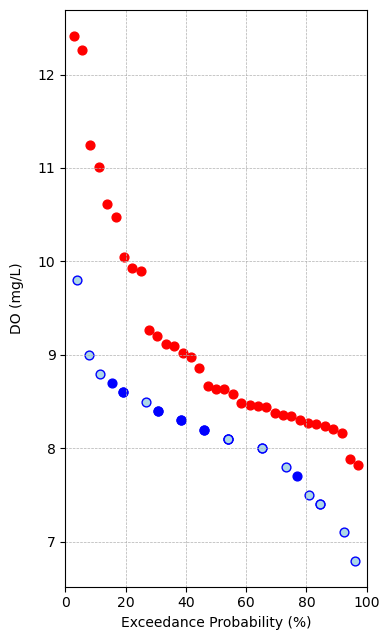

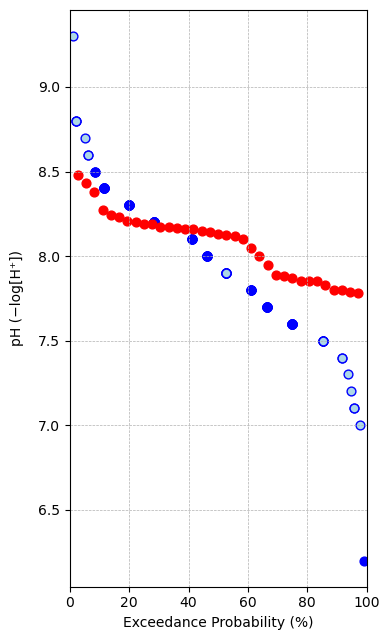

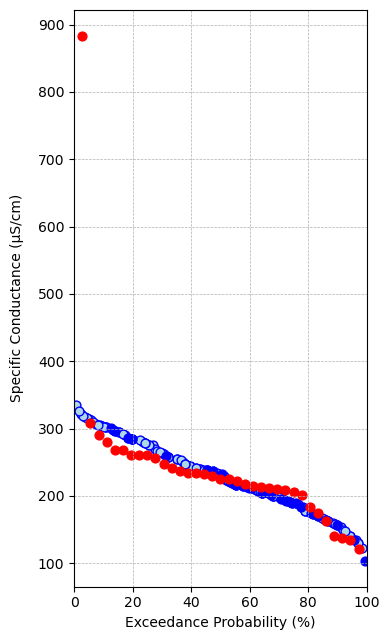

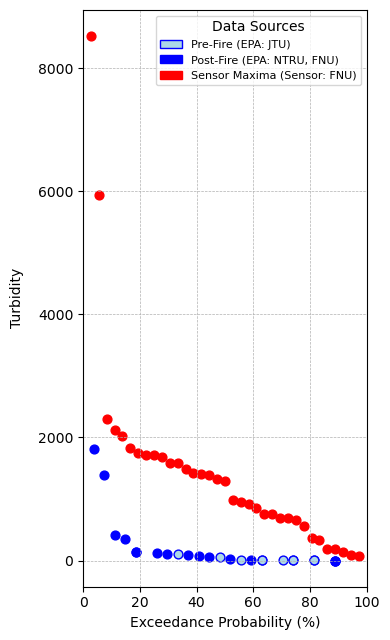

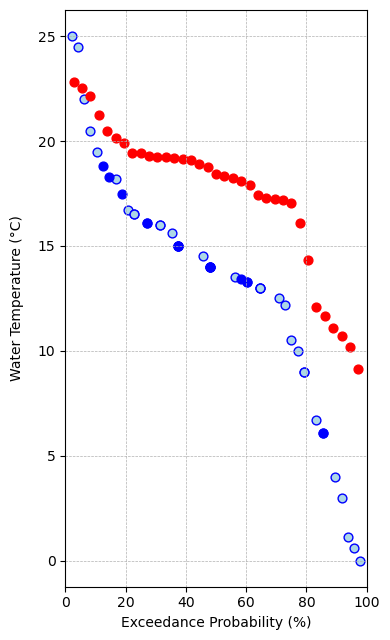

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import mannwhitneyu
import os
from pingouin import compute_effsize
from statsmodels.stats.power import TTestIndPower

# === SETTINGS ===
fire_date = pd.Timestamp('2022-04-06')
output_dir = 'C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Ch1 CQ Analysis/Manuscript_CQ/3_Final Figures for Manuscript/Final_Figure_Illustrator/GMZ/'
thresholds = [5, 10, 20, 50, 100]

# === FILE PATHS ===
file_paths = {
    'DO': f'{output_dir}do2_mz.csv',
    'pH': f'{output_dir}ph_data_mz.csv',
    'SpCond': f'{output_dir}sp_cond_data_mz.csv',
    'Turb': f'{output_dir}turbidity_data_mz.csv',
    'Temp': f'{output_dir}watertemp.csv'
}

# === SENSOR EXTREMES (to be defined before running)
sensor_extremes = {
    'DO': max_val_Mont['DO_Mont'],
    'pH': max_val_Mont['pH_Mont'],
    'SpCond': max_val_Mont['SpCond_Mont'],
    'Turb': max_val_Mont['Turb_Mont'],
    'Temp': max_val_Mont['Temp_Mont']
}

def plot_combined_epa_and_sensor(df_epa_combined, value_col, date_col, pexc_col,
                                 sensor_exceedance, sensor_values,
                                 sensor_lower_ci, sensor_upper_ci,
                                 fire_date, thresholds=None,
                                 xlabel='Exceedance Probability (%)', ylabel='', title='', save_path=None,
                                 param=None):
    fig, ax = plt.subplots(figsize=(4, 6.5))
    pre_fire = df_epa_combined[df_epa_combined[date_col] < fire_date]
    post_fire = df_epa_combined[df_epa_combined[date_col] >= fire_date]

    is_eps = save_path.endswith('.eps') if save_path else False
    pre_color = '#add8e6' if is_eps else 'blue'  # light blue for .eps, transparent blue for .png
    pre_alpha = 1.0 if is_eps else 0.2

    ax.scatter(pre_fire[pexc_col], pre_fire[value_col], edgecolor='blue', facecolor=pre_color,
               alpha=pre_alpha, s=40, linewidth=1.0, label='Pre-Fire')

    ax.scatter(post_fire[pexc_col], post_fire[value_col], color='blue', s=40, label='Post-Fire')
    ax.scatter(sensor_exceedance, sensor_values, color='red', s=40, label='Sensor Event Maxima')

    if not is_eps:
        ax.fill_between(sensor_exceedance, sensor_lower_ci, sensor_upper_ci,
                        color='red', alpha=0.2, label='Sensor 90% CI')

    ax.set_xlabel(xlabel)

    # === Units for y-axis ===
    units = {
        'DO': 'mg/L',
        'pH': '−log[H⁺]',
        'SpCond': 'μS/cm',
        'Turb': {'pre': 'JTU', 'post': 'NTRU, FNU', 'sensor': 'FNU'},
        'Temp': '°C'
    }

    # Custom full names
    pretty_param_names = {
        'DO': 'DO',
        'pH': 'pH',
        'SpCond': 'Specific Conductance',
        'Temp': 'Water Temperature',
        'Turb': 'Turbidity'
    }

    if param == 'Turb':
        ax.set_ylabel(pretty_param_names[param], labelpad=10)
    else:
        unit = units[param]
        ax.set_ylabel(f"{pretty_param_names[param]} ({unit})", labelpad=10)

    # === Clean title ===
    ax.set_title("")  # No title
    ax.set_xlim(0, 100)
    ax.grid(True, linestyle='--', linewidth=0.5)

    # === Legend only for Turb ===
    if param == 'Turb':
        unit_pre = units["Turb"]["pre"]
        unit_post = units["Turb"]["post"]
        unit_sensor = units["Turb"]["sensor"]

        legend_elements = [
            mpatches.Patch(facecolor=pre_color, edgecolor='blue', alpha=pre_alpha,
                           label=f'Pre-Fire (EPA: {unit_pre})'),
            mpatches.Patch(facecolor='blue', edgecolor='blue',
                           label=f'Post-Fire (EPA: {unit_post})'),
            mpatches.Patch(facecolor='red', edgecolor='red',
                           label=f'Sensor Maxima (Sensor: {unit_sensor})')
        ]

        if not is_eps:
            legend_elements.append(
                mpatches.Patch(facecolor='red', alpha=0.2, edgecolor='red',
                               label='Sensor 90% CI')
            )

        ax.legend(handles=legend_elements, loc='upper right', fontsize=8, title='Data Sources')

    plt.tight_layout()

    if save_path:
        ext = os.path.splitext(save_path)[1].lower()
        plt.savefig(save_path, format=ext[1:], bbox_inches='tight')


def clean_historical_data(param, path):
    selected_columns = [
        'ActivityStartDate', 'ActivityStartTime/Time', 'HydrologicCondition',
        'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'ResultValueTypeName'
    ]
    df = pd.read_csv(path, usecols=selected_columns)
    if param == 'DO':
        df = df[df['ResultMeasure/MeasureUnitCode'] == 'mg/l']
    if param == 'Turb':
        df = df[df['ResultValueTypeName'] == 'Actual']
    df = df[df['ResultMeasureValue'].notna()]
    df['ActivityStartDate'] = pd.to_datetime(df['ActivityStartDate'])
    return df

def exceedance_analysis():
    results = []
    for param in file_paths.keys():
        hist_df = clean_historical_data(param, file_paths[param])
        df_pre = hist_df[hist_df['ActivityStartDate'] < fire_date]
        df_post = hist_df[hist_df['ActivityStartDate'] >= fire_date]
        sensor_vals = sensor_extremes[param].dropna().values

        stat1, p1 = mannwhitneyu(df_pre['ResultMeasureValue'], df_post['ResultMeasureValue'], alternative='two-sided')
        stat2, p2 = mannwhitneyu(df_pre['ResultMeasureValue'], sensor_vals, alternative='two-sided')
        stat3, p3 = mannwhitneyu(df_post['ResultMeasureValue'], sensor_vals, alternative='two-sided')

        cohen_d1 = compute_effsize(df_pre['ResultMeasureValue'], df_post['ResultMeasureValue'], eftype='cohen')
        cohen_d2 = compute_effsize(df_pre['ResultMeasureValue'], sensor_vals, eftype='cohen')
        cohen_d3 = compute_effsize(df_post['ResultMeasureValue'], sensor_vals, eftype='cohen')

        alpha = 0.05
        analysis = TTestIndPower()
        power1 = analysis.power(effect_size=cohen_d1, nobs1=len(df_pre), ratio=len(df_post)/len(df_pre), alpha=alpha)
        power2 = analysis.power(effect_size=cohen_d2, nobs1=len(df_pre), ratio=len(sensor_vals)/len(df_pre), alpha=alpha)
        power3 = analysis.power(effect_size=cohen_d3, nobs1=len(df_post), ratio=len(sensor_vals)/len(df_post), alpha=alpha)

        hist_df['Rank'] = hist_df['ResultMeasureValue'].rank(method='min', ascending=False)
        hist_df['Pexc'] = 100 * hist_df['Rank'] / (len(hist_df) + 1)
        hist_sorted = hist_df.sort_values('Pexc')

        sensor_sorted = np.sort(sensor_vals)[::-1]
        sensor_exceed = 100 * np.arange(1, len(sensor_sorted) + 1) / (len(sensor_sorted) + 1)

        bootstrapped = np.array([
            np.sort(np.random.choice(sensor_vals, size=len(sensor_vals), replace=True))[::-1]
            for _ in range(1000)
        ])
        sensor_lower_ci = np.percentile(bootstrapped, 5, axis=0)
        sensor_upper_ci = np.percentile(bootstrapped, 95, axis=0)

        epa_interp = np.interp(thresholds, hist_sorted['Pexc'], hist_sorted['ResultMeasureValue'])
        sensor_interp = np.interp(thresholds, sensor_exceed, sensor_sorted)

        for i, t in enumerate(thresholds):
            threshold_val = epa_interp[i]
            results.append({
                'Parameter': param,
                'Exceedance (%)': t,
                'Historical EPA': threshold_val,
                'Sensor Event Max': sensor_interp[i],
                'p (EPA pre vs post)': p1,
                'p (EPA pre vs sensor)': p2,
                'p (EPA post vs sensor)': p3,
                'Cohen d (pre vs post)': cohen_d1,
                'Cohen d (pre vs sensor)': cohen_d2,
                'Cohen d (post vs sensor)': cohen_d3,
                'Power (pre vs post)': power1,
                'Power (pre vs sensor)': power2,
                'Power (post vs sensor)': power3,
                'Count Pre ≥ T': np.sum(df_pre['ResultMeasureValue'] >= threshold_val),
                'Count Post ≥ T': np.sum(df_post['ResultMeasureValue'] >= threshold_val)
            })

        for ext in ['eps']:
            save_path = os.path.join(output_dir, f'{param}_exceedance_plot.{ext}')
            plot_combined_epa_and_sensor(
                df_epa_combined=hist_df,
                value_col='ResultMeasureValue',
                date_col='ActivityStartDate',
                pexc_col='Pexc',
                sensor_exceedance=sensor_exceed,
                sensor_values=sensor_sorted,
                sensor_lower_ci=sensor_lower_ci,
                sensor_upper_ci=sensor_upper_ci,
                fire_date=fire_date,
                thresholds=thresholds,
                xlabel='Exceedance Probability (%)',
                ylabel=f'{param} Values',
                save_path=save_path,
                param=param
            )

    return pd.DataFrame(results)

# === RUN ANALYSIS ===
df_results = exceedance_analysis()
print(df_results)
# df_results.to_csv(os.path.join(output_dir, 'exceedance_summary_table_MAX.csv'), index=False)
print("✅ All plots (.png and .eps) and summary table saved.")


### Minimum Event Values  (Table S5)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


   Parameter  Exceedance (%)  Historical EPA (min)  Sensor Event Min  \
0         DO               5              6.890000          5.298000   
1         DO              10              7.280000          6.710000   
2         DO              20              7.540000          7.142000   
3         DO              50              8.200000          7.630000   
4         DO             100              9.800000          9.430000   
5         pH               5              7.187500          7.131000   
6         pH              10              7.508333          7.252000   
7         pH              20              7.640000          7.394000   
8         pH              50              8.025000          7.620000   
9         pH             100              9.300000          8.173232   
10    SpCond               5            139.250000         67.700000   
11    SpCond              10            157.350000         96.240000   
12    SpCond              20            176.800000        118.85

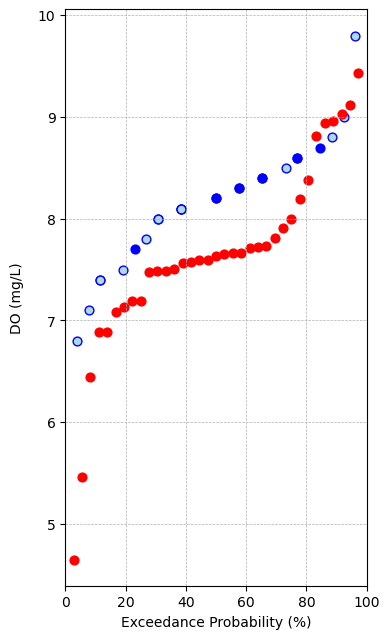

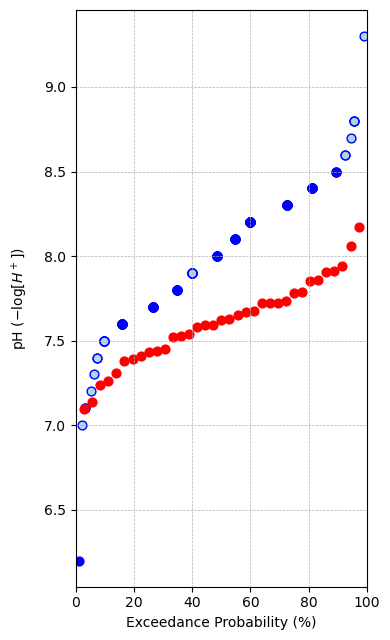

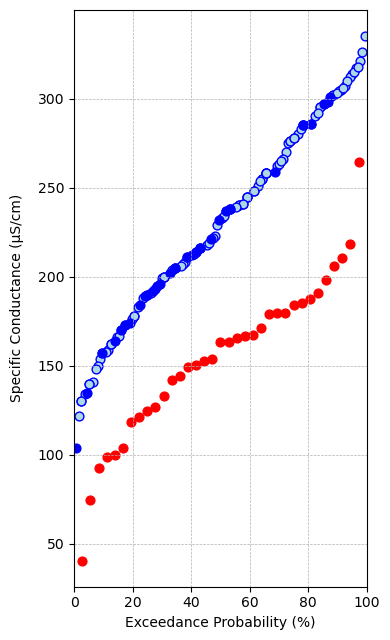

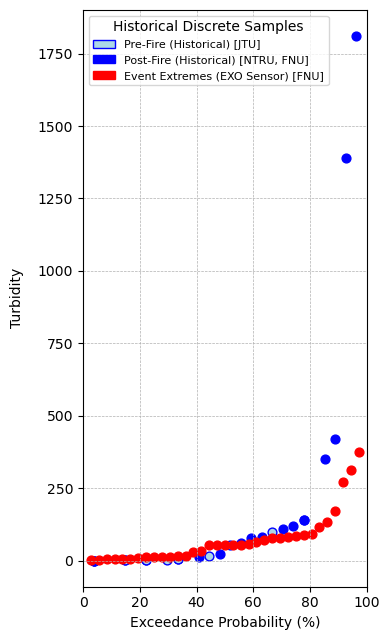

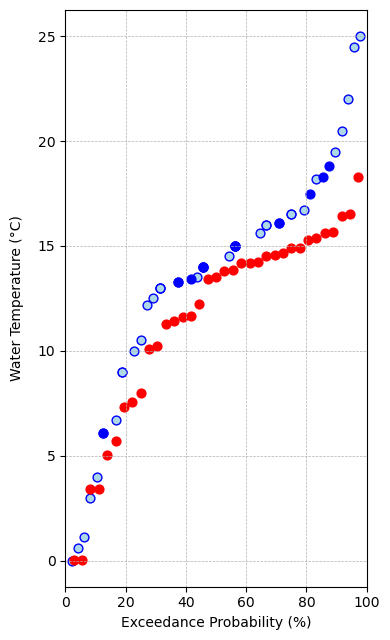

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import mannwhitneyu
import os

# === SETTINGS ===
fire_date = pd.Timestamp('2022-04-06')
output_dir = 'C:/Users/ptunb/OneDrive - University of New Mexico/PhD - Wildfire Research/Ch1 CQ Analysis/Manuscript_CQ/3_Final Figures for Manuscript/Final_Figure_Illustrator/GMZ/'
os.makedirs(output_dir, exist_ok=True)
thresholds = [5, 10, 20, 50, 100]

# === SIMULATED SENSOR EXTREMES ===
sensor_extremes_min = {
    'DO': min_val_Mont['DO_Mont'],
    'pH': min_val_Mont['pH_Mont'],
    'SpCond': min_val_Mont['SpCond_Mont'],
    'Turb': min_val_Mont['Turb_Mont'],
    'Temp': min_val_Mont['Temp_Mont']
}

unit_labels = {
    'DO': 'mg/L',
    'pH': r'$-\log[H^+]$',
    'SpCond': 'µS/cm',
    'Turb': {'pre': 'JTU', 'post': 'NTRU, FNU', 'sensor': 'FNU'},
    'Temp': '°C'
}

def plot_combined_epa_and_sensor_min_custom(param, df_epa_combined, value_col, date_col, pexc_col,
                                            sensor_exceedance, sensor_values,
                                            sensor_lower_ci, sensor_upper_ci,
                                            fire_date, thresholds=None,
                                            xlabel='Exceedance Probability (%)', ylabel='', save_path=None):
    is_eps = save_path.endswith('.eps') if save_path else False
    fig, ax = plt.subplots(figsize=(4, 6.5))
    pre_fire = df_epa_combined[df_epa_combined[date_col] < fire_date]
    post_fire = df_epa_combined[df_epa_combined[date_col] >= fire_date]

    # === Colors and style ===
    pre_color = '#add8e6' if is_eps else 'blue'
    pre_alpha = 1.0 if is_eps else 0.2

    ax.scatter(pre_fire[pexc_col], pre_fire[value_col], edgecolor='blue', facecolor=pre_color,
               alpha=pre_alpha, s=40, linewidth=1.0)

    ax.scatter(post_fire[pexc_col], post_fire[value_col],
               color='blue', s=40)

    ax.scatter(sensor_exceedance, sensor_values,
               color='red', s=40)

    if not is_eps:
        ax.fill_between(sensor_exceedance, sensor_lower_ci, sensor_upper_ci,
                        color='red', alpha=0.2)

    # === Axis formatting ===
    ax.set_xlabel(xlabel)

    # Custom full names
    pretty_param_names = {
        'DO': 'DO',
        'pH': 'pH',
        'SpCond': 'Specific Conductance',
        'Temp': 'Water Temperature',
        'Turb': 'Turbidity'
    }

    if param == 'Turb':
        ax.set_ylabel(pretty_param_names[param], labelpad=10)
    else:
        unit = unit_labels[param]
        ax.set_ylabel(f"{pretty_param_names[param]} ({unit})", labelpad=10)

    ax.set_title("")  # No title
    ax.set_xlim(0, 100)
    ax.grid(True, linestyle='--', linewidth=0.5)

    # === Legend only for Turb ===
    if param == 'Turb':
        pre_label = f"Pre-Fire (Historical) [{unit_labels[param]['pre']}]"
        post_label = f"Post-Fire (Historical) [{unit_labels[param]['post']}]"
        sensor_label = f"Event Extremes (EXO Sensor) [{unit_labels[param]['sensor']}]"

        legend_elements = [
            mpatches.Patch(facecolor=pre_color, edgecolor='blue', alpha=pre_alpha, label=pre_label),
            mpatches.Patch(facecolor='blue', edgecolor='blue', label=post_label),
            mpatches.Patch(facecolor='red', edgecolor='red', label=sensor_label)
        ]

        if not is_eps:
            legend_elements.append(
                mpatches.Patch(facecolor='red', edgecolor='red', alpha=0.2, label='Sensor 90% CI')
            )

        ax.legend(handles=legend_elements, loc='upper left', fontsize=8, title='Historical Discrete Samples')

    plt.tight_layout()

    if save_path:
        ext = os.path.splitext(save_path)[1].lower()
        plt.savefig(save_path, format=ext[1:], bbox_inches='tight')


# Returning the plot function for reuse
plot_combined_epa_and_sensor_min_custom

# === CLEANING FUNCTION ===
def clean_historical_data(param, path):
    selected_columns = [
        'ActivityStartDate', 'ActivityStartTime/Time', 'HydrologicCondition',
        'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'ResultValueTypeName'
    ]
    df = pd.read_csv(path, usecols=selected_columns)
    if param == 'DO':
        df = df[df['ResultMeasure/MeasureUnitCode'] == 'mg/l']
    if param == 'Turb':
        df = df[df['ResultValueTypeName'] == 'Actual']
    df = df[df['ResultMeasureValue'].notna()]
    df['ActivityStartDate'] = pd.to_datetime(df['ActivityStartDate'])
    return df

# === MAIN ANALYSIS FUNCTION ===
def exceedance_analysis_min():
    results = []

    for param in file_paths.keys():
        hist_df = clean_historical_data(param, file_paths[param])
        df_pre = hist_df[hist_df['ActivityStartDate'] < fire_date]
        df_post = hist_df[hist_df['ActivityStartDate'] >= fire_date]
        sensor_vals = sensor_extremes_min[param].dropna().values

        # Mann–Whitney U tests
        stat1, p1 = mannwhitneyu(df_pre['ResultMeasureValue'], df_post['ResultMeasureValue'], alternative='two-sided')
        stat2, p2 = mannwhitneyu(df_pre['ResultMeasureValue'], sensor_vals, alternative='two-sided')
        stat3, p3 = mannwhitneyu(df_post['ResultMeasureValue'], sensor_vals, alternative='two-sided')
        
        # Effect size (Cohen's d)
        cohen_d1 = compute_effsize(df_pre['ResultMeasureValue'], df_post['ResultMeasureValue'], eftype='cohen')
        cohen_d2 = compute_effsize(df_pre['ResultMeasureValue'], sensor_vals, eftype='cohen')
        cohen_d3 = compute_effsize(df_post['ResultMeasureValue'], sensor_vals, eftype='cohen')

        # Full dataset Pexc (ascending)
        hist_df = hist_df.copy()
        hist_df['Rank'] = hist_df['ResultMeasureValue'].rank(method='min', ascending=True)
        hist_df['Pexc'] = 100 * hist_df['Rank'] / (len(hist_df) + 1)
        hist_sorted = hist_df.sort_values('Pexc')

        sensor_sorted = np.sort(sensor_vals)
        sensor_exceed = 100 * np.arange(1, len(sensor_sorted) + 1) / (len(sensor_sorted) + 1)

        # Bootstrap sensor CI
        bootstrapped = np.array([
            np.sort(np.random.choice(sensor_vals, size=len(sensor_vals), replace=True))
            for _ in range(1000)
        ])
        sensor_lower_ci = np.percentile(bootstrapped, 5, axis=0)
        sensor_upper_ci = np.percentile(bootstrapped, 95, axis=0)

        # Interpolation
        epa_interp = np.interp(thresholds, hist_sorted['Pexc'], hist_sorted['ResultMeasureValue'])
        sensor_interp = np.interp(thresholds, sensor_exceed, sensor_sorted)

        for i, t in enumerate(thresholds):
            threshold_val = epa_interp[i]
            results.append({
                'Parameter': param,
                'Exceedance (%)': t,
                'Historical EPA (min)': threshold_val,
                'Sensor Event Min': sensor_interp[i],
                'p (EPA pre vs post)': p1,
                'p (EPA pre vs sensor)': p2,
                'p (EPA post vs sensor)': p3,
                'Cohen d (pre vs post)': cohen_d1,
                'Cohen d (pre vs sensor)': cohen_d2,
                'Cohen d (post vs sensor)': cohen_d3,
                'Count Pre ≤ T': np.sum(df_pre['ResultMeasureValue'] <= threshold_val),
                'Count Post ≤ T': np.sum(df_post['ResultMeasureValue'] <= threshold_val)
            })

        # Plot
        for ext in ['eps']:
            save_path = os.path.join(output_dir, f'{param}_exceedance_plot_min.{ext}')
            plot_combined_epa_and_sensor_min_custom(
                param=param,
                df_epa_combined=hist_df,
                value_col='ResultMeasureValue',
                date_col='ActivityStartDate',
                pexc_col='Pexc',
                sensor_exceedance=sensor_exceed,
                sensor_values=sensor_sorted,
                sensor_lower_ci=sensor_lower_ci,
                sensor_upper_ci=sensor_upper_ci,
                fire_date=fire_date,
                thresholds=thresholds,
                xlabel='Exceedance Probability (%)',
                ylabel=f'{param} Values',
                save_path=save_path
    )


    return pd.DataFrame(results)

# === RUN ===
df_results_min = exceedance_analysis_min()
# df_results_min.to_csv(os.path.join(output_dir, 'exceedance_summary_table_MIN.csv'), index=False)
print(df_results_min)
print("✅ All plots and updated threshold summary table saved.")


## Summary Statistics
<a class="anchor" id="summary_statistics"></a>

### Table S2 Values

In [88]:
import pandas as pd

# === Define all three groups ===
df_groups = {
    'M': {
        'DO': DO_event_M_ind,
        'pH': pH_event_M_ind,
        'SpCond': SpCond_event_M_ind,
        'Turb': Turb_event_M_ind,
        'Temp': Temp_event_M_ind
    },
    'L': {
        'DO': DO_event_L_ind,
        'pH': pH_event_L_ind,
        'SpCond': SpCond_event_L_ind,
        'Turb': Turb_event_L_ind,
        'Temp': Temp_event_L_ind
    },
    'SR': {
        'DO': DO_event_SR_ind,
        'pH': pH_event_SR_ind,
        'SpCond': SpCond_event_SR_ind,
        'Turb': Turb_event_SR_ind,
        'Temp': Temp_event_SR_ind
    }
}

# === Loop over each group ===
for group_label, df_list in df_groups.items():
    # Combine all dataframes in this group
    combined_df = pd.concat(df_list.values(), ignore_index=True)
    numeric_df = combined_df.select_dtypes(include='number')

    # Compute global min/max
    global_min = numeric_df.min()
    global_max = numeric_df.max()

    # Summary table
    global_summary = pd.DataFrame({
        'Global Min': global_min,
        'Global Max': global_max
    })

    print(f"\n=== Global Min and Max for {group_label} Group ===")
    print(global_summary.round(3))



=== Global Min and Max for M Group ===
               Global Min   Global Max
Tevent_avg         -2.430       22.129
Qtot             3986.899  1478617.417
Tdelta              0.208        8.958
SF3d             4429.157   899513.627
EVI                 0.123        0.273
day_fract_new      76.479      509.125
slope              -2.817        4.053
inter               0.460        3.003

=== Global Min and Max for L Group ===
               Global Min  Global Max
Tevent_avg          5.939      22.023
Qtot             5001.718  903082.750
Tdelta              0.135       5.844
SF3d             1309.875  719994.756
EVI                 0.175       0.271
day_fract_new      98.562     527.406
slope              -1.134       2.344
inter               0.716       3.020

=== Global Min and Max for SR Group ===
               Global Min    Global Max
Tevent_avg          6.166  2.350500e+01
Qtot           172826.048  1.277164e+07
Tdelta              0.240  8.760000e+00
SF3d            11941.060 

### Table S6 Values

In [89]:
# 🔹 DataFrames and site mapping
df_site_map = {
    'df_Mont_all': ('P2_26', df_Mont_all),
    'df_Lour_all': ('P3_61', df_Lour_all),
    'df_SR_all': ('P5_167', df_SR_all)
}

# 🔹 Parameters to process
parameters = ['DO', 'pH', 'SpCond', 'Turb', 'Temp']

# 🔹 Collect summary stats
summary_stats = []

for label, (site, df) in df_site_map.items():
    for param in parameters:
        slope_col = f'slope_{param}'
        inter_col = f'intercept_{param}'
        
        if slope_col in df.columns and inter_col in df.columns:
            summary_stats.append({
                'Parameter': param,
                'Site': site,
                'Slope Median': round(df[slope_col].median(), 3),
                'Slope IQR': round(df[slope_col].quantile(0.75) - df[slope_col].quantile(0.25), 3),
                'Slope Min': round(df[slope_col].min(), 3),
                'Slope Max': round(df[slope_col].max(), 3),
                'Intercept Median': round(df[inter_col].median(), 3),
                'Intercept IQR': round(df[inter_col].quantile(0.75) - df[inter_col].quantile(0.25), 3),
                'Intercept Min': round(df[inter_col].min(), 3),
                'Intercept Max': round(df[inter_col].max(), 3),
            })

# 🔹 Create summary DataFrame
summary_df = pd.DataFrame(summary_stats)

# 🔹 Optional: Order by parameter and site
param_order = ['DO', 'pH', 'SpCond', 'Turb', 'Temp']
site_order = ['P2_26', 'P3_61', 'P5_167']

summary_df['Parameter'] = pd.Categorical(summary_df['Parameter'], categories=param_order, ordered=True)
summary_df['Site'] = pd.Categorical(summary_df['Site'], categories=site_order, ordered=True)
summary_df = summary_df.sort_values(by=['Parameter', 'Site']).reset_index(drop=True)

# 🔹 Save to CSV
summary_df.to_csv("CQ_slope_intercept_summary.csv", index=False)

# 🔹 Print output
print(summary_df)


   Parameter    Site  Slope Median  Slope IQR  Slope Min  Slope Max  \
0         DO   P2_26        -0.011      0.073     -0.093      0.537   
1         DO   P3_61         0.008      0.090     -0.222      0.136   
2         DO  P5_167         0.032      0.106     -0.233      0.326   
3         pH   P2_26        -0.023      0.015     -0.093      0.026   
4         pH   P3_61        -0.004      0.016     -0.048      0.017   
5         pH  P5_167        -0.001      0.009     -0.027      0.016   
6     SpCond   P2_26        -0.058      0.152     -0.306      0.220   
7     SpCond   P3_61        -0.056      0.181     -1.044      0.353   
8     SpCond  P5_167        -0.084      0.131     -0.302      0.289   
9       Turb   P2_26         0.680      1.876     -1.028      4.053   
10      Turb   P3_61         0.361      0.926     -1.134      2.344   
11      Turb  P5_167         0.475      0.554     -0.848      4.184   
12      Temp   P2_26        -0.025      0.180     -2.817      1.463   
13    

### Table S7 Values

In [90]:
import pandas as pd

# 🔹 DataFrames and site mapping
df_site_map = {
    'df_Mont_all': ('P2_26', df_Mont_all),
    'df_Lour_all': ('P3_61', df_Lour_all),
    'df_SR_all': ('P5_167', df_SR_all)
}

# 🔹 Parameters and corresponding slope category columns
param_map = {
    'DO': 'DO_slope_categ',
    'pH': 'pH_slope_categ',
    'SpCond': 'SpCond_slope_categ',
    'Turb': 'Turb_slope_categ',
    'Water Temp': 'Temp_slope_categ'
}
behaviors = ['neg', 'chem', 'pos']

# 🔹 Collect behavior summary from all dataframes
behavior_summary = []

for label, (site, df) in df_site_map.items():
    df['Site'] = site  # Ensure site info is present
    
    for param, col in param_map.items():
        if col in df.columns:
            counts = df.groupby([col]).size().reset_index(name='Count')
            for behavior in behaviors:
                row = counts[counts[col] == behavior]
                count = int(row['Count']) if not row.empty else 0
                behavior_summary.append({
                    'Parameter': param,
                    'Site': site,
                    'Behavior': behavior,
                    'Count': count
                })

# 🔹 Create final dataframe and pivot
behavior_df = pd.DataFrame(behavior_summary)

behavior_pivot = behavior_df.pivot_table(index=['Parameter', 'Site'],
                                         columns='Behavior',
                                         values='Count',
                                         fill_value=0).reset_index()

# 🔹 Order rows: DO P2, DO P3, DO P5, then others
site_order = ['P2_26', 'P3_61', 'P5_167']
param_order = ['DO', 'pH', 'SpCond', 'Turb', 'Water Temp']
behavior_pivot['Parameter'] = pd.Categorical(behavior_pivot['Parameter'], categories=param_order, ordered=True)
behavior_pivot['Site'] = pd.Categorical(behavior_pivot['Site'], categories=site_order, ordered=True)
behavior_pivot = behavior_pivot.sort_values(by=['Parameter', 'Site']).reset_index(drop=True)

# 🔹 Calculate percentage version
def normalize_row(row):
    total = row[behaviors].sum()
    return row[behaviors] / total * 100 if total > 0 else row[behaviors]

behavior_percent = behavior_pivot.copy()
behavior_percent[behaviors] = behavior_percent.apply(normalize_row, axis=1)

# 🔹 Save outputs
behavior_pivot.to_csv("combined_behavior_counts.csv", index=False)
behavior_percent.to_csv("combined_behavior_percentages.csv", index=False)

# 🔹 Display summary
print("\n▶️ Combined Behavior Count Summary:")
print(behavior_pivot)

print("\n📊 Combined Behavior Percentage Summary:")
print(behavior_percent)


▶️ Combined Behavior Count Summary:
Behavior   Parameter    Site  chem  neg  pos
0                 DO   P2_26     8   16   11
1                 DO   P3_61     8   13   19
2                 DO  P5_167    10    8   15
3                 pH   P2_26     3   31    1
4                 pH   P3_61     6   17    8
5                 pH  P5_167    11   13    9
6             SpCond   P2_26    10   19    6
7             SpCond   P3_61     7   21   12
8             SpCond  P5_167     3   24    6
9               Turb   P2_26     2    9   24
10              Turb   P3_61     2   10   28
11              Turb  P5_167     0    3   30
12        Water Temp   P2_26     8   16   11
13        Water Temp   P3_61     6   25    9
14        Water Temp  P5_167     4   22    7

📊 Combined Behavior Percentage Summary:
Behavior   Parameter    Site       chem        neg        pos
0                 DO   P2_26  22.857143  45.714286  31.428571
1                 DO   P3_61  20.000000  32.500000  47.500000
2               

C:\Users\ptunb\AppData\Local\Temp\ipykernel_33896\3472149161.py:31: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  count = int(row['Count']) if not row.empty else 0
C:\Users\ptunb\AppData\Local\Temp\ipykernel_33896\3472149161.py:31: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  count = int(row['Count']) if not row.empty else 0
C:\Users\ptunb\AppData\Local\Temp\ipykernel_33896\3472149161.py:31: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  count = int(row['Count']) if not row.empty else 0
C:\Users\ptunb\AppData\Local\Temp\ipykernel_33896\3472149161.py:31: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  count = int(ro